In [15]:
from IPython.display import display, Image, clear_output

# Comprehensive Lipidome Automation Workflow (CLAW)

Welcome to CLAW, a tool designed to facilitate and optimize the processing of lipidomic MRM data. This Jupyter notebook encapsulates a suite of tools that streamline the various stages of lipidomics data analysis.

Our toolset enables users to efficiently process MRM data files in the mzML format. Upload a file and CLAW will parse the data into a structured Pandas dataframe. This dataframe includes critical information like sample_ID, MRM transition, and signal intensity. Furthermore, our tool aligns each MRM transition with a default or custom lipid_database for accurate and swift annotation.

Moreover, CLAW is equipped with an OzESI option, a tool to elucidate the double bond location in lipid isomers. This feature allows users to input OzESI data and pinpoint the precise location of double bonds in isomeric lipids. Users have the flexibility to select which double bond locations they want to analyze. Following this, CLAW autonomously predicts potential m/z values and cross-references these predictions with sample data, ensuring a comprehensive and meticulous analysis.

With automation at its core, CLAW eliminates the need for manual data processing, significantly reducing time expenditure. It is a robust and invaluable tool for handling large volumes of lipid MRM data, accelerating scientific discovery in the field of lipidomics.

In [16]:
#Import all the necessary python libraries
import pymzml
import csv
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import json
from scipy.integrate import trapz

#Import all the necessary CLAW libraries
import create_directory
import CLAW
import matplotlib.pyplot as plt
import warnings

import re
from sklearn.mixture import GaussianMixture
from tqdm import tqdm  # This imports the tqdm function for progress bars


# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Directory and File Management
For structured data management and efficient workflow, the system first ensures the presence of an output directory. If such a directory already exists you can skip this step.

In [17]:
# # Create the output directory. If it already exists you can skip this step.
# create_directory.create_project_folder()


The name of the project is defined next. This is important as the created directory will bear this name, allowing users to manage and identify their data with ease.

After the mzML files are uploaded to the designated mzML folder, the next block of code segregates these files based on their characteristics. More specifically, it filters the files and transfers them to respective folders named 'o3on' and 'o2only'.

In [18]:
name_of_project = 'FaceFats'
#After you load mzml files to mzml folder. this will filter the files and move them to o3on and o2only folders
create_directory.filter_o3mzml_files(name_of_project)

One or both of the destination directories 'Projects/FaceFats/o3on' and 'Projects/FaceFats/o2only' do not exist.


## Pre-Parsing Setup
The following block of code takes the preset variable values and uses them to parse the mzML files. The parsed data, including the sample ID, MRM transitions, and intensities, is stored in a pandas dataframe for easy manipulation and analysis.

The function CLAW.parsing_mzml_to_df takes several arguments. data_base_name_location is the location of the lipid database that contains information on lipid classes, fatty acid chains, and their corresponding MRM transitions. Project_Folder_data is the location of the mzML files for the samples to be analyzed. tolerance defines the acceptable range of deviation for the MRM transitions when matching them with the lipid database. The argument remove_std is a boolean that, when True, indicates to remove the MRM transitions that correspond to standards (internal or external) present in the samples.

The function outputs a pandas dataframe (df) where each row corresponds to an MRM transition detected in a sample, and columns include the sample ID, MRM transition, and intensity of the transition, among other values.

In [19]:
# Set default values
data_base_name_location = 'lipid_database/Lipid_Database.xlsx'
Project = './Projects/'
Project_Name = 'FaceFats'
Project_Folder_data = Project + Project_Name + '/mzml_brain5xFAD_OzON2/'
Project_results = Project + Project_Name + '/results/'
file_name_to_save = 'Brain5xFAD_OzON'
tolerance = 0.3
remove_std = True
save_data = True

# Call pre_parsing_setup to initialize the variables
data_base_name_location, Project_Folder_data, Project_results, file_name_to_save, tolerance, remove_std, save_data = CLAW.pre_parsing_setup(data_base_name_location,
 Project, 
 Project_Name, 
 Project_Folder_data,
 Project_results, 
 file_name_to_save, 
 tolerance, 
 remove_std,
 save_data)


data_base_name_location: lipid_database/Lipid_Database.xlsx
Project: ./Projects/
Project_Name: FaceFats
Project_Folder_data: ./Projects/FaceFats/mzml_brain5xFAD_OzON2/
Project_results: ./Projects/FaceFats/results/
file_name_to_save: Brain5xFAD_OzON
tolerance: 0.3
remove_std: True
save_data: True


Define the master dataframes where the data will be stored during the parsing step.

In [20]:
time_and_intensity_df, master_df, OzESI_time_df = CLAW.create_analysis_dataframes()

## CLAW.full_parse()
In this code, the `CLAW.full_parse()` function is used to analyze the MRM data. It takes several parameters like the location of the lipid database, paths to the data and results folders, the name of the result files, and the tolerance for MRM transitions matching. The function returns two dataframes: `df_matched` that contains information about each detected lipid species and their corresponding MRM transitions, and `OzESI_time_df` which captures data related to OzESI-MS scans, including potential double bond locations of lipids. If `remove_std` is `True`, it removes MRM transitions related to standards from the dataframe, and if `save_data` is `True`, the dataframe is saved as a .csv file in the specified results folder.

In [21]:
# Use the initialized variables as arguments to full_parse
df_MRM, df_OzESI = CLAW.full_parse(data_base_name_location, 
                                               Project_Folder_data, 
                                               Project_results, 
                                               file_name_to_save, 
                                               tolerance, 
                                               remove_std=True, 
                                               save_data=False,
                                               batch_processing=True,
                                               plot_chromatogram=False)

/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Parent_Ion'] = np.round(lipid_MRM_data['Parent_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Product_Ion'] = np.round(lipid_MRM_data['Product_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Finished parsing mzML file: ./Projects/FaceFats/mzml_brain5xFAD_OzON2/11292023_DOD93_F4_5xFAD_cereb_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brain5xFAD_OzON2/11292023_DOD93_F4_5xFAD_cortex_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brain5xFAD_OzON2/11292023_DOD93_F4_5xFAD_dienc_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brain5xFAD_OzON2/11292023_DOD93_F4_5xFAD_hippo_O3on_01.mzML

Finished parsing all mzML files



In [22]:
df_MRM.head(None)

Class     Intensity                        Lipid  Parent_Ion  \
0      NaN  25452.201778                          NaN       584.4   
1      NaN  23887.601665                          NaN       612.4   
2      NaN  32008.842213                          NaN       622.5   
3      NaN  28793.361992                          NaN       624.5   
4      NaN  25249.781784                          NaN       626.5   
...    ...           ...                          ...         ...   
1195   TAG  29089.642014   [TG(57:9),TG(56:2)]_FA18:1       932.9   
1196   TAG  23347.741581   [TG(58:7),TG(57:0)]_FA18:1       950.9   
1197   TAG  23348.521606  [TG(59:13),TG(58:6)]_FA18:1       952.8   
1198   TAG  23313.661606  [TG(59:12),TG(58:5)]_FA18:1       954.8   
1199   TAG  23889.161686  [TG(59:11),TG(58:4)]_FA18:1       956.9   

      Product_Ion                              Sample_ID      Transition  
0           437.3  11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3  
1           437.3  11292023_DOD93_F4_5xFAD_cereb_O3on_01  612.4 -> 437.3  
2           503.4  11292023_DOD93_F4_5xFAD_cereb_O3on_01  622.5 -> 503.4  
3           505.4  11292023_DOD93_F4_5xFAD_cereb_O3on_01  624.5 -> 505.4  
4           437.3  11292023_DOD93_F4_5xFAD_cereb_O3on_01  626.5 -> 437.3  
...           ...                                    ...             ...  
1195        633.6  11292023_DOD93_F4_5xFAD_hippo_O3on_01  932.9 -> 633.6  
1196        651.6  11292023_DOD93_F4_5xFAD_hippo_O3on_01  950.9 -> 651.6  
1197        653.5  11292023_DOD93_F4_5xFAD_hippo_O3on_01  952.8 -> 653.5  
1198        655.5  11292023_DOD93_F4_5xFAD_hippo_O3on_01  954.8 -> 655.5  
1199        657.6  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6  

[1200 rows x 7 columns]

Group for df_MRM as well

In [23]:
# Creating the Match_Group column
df_MRM['Match_Group'] = df_MRM.groupby(['Parent_Ion', 'Product_Ion', 'Sample_ID']).ngroup()

# Display the DataFrame with the new column
df_MRM

Class     Intensity                        Lipid  Parent_Ion  \
0      NaN  25452.201778                          NaN       584.4   
1      NaN  23887.601665                          NaN       612.4   
2      NaN  32008.842213                          NaN       622.5   
3      NaN  28793.361992                          NaN       624.5   
4      NaN  25249.781784                          NaN       626.5   
...    ...           ...                          ...         ...   
1195   TAG  29089.642014   [TG(57:9),TG(56:2)]_FA18:1       932.9   
1196   TAG  23347.741581   [TG(58:7),TG(57:0)]_FA18:1       950.9   
1197   TAG  23348.521606  [TG(59:13),TG(58:6)]_FA18:1       952.8   
1198   TAG  23313.661606  [TG(59:12),TG(58:5)]_FA18:1       954.8   
1199   TAG  23889.161686  [TG(59:11),TG(58:4)]_FA18:1       956.9   

      Product_Ion                              Sample_ID      Transition  \
0           437.3  11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3   
1           437.3  11292023_DOD93_F4_5xFAD_cereb_O3on_01  612.4 -> 437.3   
2           503.4  11292023_DOD93_F4_5xFAD_cereb_O3on_01  622.5 -> 503.4   
3           505.4  11292023_DOD93_F4_5xFAD_cereb_O3on_01  624.5 -> 505.4   
4           437.3  11292023_DOD93_F4_5xFAD_cereb_O3on_01  626.5 -> 437.3   
...           ...                                    ...             ...   
1195        633.6  11292023_DOD93_F4_5xFAD_hippo_O3on_01  932.9 -> 633.6   
1196        651.6  11292023_DOD93_F4_5xFAD_hippo_O3on_01  950.9 -> 651.6   
1197        653.5  11292023_DOD93_F4_5xFAD_hippo_O3on_01  952.8 -> 653.5   
1198        655.5  11292023_DOD93_F4_5xFAD_hippo_O3on_01  954.8 -> 655.5   
1199        657.6  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6   

      Match_Group  
0               0  
1               4  
2               8  
3              12  
4              16  
...           ...  
1195          559  
1196          563  
1197          567  
1198          571  
1199          575  

[1200 rows x 8 columns]

In [24]:
df_OzESI.head(None)
# df_OzESI.to_csv('FF_OzOFF_full.csv')
# df_OzESI.to_excel('FaceFatsOzdf.xlsx')

Lipid  Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0        NaN       584.4        437.3        0.044183        41.720001   
1        NaN       584.4        437.3        0.088567        41.680004   
2        NaN       584.4        437.3        0.132967        41.240002   
3        NaN       584.4        437.3        0.177367        41.800003   
4        NaN       584.4        437.3        0.221783        41.640003   
...      ...         ...          ...             ...              ...   
675587   NaN       956.9        657.6       24.779100        41.360004   
675588   NaN       956.9        657.6       24.823517        41.380001   
675589   NaN       956.9        657.6       24.867917        41.460003   
675590   NaN       956.9        657.6       24.912333        41.380001   
675591   NaN       956.9        657.6       24.956733        41.380001   

                                    Sample_ID      Transition  
0       11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3  
1       11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3  
2       11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3  
3       11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3  
4       11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3  
...                                       ...             ...  
675587  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6  
675588  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6  
675589  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6  
675590  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6  
675591  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6  

[675592 rows x 7 columns]

The `read_mrm_list()` function is first invoked to read the MRM database from the specified file location and return it as a pandas DataFrame `mrm_database`. Subsequently, the `match_lipids_parser()` function is called to match the detected lipids from the `OzESI_time_df` DataFrame, obtained from the OzESI-MS scans, with the known lipids in the `mrm_database` based on the MRM transitions within the specified `tolerance`. The result is saved in the `df_oz_matched` DataFrame, which now contains matched lipid species from the OzESI-MS data.

In [25]:
d1 = df_OzESI.iloc[:,1:9]

# Assuming d1 is your DataFrame

# Define the retention time range as a tuple (lower_bound, upper_bound)
retention_time_range = (9.5, 21.5)  # Replace with your specific range values

# Filter the DataFrame to keep only rows where Retention_Time is within the specified range
d1a = d1[(d1['Retention_Time'] >= retention_time_range[0]) & (d1['Retention_Time'] <= retention_time_range[1])]

# # Now, filtered_d1 contains only the rows from d1 where Retention_Time is within the specified range
# filtered_d1.to_csv('filtered_d1_FF_OzON_Liver.csv')
d1a

Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
213          584.4        437.3        9.502833        41.660004   
214          584.4        437.3        9.547233        41.900002   
215          584.4        437.3        9.591633        41.660004   
216          584.4        437.3        9.636050        41.700005   
217          584.4        437.3        9.680450        41.640003   
...            ...          ...             ...              ...   
675509       956.9        657.6       21.315350        41.380001   
675510       956.9        657.6       21.359767        41.500004   
675511       956.9        657.6       21.404167        41.360004   
675512       956.9        657.6       21.448567        41.460003   
675513       956.9        657.6       21.492983        41.520004   

                                    Sample_ID      Transition  
213     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3  
214     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3  
215     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3  
216     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3  
217     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3  
...                                       ...             ...  
675509  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6  
675510  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6  
675511  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6  
675512  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6  
675513  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6  

[324272 rows x 6 columns]

# create Group for OzESI df to iterate through it faster instead of checking every single row

In [26]:
# Creating the Match_Group column
d1a['Match_Group'] = d1a.groupby(['Parent_Ion', 'Product_Ion', 'Sample_ID']).ngroup()

# Display the DataFrame with the new column
d1a

/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
213          584.4        437.3        9.502833        41.660004   
214          584.4        437.3        9.547233        41.900002   
215          584.4        437.3        9.591633        41.660004   
216          584.4        437.3        9.636050        41.700005   
217          584.4        437.3        9.680450        41.640003   
...            ...          ...             ...              ...   
675509       956.9        657.6       21.315350        41.380001   
675510       956.9        657.6       21.359767        41.500004   
675511       956.9        657.6       21.404167        41.360004   
675512       956.9        657.6       21.448567        41.460003   
675513       956.9        657.6       21.492983        41.520004   

                                    Sample_ID      Transition  Match_Group  
213     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0  
214     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0  
215     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0  
216     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0  
217     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0  
...                                       ...             ...          ...  
675509  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575  
675510  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575  
675511  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575  
675512  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575  
675513  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575  

[324272 rows x 7 columns]

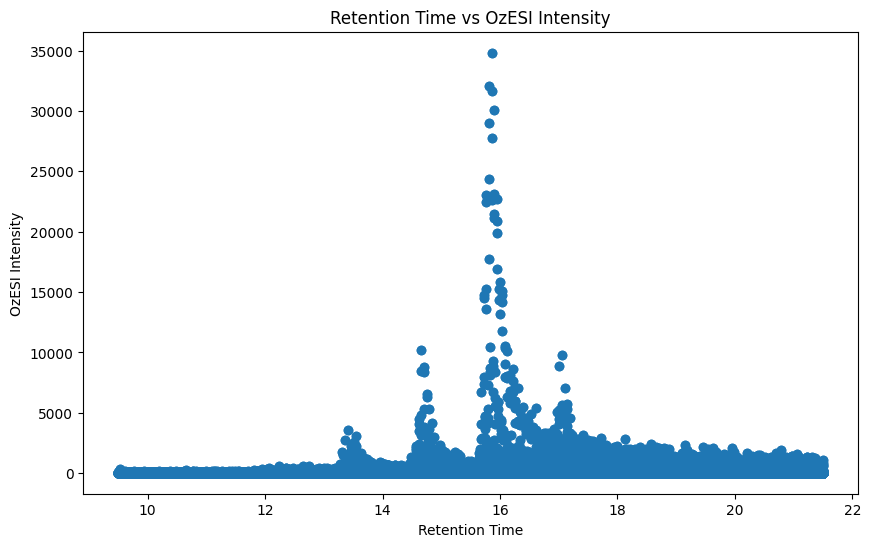

In [27]:


# Assuming clustered_data is your DataFrame with the necessary data

# Plotting the Intensity vs Retention Time
plt.figure(figsize=(10, 6))
plt.scatter(d1a['Retention_Time'], d1a['OzESI_Intensity'])

# Adding labels and title to the plot
plt.xlabel('Retention Time')
plt.ylabel('OzESI Intensity')
plt.title('Retention Time vs OzESI Intensity')

# Displaying the plot
plt.show()


# Pipeline for OzON Truth

# d1a to d1b take raw dataframe and Match Lipids

In [28]:
d1b = d1a.copy()

# Assuming df_MRM and d1b are already defined

# Create Match_Group in d1a if it doesn't exist
if 'Match_Group' not in d1a.columns:
    d1a['Match_Group'] = d1a.groupby(['Parent_Ion', 'Product_Ion', 'Sample_ID']).ngroup()

# Copy Match_Group to d1b
d1b['Match_Group'] = d1a['Match_Group']

# Function to check if two ions are within the tolerance
def is_within_tolerance(ion1, ion2, tolerance=0.3):
    return abs(ion1 - ion2) <= tolerance

# Add a new column for Lipid in d1b
d1b['Lipid'] = None

# Iterate through each unique Match_Group in d1a
for group in d1a['Match_Group'].unique():
    # Extract a representative row for the current group from d1a
    group_row = d1a[d1a['Match_Group'] == group].iloc[0]

    # Find a matching lipid in df_MRM for the representative row
    for _, mrm_row in df_MRM.iterrows():
        if is_within_tolerance(group_row['Parent_Ion'], mrm_row['Parent_Ion']) and is_within_tolerance(group_row['Product_Ion'], mrm_row['Product_Ion']):
            # Assign the lipid to all rows in the corresponding group in d1b
            d1b.loc[d1b['Match_Group'] == group, 'Lipid'] = mrm_row['Lipid']
            break  # Stop searching once a match is found

# Display the updated d1b DataFrame
d1b

Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
213          584.4        437.3        9.502833        41.660004   
214          584.4        437.3        9.547233        41.900002   
215          584.4        437.3        9.591633        41.660004   
216          584.4        437.3        9.636050        41.700005   
217          584.4        437.3        9.680450        41.640003   
...            ...          ...             ...              ...   
675509       956.9        657.6       21.315350        41.380001   
675510       956.9        657.6       21.359767        41.500004   
675511       956.9        657.6       21.404167        41.360004   
675512       956.9        657.6       21.448567        41.460003   
675513       956.9        657.6       21.492983        41.520004   

                                    Sample_ID      Transition  Match_Group  \
213     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
214     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
215     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
216     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
217     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
...                                       ...             ...          ...   
675509  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   
675510  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   
675511  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   
675512  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   
675513  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   

                              Lipid  
213                             NaN  
214                             NaN  
215                             NaN  
216                             NaN  
217                             NaN  
...                             ...  
675509  [TG(59:11),TG(58:4)]_FA18:1  
675510  [TG(59:11),TG(58:4)]_FA18:1  
675511  [TG(59:11),TG(58:4)]_FA18:1  
675512  [TG(59:11),TG(58:4)]_FA18:1  
675513  [TG(59:11),TG(58:4)]_FA18:1  

[324272 rows x 8 columns]

# Add columns for Cage Mouse Genotype and Biology

In [29]:


### make columns for d1c

def extract_details_from_sample_id(df, column_name='Sample_ID'):
    """
    Extracts details from the Sample_ID column and adds them as new columns: Cage, Mouse, Genotype, and Biology.

    Args:
    df (pandas.DataFrame): The DataFrame containing the Sample_ID column.
    column_name (str): The name of the column to extract the details from. Default is 'Sample_ID'.

    Returns:
    pandas.DataFrame: The original DataFrame with added columns 'Cage', 'Mouse', 'Genotype', 'Biology'.
    """
    # Regular expression pattern to extract Cage, Mouse, Genotype, and Biology
    pattern = r'^[^_]*_(?P<Cage>[^_]+)_(?P<Mouse>[^_]+)_(?P<Genotype>[^_]+)_(?P<Biology>[^_]+)'

    # Extract the matched patterns and create the new columns
    df_extracted = df[column_name].str.extract(pattern)

    # Add the new columns to the original DataFrame
    df = pd.concat([df, df_extracted[['Cage', 'Mouse', 'Genotype', 'Biology']]], axis=1)

    return df

# Usage Example:
# Assuming your DataFrame is named df
d1c = extract_details_from_sample_id(d1b)
d1c


# ### make columns for d1c
# def extract_details_from_sample_id(df, column_name='Sample_ID'):
#     """
#     Extracts details from the Sample_ID column and adds them as new columns: Cage, Mouse, Genotype, and Biology.

#     Args:
#     df (pandas.DataFrame): The DataFrame containing the Sample_ID column.
#     column_name (str): The name of the column to extract the details from. Default is 'Sample_ID'.

#     Returns:
#     pandas.DataFrame: The original DataFrame with added columns 'Cage', 'Mouse', 'Genotype', 'Biology'.
#     """
#     # Regular expression pattern to extract Cage, Mouse, Genotype, and Biology
#     pattern = r'^[^_]*_(?P<Cage>[^_]+)_(?P<Mouse>[^_]+)_(?P<Genotype>[^_]+)_(?P<Biology>[^_]+)'

#     # Extract the matched patterns and create the new columns
#     df_extracted = df[column_name].str.extract(pattern)

#     # Add the new columns to the original DataFrame
#     df = pd.concat([df, df_extracted[['Cage', 'Mouse', 'Genotype', 'Biology']]], axis=1)

#     return df

# # Usage Example:
# # Assuming your DataFrame is named df
# d1c = extract_details_from_sample_id(d1c)
# d1c


Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
213          584.4        437.3        9.502833        41.660004   
214          584.4        437.3        9.547233        41.900002   
215          584.4        437.3        9.591633        41.660004   
216          584.4        437.3        9.636050        41.700005   
217          584.4        437.3        9.680450        41.640003   
...            ...          ...             ...              ...   
675509       956.9        657.6       21.315350        41.380001   
675510       956.9        657.6       21.359767        41.500004   
675511       956.9        657.6       21.404167        41.360004   
675512       956.9        657.6       21.448567        41.460003   
675513       956.9        657.6       21.492983        41.520004   

                                    Sample_ID      Transition  Match_Group  \
213     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
214     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
215     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
216     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
217     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
...                                       ...             ...          ...   
675509  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   
675510  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   
675511  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   
675512  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   
675513  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   

                              Lipid   Cage Mouse Genotype Biology  
213                             NaN  DOD93    F4    5xFAD   cereb  
214                             NaN  DOD93    F4    5xFAD   cereb  
215                             NaN  DOD93    F4    5xFAD   cereb  
216                             NaN  DOD93    F4    5xFAD   cereb  
217                             NaN  DOD93    F4    5xFAD   cereb  
...                             ...    ...   ...      ...     ...  
675509  [TG(59:11),TG(58:4)]_FA18:1  DOD93    F4    5xFAD   hippo  
675510  [TG(59:11),TG(58:4)]_FA18:1  DOD93    F4    5xFAD   hippo  
675511  [TG(59:11),TG(58:4)]_FA18:1  DOD93    F4    5xFAD   hippo  
675512  [TG(59:11),TG(58:4)]_FA18:1  DOD93    F4    5xFAD   hippo  
675513  [TG(59:11),TG(58:4)]_FA18:1  DOD93    F4    5xFAD   hippo  

[324272 rows x 12 columns]

# Create Group called Group_Sample based off the Cage Mouse Genotype and Biology

In [30]:
import pandas as pd

def add_group_sample_column(df):
    """
    Adds a new column 'Group_Sample' to the DataFrame, assigning a unique group number 
    for each combination of Cage, Mouse, Genotype, Biology, and Lipid.

    Args:
    df (pandas.DataFrame): The DataFrame to process.

    Returns:
    pandas.DataFrame: The DataFrame with the added 'Group_Sample' column.
    """
    # Create the 'Group_Sample' column by assigning a group number for each combination
    df['Group_Sample'] = df.groupby(['Cage', 'Mouse', 'Genotype', 'Biology', 'Lipid']).ngroup()

    return df

# Usage Example:
# Assuming your DataFrame is named df
d1d = add_group_sample_column(d1c)
d1d


Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
213          584.4        437.3        9.502833        41.660004   
214          584.4        437.3        9.547233        41.900002   
215          584.4        437.3        9.591633        41.660004   
216          584.4        437.3        9.636050        41.700005   
217          584.4        437.3        9.680450        41.640003   
...            ...          ...             ...              ...   
675509       956.9        657.6       21.315350        41.380001   
675510       956.9        657.6       21.359767        41.500004   
675511       956.9        657.6       21.404167        41.360004   
675512       956.9        657.6       21.448567        41.460003   
675513       956.9        657.6       21.492983        41.520004   

                                    Sample_ID      Transition  Match_Group  \
213     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
214     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
215     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
216     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
217     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
...                                       ...             ...          ...   
675509  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   
675510  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   
675511  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   
675512  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   
675513  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   

                              Lipid   Cage Mouse Genotype Biology  \
213                             NaN  DOD93    F4    5xFAD   cereb   
214                             NaN  DOD93    F4    5xFAD   cereb   
215                             NaN  DOD93    F4    5xFAD   cereb   
216                             NaN  DOD93    F4    5xFAD   cereb   
217                             NaN  DOD93    F4    5xFAD   cereb   
...                             ...    ...   ...      ...     ...   
675509  [TG(59:11),TG(58:4)]_FA18:1  DOD93    F4    5xFAD   hippo   
675510  [TG(59:11),TG(58:4)]_FA18:1  DOD93    F4    5xFAD   hippo   
675511  [TG(59:11),TG(58:4)]_FA18:1  DOD93    F4    5xFAD   hippo   
675512  [TG(59:11),TG(58:4)]_FA18:1  DOD93    F4    5xFAD   hippo   
675513  [TG(59:11),TG(58:4)]_FA18:1  DOD93    F4    5xFAD   hippo   

        Group_Sample  
213               -1  
214               -1  
215               -1  
216               -1  
217               -1  
...              ...  
675509           117  
675510           117  
675511           117  
675512           117  
675513           117  

[324272 rows x 13 columns]

# Compare OzOFF vs OzON MAKE SURE TO IMPORT CORRECT OZOFF CSV

In [31]:
OzOFF_Correct_RT = pd.read_csv('Projects/FaceFats/data/OzOFF_CorrectRT/FF_Brain5xFAD_OzOFF_CorrectRT.csv')

d_OzON = d1d.copy()

OzOFF_Correct_RT
# d_OzON


def count_exact_matches_and_create_id(df1, df2, columns):
    """
    Counts the number of exact matches for specified columns between two DataFrames
    and creates a new column 'New_ID' in each DataFrame for matched rows.

    Args:
    df1 (pandas.DataFrame): The first DataFrame.
    df2 (pandas.DataFrame): The second DataFrame.
    columns (list): A list of column names to compare.

    Returns:
    int: The number of exact matches.
    """
    # Create a temporary 'ID' column by concatenating the specified columns
    df1['ID'] = df1[columns].dropna().apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
    df2['ID'] = df2[columns].dropna().apply(lambda row: '-'.join(row.values.astype(str)), axis=1)

    # Create sets of these IDs
    set_df1 = set(df1['ID'])
    set_df2 = set(df2['ID'])

    # Find the intersection of these sets
    matches = set_df1.intersection(set_df2)

    # Create 'New_ID' column based on whether 'ID' is in the matches
    df1['New_ID'] = df1['ID'].apply(lambda x: x if x in matches else None)
    df2['New_ID'] = df2['ID'].apply(lambda x: x if x in matches else None)

    # Drop the temporary 'ID' column
    df1.drop(columns=['ID'], inplace=True)
    df2.drop(columns=['ID'], inplace=True)

    # Return the number of matches
    return len(matches)

# Usage Example:
# Assuming df1 and df2 are your dataframes
columns_to_compare = ['Lipid', 'Cage', 'Mouse', 'Genotype', 'Biology']
print(f"Number of matches: {count_exact_matches_and_create_id(d_OzON, OzOFF_Correct_RT, columns_to_compare)}")




Number of matches: 16


In [32]:
d_OzON
#print unique values in New_ID column
# d_OzON['New_ID'].unique()
# OzOFF_Correct_RT['New_ID'].unique()
# OzOFF_Correct_RT

Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
213          584.4        437.3        9.502833        41.660004   
214          584.4        437.3        9.547233        41.900002   
215          584.4        437.3        9.591633        41.660004   
216          584.4        437.3        9.636050        41.700005   
217          584.4        437.3        9.680450        41.640003   
...            ...          ...             ...              ...   
675509       956.9        657.6       21.315350        41.380001   
675510       956.9        657.6       21.359767        41.500004   
675511       956.9        657.6       21.404167        41.360004   
675512       956.9        657.6       21.448567        41.460003   
675513       956.9        657.6       21.492983        41.520004   

                                    Sample_ID      Transition  Match_Group  \
213     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
214     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
215     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
216     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
217     11292023_DOD93_F4_5xFAD_cereb_O3on_01  584.4 -> 437.3            0   
...                                       ...             ...          ...   
675509  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   
675510  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   
675511  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   
675512  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   
675513  11292023_DOD93_F4_5xFAD_hippo_O3on_01  956.9 -> 657.6          575   

                              Lipid   Cage Mouse Genotype Biology  \
213                             NaN  DOD93    F4    5xFAD   cereb   
214                             NaN  DOD93    F4    5xFAD   cereb   
215                             NaN  DOD93    F4    5xFAD   cereb   
216                             NaN  DOD93    F4    5xFAD   cereb   
217                             NaN  DOD93    F4    5xFAD   cereb   
...                             ...    ...   ...      ...     ...   
675509  [TG(59:11),TG(58:4)]_FA18:1  DOD93    F4    5xFAD   hippo   
675510  [TG(59:11),TG(58:4)]_FA18:1  DOD93    F4    5xFAD   hippo   
675511  [TG(59:11),TG(58:4)]_FA18:1  DOD93    F4    5xFAD   hippo   
675512  [TG(59:11),TG(58:4)]_FA18:1  DOD93    F4    5xFAD   hippo   
675513  [TG(59:11),TG(58:4)]_FA18:1  DOD93    F4    5xFAD   hippo   

        Group_Sample New_ID  
213               -1   None  
214               -1   None  
215               -1   None  
216               -1   None  
217               -1   None  
...              ...    ...  
675509           117   None  
675510           117   None  
675511           117   None  
675512           117   None  
675513           117   None  

[324272 rows x 14 columns]

# Plot comparison between OzOFF and OzON

In [33]:


# def plot_matched_scatter_and_create_df(df1, df2, match_columns, ozesi_intensity_threshold=50):
#     """
#     Plots a scatter plot for each match between two dataframes based on specified columns and creates a new DataFrame
#     with one matching row from each DataFrame for each group. Removes matches where the difference in Correct_RT
#     is greater than 3 and OzESI_Intensity is below 300.

#     Args:
#     df1 (pandas.DataFrame): The first DataFrame (OzON).
#     df2 (pandas.DataFrame): The second DataFrame (OzOFF).
#     match_columns (list): List of column names to match between df1 and df2.
#     ozesi_intensity_threshold (float): The threshold for OzESI_Intensity. Default is 300.

#     Returns:
#     pandas.DataFrame: A DataFrame with one matching row from each DataFrame for each group.
#     """
#     # Apply OzESI_Intensity threshold
#     df1 = df1[df1['OzESI_Intensity'] >= ozesi_intensity_threshold]
#     df2 = df2[df2['OzESI_Intensity'] >= ozesi_intensity_threshold]

#     # Select the first row for each group in both dataframes
#     df1_grouped = df1.groupby(match_columns).first().reset_index()
#     df2_grouped = df2.groupby(match_columns).first().reset_index()

#     # Find common rows based on the match_columns
#     common_rows = pd.merge(df1_grouped, df2_grouped, on=match_columns, suffixes=('_OzON', '_OzOFF'))

#     # Calculate the difference in Correct_RT and filter out rows with difference > 0.5
#     common_rows['RT_Diff'] = (common_rows['Correct_RT_OzON'] - common_rows['Correct_RT_OzOFF']).abs()
#     common_rows = common_rows[common_rows['RT_Diff'] <= 0.8]

#     # Assign a unique group number for each combination of match_columns
#     common_rows['Group_Sample'] = common_rows.groupby(match_columns).ngroup()

#     # Set the figure size
#     plt.figure(figsize=(24, 6))

#     # Plotting
#     plt.scatter(common_rows['Group_Sample'], common_rows['Correct_RT_OzON'], label='OzON', alpha=0.7)
#     plt.scatter(common_rows['Group_Sample'], common_rows['Correct_RT_OzOFF'], label='OzOFF', alpha=0.7, color='r')
#     plt.xlabel('Samples', fontsize=16)
#     plt.ylabel('Retention Time', fontsize=16)
#     plt.title('Brain5xFAD OzOFF vs OzON Sample Comparison', fontsize=20)
#     plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
#     #save directory
#     # plt.savefig('Projects/FaceFats/plots/RT_shift/FF_Brain5xFAD_RTshift.png', bbox_inches='tight')
#     plt.show()

#     # Create a new DataFrame with Group_Sample and the match_columns
#     df_OzOFFvsOzON_Matching = common_rows[['Group_Sample'] + match_columns + ['Correct_RT_OzON', 'Correct_RT_OzOFF']]

#     return df_OzOFFvsOzON_Matching

# # Usage Example
# match_columns = ['Cage', 'Mouse', 'Genotype', 'Biology', 'Lipid']
# df_OzOFFvsOzON_Matching = plot_matched_scatter_and_create_df(d_OzON, OzOFF_Correct_RT, match_columns)


std dev between ozoff and ozon

In [34]:
# # Calculate the difference
# df_OzOFFvsOzON_Matching['RT_Diff'] = df_OzOFFvsOzON_Matching['Correct_RT_OzON'] - df_OzOFFvsOzON_Matching['Correct_RT_OzOFF']

# # Calculate mean and standard deviation of the difference
# mean_diff = df_OzOFFvsOzON_Matching['RT_Diff'].mean()
# std_dev_diff = df_OzOFFvsOzON_Matching['RT_Diff'].std()

# print('mean dif =', abs(mean_diff).round(2),'std dev' ,std_dev_diff.round(2))
# #rename Correct_RT_OzON to RT_OzON and Correct_RT_OzOFF to RT_OzOFF
# # df_OzOFFvsOzON_Matching.rename(columns={'Correct_RT_OzON': 'RT_OzON', 'Correct_RT_OzOFF': 'RT_OzOFF'}, inplace=True)

# df_OzOFFvsOzON_Matching


# Function to match OzON to OzOFF verify OzON Lipids are the correct lipids

In [35]:


## For loop version #1 very slow takes like 10 mins to run

def filter_df_based_on_rt_window(df1, df2, match_columns, rt_window=0.5):
    """
    Filters the first DataFrame based on matching 'Lipid' within each pairing of match_columns
    and a window for the Retention_Time based on the Correct_RT from the second DataFrame.

    Args:
    df1 (pandas.DataFrame): The first DataFrame to be filtered (d_OzON).
    df2 (pandas.DataFrame): The second DataFrame (OzOFF_Correct_RT).
    match_columns (list): List of column names for pairing ('Cage', 'Mouse', 'Genotype', 'Biology').
    rt_window (float): The window for the Retention_Time difference. Default is 0.5.

    Returns:
    pandas.DataFrame: A filtered version of df1 based on lipid matches within the RT window.
    """
    filtered_df = pd.DataFrame()

    # Iterate through each unique combination of match_columns with a progress bar
    for _, group in tqdm(df1.groupby(match_columns), desc="Processing Groups"):
        # Get the corresponding group in df2
        matching_group = df2[df2[match_columns].apply(tuple, axis=1).isin([tuple(group[match_columns].iloc[0])])]
        
        # Iterate through each row in the group from df1
        for _, row in group.iterrows():
            lipid = row['Lipid']
            rt = row['Retention_Time']
            
            # Check if there's a matching lipid within the RT window in df2
            matches = matching_group[(matching_group['Lipid'] == lipid) &
                                     (matching_group['Correct_RT'] >= rt - rt_window) &
                                     (matching_group['Correct_RT'] <= rt + rt_window)]
            
            # If matches are found, append to the filtered DataFrame
            if not matches.empty:
                filtered_df = filtered_df.append(row)

    return filtered_df

# Usage Example:
match_columns = ['Cage', 'Mouse', 'Genotype', 'Biology']
rt_window = 0.5  # User-specified retention time window
d_OzON2 = filter_df_based_on_rt_window(d_OzON, OzOFF_Correct_RT, match_columns, rt_window)


Processing Groups: 100%|██████████| 4/4 [03:12<00:00, 48.17s/it]


Check to make sure for loops worked

In [36]:
d_OzON2

Biology   Cage Genotype  Group_Sample                       Lipid  \
73490    cereb  DOD93    5xFAD           9.0           [TG(54:5)]_FA18:1   
73491    cereb  DOD93    5xFAD           9.0           [TG(54:5)]_FA18:1   
73492    cereb  DOD93    5xFAD           9.0           [TG(54:5)]_FA18:1   
73493    cereb  DOD93    5xFAD           9.0           [TG(54:5)]_FA18:1   
73494    cereb  DOD93    5xFAD           9.0           [TG(54:5)]_FA18:1   
...        ...    ...      ...           ...                         ...   
666983   hippo  DOD93    5xFAD         106.0  [TG(55:9),TG(54:2)]_FA18:1   
666984   hippo  DOD93    5xFAD         106.0  [TG(55:9),TG(54:2)]_FA18:1   
666985   hippo  DOD93    5xFAD         106.0  [TG(55:9),TG(54:2)]_FA18:1   
666986   hippo  DOD93    5xFAD         106.0  [TG(55:9),TG(54:2)]_FA18:1   
666987   hippo  DOD93    5xFAD         106.0  [TG(55:9),TG(54:2)]_FA18:1   

        Match_Group Mouse                                           New_ID  \
73490         496.0    F4           [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb   
73491         496.0    F4           [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb   
73492         496.0    F4           [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb   
73493         496.0    F4           [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb   
73494         496.0    F4           [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb   
...             ...   ...                                              ...   
666983        515.0    F4  [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-hippo   
666984        515.0    F4  [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-hippo   
666985        515.0    F4  [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-hippo   
666986        515.0    F4  [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-hippo   
666987        515.0    F4  [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-hippo   

        OzESI_Intensity  Parent_Ion  Product_Ion  Retention_Time  \
73490        362.100037       898.8        599.5       13.372283   
73491        634.100037       898.8        599.5       13.416683   
73492       2280.580078       898.8        599.5       13.461100   
73493        944.100037       898.8        599.5       13.505500   
73494        573.380066       898.8        599.5       13.549917   
...                 ...         ...          ...             ...   
666983       760.360046       904.8        605.5       17.722933   
666984       606.800049       904.8        605.5       17.767333   
666985       270.580017       904.8        605.5       17.811750   
666986       374.060028       904.8        605.5       17.856150   
666987       785.120056       904.8        605.5       17.900567   

                                    Sample_ID      Transition  
73490   11292023_DOD93_F4_5xFAD_cereb_O3on_01  898.8 -> 599.5  
73491   11292023_DOD93_F4_5xFAD_cereb_O3on_01  898.8 -> 599.5  
73492   11292023_DOD93_F4_5xFAD_cereb_O3on_01  898.8 -> 599.5  
73493   11292023_DOD93_F4_5xFAD_cereb_O3on_01  898.8 -> 599.5  
73494   11292023_DOD93_F4_5xFAD_cereb_O3on_01  898.8 -> 599.5  
...                                       ...             ...  
666983  11292023_DOD93_F4_5xFAD_hippo_O3on_01  904.8 -> 605.5  
666984  11292023_DOD93_F4_5xFAD_hippo_O3on_01  904.8 -> 605.5  
666985  11292023_DOD93_F4_5xFAD_hippo_O3on_01  904.8 -> 605.5  
666986  11292023_DOD93_F4_5xFAD_hippo_O3on_01  904.8 -> 605.5  
666987  11292023_DOD93_F4_5xFAD_hippo_O3on_01  904.8 -> 605.5  

[736 rows x 14 columns]

# plot all the groups for each lipid to make sure they all at the same RT

In [37]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Sample DataFrame, replace with your actual DataFrame
# # filtered_d_OzON = pd.DataFrame(...)

# # Group by Lipid
# lipid_groups = filtered_d_OzON.groupby("Lipid")

# # Determine the number of unique lipids to create subplots
# num_lipids = len(lipid_groups)
# fig, axes = plt.subplots(num_lipids, 1, figsize=(10, 6 * num_lipids))

# # Check if axes is an array (when there are multiple lipids)
# if not isinstance(axes, np.ndarray):
#     axes = [axes]

# # Plot each lipid group in a separate subplot
# for (lipid, group), ax in zip(lipid_groups, axes):
#     for _, sub_group in group.groupby(["Biology", "Cage", "Genotype"]):
#         ax.plot(sub_group["Retention_Time"], sub_group["OzESI_Intensity"], marker='o', linestyle='', ms=8)
#     ax.set_title(f"Lipid: {lipid}")
#     ax.set_xlabel("Retention Time")
#     ax.set_ylabel("OzESI Intensity")

# plt.tight_layout()
# plt.show()


# find max intensity of filtered_d_OzON 

In [38]:

def Correct_OzON_RT(df):
    """
    Assigns the Retention_Time of the row with the highest OzESI_Intensity
    for each group of Biology, Cage, Genotype, and Lipid as Correct_RT.

    Args:
        df (pandas.DataFrame): The DataFrame to process.

    Returns:
        pandas.DataFrame: The DataFrame with the new Correct_RT column.
    """
    # Group by the specified columns and find the max intensity for each group
    max_intensity_per_group = df.groupby(['Biology', 'Cage', 'Genotype', 'Lipid'])['OzESI_Intensity'].transform('max')

    # Mark the rows with the highest intensity in each group
    is_max_intensity = df['OzESI_Intensity'] == max_intensity_per_group

    # Copy the Retention_Time of the row with the max intensity to Correct_RT
    df['Correct_RT'] = df[is_max_intensity]['Retention_Time'].round(2)

    # Forward fill and backward fill Correct_RT within each group
    df['Correct_RT'] = df.groupby(['Biology', 'Cage', 'Genotype', 'Lipid'])['Correct_RT'].apply(lambda x: x.ffill().bfill())

    return df

# Usage example:
# Assuming your DataFrame is named 'filtered_d_OzON'
d_OzON3 = Correct_OzON_RT(d_OzON2)
d_OzON3

Biology   Cage Genotype  Group_Sample                       Lipid  \
73490    cereb  DOD93    5xFAD           9.0           [TG(54:5)]_FA18:1   
73491    cereb  DOD93    5xFAD           9.0           [TG(54:5)]_FA18:1   
73492    cereb  DOD93    5xFAD           9.0           [TG(54:5)]_FA18:1   
73493    cereb  DOD93    5xFAD           9.0           [TG(54:5)]_FA18:1   
73494    cereb  DOD93    5xFAD           9.0           [TG(54:5)]_FA18:1   
...        ...    ...      ...           ...                         ...   
666983   hippo  DOD93    5xFAD         106.0  [TG(55:9),TG(54:2)]_FA18:1   
666984   hippo  DOD93    5xFAD         106.0  [TG(55:9),TG(54:2)]_FA18:1   
666985   hippo  DOD93    5xFAD         106.0  [TG(55:9),TG(54:2)]_FA18:1   
666986   hippo  DOD93    5xFAD         106.0  [TG(55:9),TG(54:2)]_FA18:1   
666987   hippo  DOD93    5xFAD         106.0  [TG(55:9),TG(54:2)]_FA18:1   

        Match_Group Mouse                                           New_ID  \
73490         496.0    F4           [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb   
73491         496.0    F4           [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb   
73492         496.0    F4           [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb   
73493         496.0    F4           [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb   
73494         496.0    F4           [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb   
...             ...   ...                                              ...   
666983        515.0    F4  [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-hippo   
666984        515.0    F4  [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-hippo   
666985        515.0    F4  [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-hippo   
666986        515.0    F4  [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-hippo   
666987        515.0    F4  [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-hippo   

        OzESI_Intensity  Parent_Ion  Product_Ion  Retention_Time  \
73490        362.100037       898.8        599.5       13.372283   
73491        634.100037       898.8        599.5       13.416683   
73492       2280.580078       898.8        599.5       13.461100   
73493        944.100037       898.8        599.5       13.505500   
73494        573.380066       898.8        599.5       13.549917   
...                 ...         ...          ...             ...   
666983       760.360046       904.8        605.5       17.722933   
666984       606.800049       904.8        605.5       17.767333   
666985       270.580017       904.8        605.5       17.811750   
666986       374.060028       904.8        605.5       17.856150   
666987       785.120056       904.8        605.5       17.900567   

                                    Sample_ID      Transition  Correct_RT  
73490   11292023_DOD93_F4_5xFAD_cereb_O3on_01  898.8 -> 599.5       13.46  
73491   11292023_DOD93_F4_5xFAD_cereb_O3on_01  898.8 -> 599.5       13.46  
73492   11292023_DOD93_F4_5xFAD_cereb_O3on_01  898.8 -> 599.5       13.46  
73493   11292023_DOD93_F4_5xFAD_cereb_O3on_01  898.8 -> 599.5       13.46  
73494   11292023_DOD93_F4_5xFAD_cereb_O3on_01  898.8 -> 599.5       13.46  
...                                       ...             ...         ...  
666983  11292023_DOD93_F4_5xFAD_hippo_O3on_01  904.8 -> 605.5       17.01  
666984  11292023_DOD93_F4_5xFAD_hippo_O3on_01  904.8 -> 605.5       17.01  
666985  11292023_DOD93_F4_5xFAD_hippo_O3on_01  904.8 -> 605.5       17.01  
666986  11292023_DOD93_F4_5xFAD_hippo_O3on_01  904.8 -> 605.5       17.01  
666987  11292023_DOD93_F4_5xFAD_hippo_O3on_01  904.8 -> 605.5       17.01  

[736 rows x 15 columns]

# Filter OzON2 dataframe down so that i only have 1 unqiue value for each New_ID

In [39]:
def filter_by_max_intensity_non_null_id(df, group_col, intensity_col):
    """
    Filters the DataFrame to keep only the row with the highest intensity for each non-null group.

    Args:
    df (pandas.DataFrame): The input DataFrame.
    group_col (str): The name of the column to group by.
    intensity_col (str): The name of the column with intensity values.

    Returns:
    pandas.DataFrame: A DataFrame with filtered values.
    """
    # Filter out rows where 'New_ID' is None
    filtered_df = df[df[group_col].notnull()]

    # Group by 'New_ID' and get the row with max 'OzESI_Intensity' in each group
    return filtered_df.loc[filtered_df.groupby(group_col)[intensity_col].idxmax()]

# Usage Example
OzON_Correct_RT = filter_by_max_intensity_non_null_id(d_OzON3, 'New_ID', 'OzESI_Intensity')
#reset index
OzON_Correct_RT.reset_index(drop=True, inplace=True)
# round Retention_Time to 2 decimal places
OzON_Correct_RT['Retention_Time'] = OzON_Correct_RT['Retention_Time'].round(2)
OzON_Correct_RT


Biology   Cage Genotype  Group_Sample                        Lipid  \
0    cereb  DOD93    5xFAD           9.0            [TG(54:5)]_FA18:1   
1   cortex  DOD93    5xFAD          39.0            [TG(54:5)]_FA18:1   
2    dienc  DOD93    5xFAD          69.0            [TG(54:5)]_FA18:1   
3    hippo  DOD93    5xFAD          99.0            [TG(54:5)]_FA18:1   
4    cereb  DOD93    5xFAD          11.0  [TG(55:10),TG(54:3)]_FA18:1   
5   cortex  DOD93    5xFAD          41.0  [TG(55:10),TG(54:3)]_FA18:1   
6    dienc  DOD93    5xFAD          71.0  [TG(55:10),TG(54:3)]_FA18:1   
7    hippo  DOD93    5xFAD         101.0  [TG(55:10),TG(54:3)]_FA18:1   
8    cereb  DOD93    5xFAD          13.0  [TG(55:11),TG(54:4)]_FA18:1   
9   cortex  DOD93    5xFAD          43.0  [TG(55:11),TG(54:4)]_FA18:1   
10   dienc  DOD93    5xFAD          73.0  [TG(55:11),TG(54:4)]_FA18:1   
11   hippo  DOD93    5xFAD         103.0  [TG(55:11),TG(54:4)]_FA18:1   
12   cereb  DOD93    5xFAD          16.0   [TG(55:9),TG(54:2)]_FA18:1   
13  cortex  DOD93    5xFAD          46.0   [TG(55:9),TG(54:2)]_FA18:1   
14   dienc  DOD93    5xFAD          76.0   [TG(55:9),TG(54:2)]_FA18:1   
15   hippo  DOD93    5xFAD         106.0   [TG(55:9),TG(54:2)]_FA18:1   

    Match_Group Mouse                                             New_ID  \
0         496.0    F4             [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb   
1         497.0    F4            [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cortex   
2         498.0    F4             [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-dienc   
3         499.0    F4             [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-hippo   
4         508.0    F4   [TG(55:10),TG(54:3)]_FA18:1-DOD93-F4-5xFAD-cereb   
5         509.0    F4  [TG(55:10),TG(54:3)]_FA18:1-DOD93-F4-5xFAD-cortex   
6         510.0    F4   [TG(55:10),TG(54:3)]_FA18:1-DOD93-F4-5xFAD-dienc   
7         511.0    F4   [TG(55:10),TG(54:3)]_FA18:1-DOD93-F4-5xFAD-hippo   
8         500.0    F4   [TG(55:11),TG(54:4)]_FA18:1-DOD93-F4-5xFAD-cereb   
9         501.0    F4  [TG(55:11),TG(54:4)]_FA18:1-DOD93-F4-5xFAD-cortex   
10        502.0    F4   [TG(55:11),TG(54:4)]_FA18:1-DOD93-F4-5xFAD-dienc   
11        503.0    F4   [TG(55:11),TG(54:4)]_FA18:1-DOD93-F4-5xFAD-hippo   
12        512.0    F4    [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-cereb   
13        513.0    F4   [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-cortex   
14        514.0    F4    [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-dienc   
15        515.0    F4    [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-hippo   

    OzESI_Intensity  Parent_Ion  Product_Ion  Retention_Time  \
0       2280.580078       898.8        599.5           13.46   
1       3103.860107       898.8        599.5           13.55   
2       2263.460205       898.8        599.5           13.55   
3       1654.720093       898.8        599.5           13.64   
4      22649.021484       902.8        603.5           15.86   
5      31650.761719       902.8        603.5           15.86   
6      34820.402344       902.8        603.5           15.86   
7      28988.982422       902.8        603.5           15.81   
8       4855.400391       900.8        601.5           14.66   
9      10211.960938       900.8        601.5           14.66   
10      8831.340820       900.8        601.5           14.70   
11      5340.000488       900.8        601.5           14.70   
12      5098.360352       904.8        605.5           17.10   
13      5702.420410       904.8        605.5           17.15   
14      9752.520508       904.8        605.5           17.06   
15      4513.180176       904.8        605.5           17.01   

                                 Sample_ID      Transition  Correct_RT  
0    11292023_DOD93_F4_5xFAD_cereb_O3on_01  898.8 -> 599.5       13.46  
1   11292023_DOD93_F4_5xFAD_cortex_O3on_01  898.8 -> 599.5       13.55  
2    11292023_DOD93_F4_5xFAD_dienc_O3on_01  898.8 -> 599.5       13.55  
3    11292023_DOD93_F4_5xFAD_hippo_O3on_01  898.8 -> 599.5       13.64  
4    11292023_

# df_db_pos codeblock to make OzON n-# reference

In [40]:
# Correct_RT_directory = 'tools/RT/'
#MRM CORRECT RT DF
df_MRM_RT_correct = OzON_Correct_RT.copy()
# df_MRM_RT_correct['Retention_Time'] = df_MRM_RT_correct['Average_Retention_Time']

# List of new column names based on db_pos_list
db_column_names = []
db_pos_list = [7, 9, 10, 12]


df_DB_aldehyde = pd.DataFrame(columns=['DB_Position','Aldehyde_Ion'])

# Loop through the range of DB_Position values to calculate the corresponding Aldehyde_Ion values
for position in range(3, 21):
    df_DB_aldehyde.loc[position, 'DB_Position'] = position
    df_DB_aldehyde.loc[position, 'Aldehyde_Ion'] = 26 + (14 * (position-3))

for number in db_pos_list:
    db_column_names.append(f'n-{number}')

# Create an empty DataFrame with initial columns
df_db_pos = pd.DataFrame(columns=['Lipid', 'Retention_Time', 'Parent_Ion','Product_Ion'])

# Append new column names to the DataFrame
for column_name in db_column_names:
    df_db_pos[column_name] = pd.NA  # Initialize the new columns with NA

# df_DB_aldehyde #aldehyde ion values


#append df_MRM_RT_correct to df_db_pos
df_db_pos = df_db_pos.append(df_MRM_RT_correct, ignore_index=True)


# Loop through the specified db_pos_list
for ozesi_position in db_pos_list:
    # Retrieve the corresponding Aldehyde_Ion value for the current DB_Position
    aldehyde_ion = df_DB_aldehyde.loc[df_DB_aldehyde["DB_Position"] == ozesi_position, "Aldehyde_Ion"].values[0]

    # Calculate and store the n-i value for the current OzESI position
    df_db_pos["n-{}".format(ozesi_position)] = df_db_pos["Parent_Ion"] - aldehyde_ion


# df_db_pos.to_csv('df_db_pos.csv')
# df_MRM_RT_correct  #correct MRM RT
#drop Average_Retention_Time column from df db pos
df_db_pos  #empty df with n-7, n-9, n-10, n-12 columns


# # Function to remove the first TG if there are two TGs
# def remove_first_tg(lipid):
#     tg_parts = lipid.split(',')
#     if len(tg_parts) > 1:
#         return '[' + tg_parts[1]
#     else:
#         return lipid
    
# df_db_pos['Lipid'] = df_db_pos['Lipid'].apply(remove_first_tg)
    
# Function to determine the value for the FAC column
def determine_fac(lipid):
    if 'FA18:1' in lipid:
        return 'FA18:1'
    elif 'FA16:1' in lipid:
        return 'FA16:1'
    else:
        return None  # or some other default value

# Apply the function to the Lipid column to create the FAC column
df_db_pos['FAC'] = df_db_pos['Lipid'].apply(determine_fac)

#### sort df_db_pos
# Function to extract TG values
def extract_tg(lipid):
    # Regular expression pattern to match TG(##:#) or similar patterns
    pattern = r'TG\(\d+:\d+\)'
    matches = re.findall(pattern, lipid)
    return ', '.join(matches) if matches else None

# Apply the function to the Lipid column to create the TG column
df_db_pos['TG'] = df_db_pos['Lipid'].apply(extract_tg)




# Function to sort TG values within a cell
def sort_tg_values(tg_cell):
    if not pd.isna(tg_cell) and ', ' in tg_cell:
        tg_list = tg_cell.split(', ')
        tg_list_sorted = sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')])
        return ', '.join(tg_list_sorted)
    else:
        return tg_cell
    
# Function to remove TG(##:0) patterns from the Lipid string
def remove_tg_zero(lipid):
    # Pattern to match TG(##:0)
    pattern = r'TG\(\d+:0\)'
    # Remove TG(##:0) patterns
    new_lipid = re.sub(pattern, '', lipid)
    # Remove any extra commas and spaces left after removal
    new_lipid = re.sub(r',\s+', ', ', new_lipid).strip(', ')
    return new_lipid

df_db_pos['Lipid'] = df_db_pos['Lipid'].apply(remove_tg_zero)
    
df_db_pos['TG'] = df_db_pos['TG'].apply(sort_tg_values)
#sort by FAC then TG
df_db_pos.sort_values(by=['FAC', 'TG'], inplace=True)

db_save_directory = 'Projects/FaceFats/results/correct_RT/'

#drop columns Match_Group
df_db_pos.drop(columns=['Match_Group'], inplace=True)
# df_db_pos.to_excel(db_save_directory + 'FaceFats_Brain5xFAD_OzON.xlsx')
#reset index
df_db_pos.reset_index(drop=True, inplace=True)
df_db_pos




Lipid  Retention_Time  Parent_Ion  Product_Ion  \
0    [TG(55:9),TG(54:2)]_FA18:1           17.10       904.8        605.5   
1    [TG(55:9),TG(54:2)]_FA18:1           17.15       904.8        605.5   
2    [TG(55:9),TG(54:2)]_FA18:1           17.06       904.8        605.5   
3    [TG(55:9),TG(54:2)]_FA18:1           17.01       904.8        605.5   
4   [TG(55:10),TG(54:3)]_FA18:1           15.86       902.8        603.5   
5   [TG(55:10),TG(54:3)]_FA18:1           15.86       902.8        603.5   
6   [TG(55:10),TG(54:3)]_FA18:1           15.86       902.8        603.5   
7   [TG(55:10),TG(54:3)]_FA18:1           15.81       902.8        603.5   
8   [TG(55:11),TG(54:4)]_FA18:1           14.66       900.8        601.5   
9   [TG(55:11),TG(54:4)]_FA18:1           14.66       900.8        601.5   
10  [TG(55:11),TG(54:4)]_FA18:1           14.70       900.8        601.5   
11  [TG(55:11),TG(54:4)]_FA18:1           14.70       900.8        601.5   
12            [TG(54:5)]_FA18:1           13.46       898.8        599.5   
13            [TG(54:5)]_FA18:1           13.55       898.8        599.5   
14            [TG(54:5)]_FA18:1           13.55       898.8        599.5   
15            [TG(54:5)]_FA18:1           13.64       898.8        599.5   

      n-7    n-9   n-10   n-12 Biology   Cage Genotype  Group_Sample Mouse  \
0   822.8  794.8  780.8  752.8   cereb  DOD93    5xFAD          16.0    F4   
1   822.8  794.8  780.8  752.8  cortex  DOD93    5xFAD          46.0    F4   
2   822.8  794.8  780.8  752.8   dienc  DOD93    5xFAD          76.0    F4   
3   822.8  794.8  780.8  752.8   hippo  DOD93    5xFAD         106.0    F4   
4   820.8  792.8  778.8  750.8   cereb  DOD93    5xFAD          11.0    F4   
5   820.8  792.8  778.8  750.8  cortex  DOD93    5xFAD          41.0    F4   
6   820.8  792.8  778.8  750.8   dienc  DOD93    5xFAD          71.0    F4   
7   820.8  792.8  778.8  750.8   hippo  DOD93    5xFAD         101.0    F4   
8   818.8  790.8  776.8  748.8   cereb  DOD93    5xFAD          13.0    F4   
9   818.8  790.8  776.8  748.8  cortex  DOD93    5xFAD          43.0    F4   
10  818.8  790.8  776.8  748.8   dienc  DOD93    5xFAD          73.0    F4   
11  818.8  790.8  776.8  748.8   hippo  DOD93    5xFAD         103.0    F4   
12  816.8  788.8  774.8  746.8   cereb  DOD93    5xFAD           9.0    F4   
13  816.8  788.8  774.8  746.8  cortex  DOD93    5xFAD          39.0    F4   
14  816.8  788.8  774.8  746.8   dienc  DOD93    5xFAD          69.0    F4   
15  816.8  788.8  774.8  746.8   hippo  DOD93    5xFAD          99.0    F4   

                                               New_ID  OzESI_Intensity  \
0     [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-cereb      5098.360352   
1    [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-cortex      5702.420410   
2     [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-dienc      9752.520508   
3     [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-hippo      4513.180176   
4    [TG(55:10),TG(54:3)]_FA18:1-DOD93-F4-5xFAD-cereb     22649.021484   
5   [TG(55:10),TG(54:3)]_FA18:1-DOD93-F4-5xFAD-cortex     31650.761719   
6    [TG(55:10),TG(54:3)]_FA18:1-DOD93-F4-5xFAD-dienc     34820.402344   
7    [TG(55:10),TG(54:3)]_FA18:1-DOD93-F4-5xFAD-hippo     28988.982422   
8    [TG(55:11),TG(54:4)]_FA18:1-DOD93-F4-5xFAD-cereb      4855.400391   
9   [TG(55:11),TG(54:4)]_FA18:1-DOD93-F4-5xFAD-cortex     10211.960938   
10   [TG(55:11),TG(54:4)]_FA18:1-DOD93-F4-5xFAD-dienc      8831.340820   
11   [TG(55:11),TG(54:4)]_FA18:1-DOD93-F4-5xFAD-hippo      5340.000488   
12             [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb      2280.580078   
13            [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cortex      3103.860107   
14             [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-dienc      2263.460205   
15             [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-hippo      1654.720093   

                                 Sample_ID      Transition  Correct_RT  \
0    11292023_DOD93_F4_5xFAD_cereb_O3on_01  904.8 -> 605.5       17.10   

# quick check to make sure data is correct

In [41]:
d1c

ion_tolerance = 0.3

# Define the window variable for retention time
retention_time_window = 0.25

# Define the target values for Parent_Ion, Product_Ion, and Retention_Time
target_parent_ion = 722.7
target_product_ion = 547.5
target_retention_time = 13.5

# Filter the DataFrame for specified ions within tolerance and retention time within the window
filtered_rows = d1c[
    (d1c['Parent_Ion'] >= target_parent_ion - ion_tolerance) & 
    (d1c['Parent_Ion'] <= target_parent_ion + ion_tolerance) &
    (d1c['Product_Ion'] >= target_product_ion - ion_tolerance) & 
    (d1c['Product_Ion'] <= target_product_ion + ion_tolerance) &
    (d1c['Retention_Time'] >= target_retention_time - retention_time_window) & 
    (d1c['Retention_Time'] <= target_retention_time + retention_time_window)
]

filtered_rows



Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
9868         722.7        547.5       13.272383        41.800003   
9869         722.7        547.5       13.316800        41.780003   
9870         722.7        547.5       13.361200        41.680004   
9871         722.7        547.5       13.405617        41.540005   
9872         722.7        547.5       13.450017        41.440002   
...            ...          ...             ...              ...   
601017       722.7        547.5       13.538817        41.080002   
601018       722.7        547.5       13.583217        41.200005   
601019       722.7        547.5       13.627633        41.340004   
601020       722.7        547.5       13.672033        41.220001   
601021       722.7        547.5       13.716450        41.220001   

                                    Sample_ID      Transition  Match_Group  \
9868    11292023_DOD93_F4_5xFAD_cereb_O3on_01  722.7 -> 547.5           68   
9869    11292023_DOD93_F4_5xFAD_cereb_O3on_01  722.7 -> 547.5           68   
9870    11292023_DOD93_F4_5xFAD_cereb_O3on_01  722.7 -> 547.5           68   
9871    11292023_DOD93_F4_5xFAD_cereb_O3on_01  722.7 -> 547.5           68   
9872    11292023_DOD93_F4_5xFAD_cereb_O3on_01  722.7 -> 547.5           68   
...                                       ...             ...          ...   
601017  11292023_DOD93_F4_5xFAD_hippo_O3on_01  722.7 -> 547.5           71   
601018  11292023_DOD93_F4_5xFAD_hippo_O3on_01  722.7 -> 547.5           71   
601019  11292023_DOD93_F4_5xFAD_hippo_O3on_01  722.7 -> 547.5           71   
601020  11292023_DOD93_F4_5xFAD_hippo_O3on_01  722.7 -> 547.5           71   
601021  11292023_DOD93_F4_5xFAD_hippo_O3on_01  722.7 -> 547.5           71   

       Lipid   Cage Mouse Genotype Biology  Group_Sample  
9868     NaN  DOD93    F4    5xFAD   cereb            -1  
9869     NaN  DOD93    F4    5xFAD   cereb            -1  
9870     NaN  DOD93    F4    5xFAD   cereb            -1  
9871     NaN  DOD93    F4    5xFAD   cereb            -1  
9872     NaN  DOD93    F4    5xFAD   cereb            -1  
...      ...    ...   ...      ...     ...           ...  
601017   NaN  DOD93    F4    5xFAD   hippo            -1  
601018   NaN  DOD93    F4    5xFAD   hippo            -1  
601019   NaN  DOD93    F4    5xFAD   hippo            -1  
601020   NaN  DOD93    F4    5xFAD   hippo            -1  
601021   NaN  DOD93    F4    5xFAD   hippo            -1  

[88 rows x 13 columns]

Filter through filtered_d1 based on matched OzOFF lipids df_db_pos for n-7 and n-9 values

# NOTE TO SELF, don't filter through every data point, only filter through each group

In [294]:
import pandas as pd
from tqdm.notebook import tqdm



### original #2
tolerance = 0.3
retention_time_tolerance = 0.5  # Adjust this value as needed

# Define the columns to match
columns_to_match = ['Cage', 'Mouse', 'Genotype', 'Biology']

# Re-initializing an empty DataFrame for filtered_d2
d2 = pd.DataFrame()

# Iterating through df_db_pos
for index, row in tqdm(df_db_pos.iterrows(), total=df_db_pos.shape[0]):
    ground_truth_retention_time = row['Retention_Time']  # Ground truth retention time
    product_ion = row['Product_Ion']
    parent_ion_n7 = row['n-7']
    parent_ion_n9 = row['n-9']
    parent_ion_n10 = row['n-10']
    parent_ion_n12 = row['n-12']
    lipid_name = row['Lipid']  # Extracting Lipid name from df_db_pos

    # Defining the retention time window based on ground truth
    lower_bound_time = ground_truth_retention_time - retention_time_tolerance
    upper_bound_time = ground_truth_retention_time + retention_time_tolerance

    # Defining the tolerance for Parent and Product ions
    lower_bound_ion = product_ion - tolerance
    upper_bound_ion = product_ion + tolerance

    # Filtering d_OzON within the specified window, matching ions with tolerance, and matching additional columns
    matches = d_OzON[(d_OzON['Retention_Time'] >= lower_bound_time) & 
                     (d_OzON['Retention_Time'] <= upper_bound_time) &
                     (d_OzON['OzESI_Intensity'] >= 5) &
                     (d_OzON['Product_Ion'] >= lower_bound_ion) &
                     (d_OzON['Product_Ion'] <= upper_bound_ion) &
                     (d_OzON[columns_to_match].eq(row[columns_to_match])).all(axis=1)]

    # Adding 'db' and 'Lipid' columns based on the tolerance matching
    matches['db'] = ''
    matches['Lipid'] = lipid_name  # Adding the Lipid name to all matches
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n7 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n7 + tolerance), 'db'] = 'n-7'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n9 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n9 + tolerance), 'db'] = 'n-9'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n10 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n10 + tolerance), 'db'] = 'n-10'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n12 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n12 + tolerance), 'db'] = 'n-12'

    # Append the matching rows to filtered_d2
    d2 = d2.append(matches)

# Resetting the index of the new DataFrame
d2 = d2.reset_index(drop=True)

# Display the first few rows of the new DataFrame
d2





## function #1 try

# def DB_Matching(df_db_pos, filtered_d1, tolerance=0.3, retention_time_tolerance=0.65):
#     """
#     Optimized function to filter and match rows between two dataframes based on retention time and ion tolerances,
#     with a progress bar.

#     Args:
#     df_db_pos (pandas.DataFrame): DataFrame with ground truth values.
#     filtered_d1 (pandas.DataFrame): DataFrame to be filtered and matched.
#     tolerance (float): Tolerance for ion matching. Default is 0.3.
#     retention_time_tolerance (float): Tolerance for retention time matching. Default is 0.65.

#     Returns:
#     pandas.DataFrame: A DataFrame with rows from filtered_d1 that match criteria in df_db_pos.
#     """
#     # Initialize an empty DataFrame for the results
#     d2 = pd.DataFrame()

#     # Iterate through the rows in df_db_pos with a tqdm progress bar
#     for _, row in tqdm(df_db_pos.iterrows(), total=df_db_pos.shape[0], desc='Matching Progress'):
#         lipid_name = row['Lipid']
#         ions = [row['n-7'], row['n-9'], row['n-10'], row['n-12']]
#         rt_bounds = (row['Retention_Time'] - retention_time_tolerance, row['Retention_Time'] + retention_time_tolerance)

#         # Filter based on retention time and OzESI_Intensity
#         filtered = filtered_d1[(filtered_d1['Retention_Time'].between(*rt_bounds)) & 
#                                (filtered_d1['OzESI_Intensity'] >= 5)]
        
#         # Filter based on ion tolerance and determine 'db' value
#         for ion, db_label in zip(ions, ['n-7', 'n-9', 'n-10', 'n-12']):
#             ion_bounds = (ion - tolerance, ion + tolerance)
#             matches = filtered[filtered['Product_Ion'].between(*ion_bounds)]
#             matches['db'] = db_label
#             matches['Lipid'] = lipid_name

#             d2 = d2.append(matches)

#     # Resetting the index of the new DataFrame
#     d2 = d2.reset_index(drop=True)

#     return d2

# # Usage Example
# d2 = DB_Matching(df_db_pos, d_OzON, tolerance=0.3, retention_time_tolerance=0.65)


#function #2 try
# # Assuming df_db_pos and filtered_d1 are your DataFrames
# import pandas as pd
# from tqdm.notebook import tqdm

# def DB_Matching_with_TQDM(df_db_pos, d1a, tolerance=0.3, retention_time_tolerance=0.65):
#     """
#     Optimized function to filter and match rows between two dataframes based on retention time and ion tolerances,
#     with a tqdm progress bar for tracking. More memory-efficient.

#     Args:
#     df_db_pos (pandas.DataFrame): DataFrame with ground truth values.
#     d1a (pandas.DataFrame): DataFrame to be filtered and matched.
#     tolerance (float): Tolerance for ion matching. Default is 0.3.
#     retention_time_tolerance (float): Tolerance for retention time matching. Default is 0.65.

#     Returns:
#     pandas.DataFrame: A DataFrame with rows from d1a that match criteria in df_db_pos.
#     """
#     matches_list = []  # List to store individual match DataFrames

#     # Iterate through df_db_pos with a tqdm progress bar
#     for _, row in tqdm(df_db_pos.iterrows(), total=df_db_pos.shape[0], desc='Processing'):
#         lipid_name = row['Lipid']
#         ions = {'n-7': row['n-7'], 'n-9': row['n-9'], 'n-10': row['n-10'], 'n-12': row['n-12']}
#         rt_bounds = (row['Retention_Time'] - retention_time_tolerance, row['Retention_Time'] + retention_time_tolerance)

#         # Filter based on retention time and OzESI_Intensity
#         filtered = d1a[(d1a['Retention_Time'].between(*rt_bounds)) &
#                        (d1a['OzESI_Intensity'] >= 5)]
        
#         # Filter based on ion tolerance and determine 'db' value
#         for ion_label, ion_value in ions.items():
#             ion_bounds = (ion_value - tolerance, ion_value + tolerance)
#             ion_matches = filtered[filtered['Product_Ion'].between(*ion_bounds)].copy()
#             ion_matches['db'] = ion_label
#             ion_matches['Lipid'] = lipid_name
#             matches_list.append(ion_matches)

#     # Concatenate all matches into a single DataFrame
#     d2 = pd.concat(matches_list, ignore_index=True)


  0%|          | 0/16 [00:00<?, ?it/s]

/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0          752.6        605.5       16.643200        41.920002   
1          752.6        605.5       16.687617        59.260006   
2          752.6        605.5       16.732017        41.720001   
3          752.6        605.5       16.776433        46.460003   
4          752.6        605.5       16.820833        41.820004   
...          ...          ...             ...              ...   
4467       898.8        599.5       13.949550       146.780014   
4468       898.8        599.5       13.993967       429.400024   
4469       898.8        599.5       14.038367       535.520020   
4470       898.8        599.5       14.082783       445.140045   
4471       898.8        599.5       14.127183       420.160034   

                                  Sample_ID      Transition  Match_Group  \
0     11292023_DOD93_F4_5xFAD_cereb_O3on_01  752.6 -> 605.5          120   
1     11292023_DOD93_F4_5xFAD_cereb_O3on_01  752.6 -> 605.5          120   
2     11292023_DOD93_F4_5xFAD_cereb_O3on_01  752.6 -> 605.5          120   
3     11292023_DOD93_F4_5xFAD_cereb_O3on_01  752.6 -> 605.5          120   
4     11292023_DOD93_F4_5xFAD_cereb_O3on_01  752.6 -> 605.5          120   
...                                     ...             ...          ...   
4467  11292023_DOD93_F4_5xFAD_hippo_O3on_01  898.8 -> 599.5          499   
4468  11292023_DOD93_F4_5xFAD_hippo_O3on_01  898.8 -> 599.5          499   
4469  11292023_DOD93_F4_5xFAD_hippo_O3on_01  898.8 -> 599.5          499   
4470  11292023_DOD93_F4_5xFAD_hippo_O3on_01  898.8 -> 599.5          499   
4471  11292023_DOD93_F4_5xFAD_hippo_O3on_01  898.8 -> 599.5          499   

                           Lipid   Cage Mouse Genotype Biology  Group_Sample  \
0     [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
1     [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2     [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
3     [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
4     [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
...                          ...    ...   ...      ...     ...           ...   
4467           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   hippo            99   
4468           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   hippo            99   
4469           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   hippo            99   
4470           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   hippo            99   
4471           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   hippo            99   

                                      New_ID    db  
0                                       None  n-12  
1                                       None  n-12  
2                                       None  n-12  
3                                       None  n-12  
4                                       None  n-12  
...                                      ...   ...  
4467  [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-hippo        
4468  [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-hippo        
4469  [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-hippo        
4470  [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-hippo        
4471  [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-hippo        

[4472 rows x 15 columns]

In [295]:

#     return d2

# # Usage Example
# d2 = DB_Matching_with_TQDM(df_db_pos, d_OzON, tolerance=0.3, retention_time_tolerance=0.5)





In [296]:
d2


Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0          752.6        605.5       16.643200        41.920002   
1          752.6        605.5       16.687617        59.260006   
2          752.6        605.5       16.732017        41.720001   
3          752.6        605.5       16.776433        46.460003   
4          752.6        605.5       16.820833        41.820004   
...          ...          ...             ...              ...   
4467       898.8        599.5       13.949550       146.780014   
4468       898.8        599.5       13.993967       429.400024   
4469       898.8        599.5       14.038367       535.520020   
4470       898.8        599.5       14.082783       445.140045   
4471       898.8        599.5       14.127183       420.160034   

                                  Sample_ID      Transition  Match_Group  \
0     11292023_DOD93_F4_5xFAD_cereb_O3on_01  752.6 -> 605.5          120   
1     11292023_DOD93_F4_5xFAD_cereb_O3on_01  752.6 -> 605.5          120   
2     11292023_DOD93_F4_5xFAD_cereb_O3on_01  752.6 -> 605.5          120   
3     11292023_DOD93_F4_5xFAD_cereb_O3on_01  752.6 -> 605.5          120   
4     11292023_DOD93_F4_5xFAD_cereb_O3on_01  752.6 -> 605.5          120   
...                                     ...             ...          ...   
4467  11292023_DOD93_F4_5xFAD_hippo_O3on_01  898.8 -> 599.5          499   
4468  11292023_DOD93_F4_5xFAD_hippo_O3on_01  898.8 -> 599.5          499   
4469  11292023_DOD93_F4_5xFAD_hippo_O3on_01  898.8 -> 599.5          499   
4470  11292023_DOD93_F4_5xFAD_hippo_O3on_01  898.8 -> 599.5          499   
4471  11292023_DOD93_F4_5xFAD_hippo_O3on_01  898.8 -> 599.5          499   

                           Lipid   Cage Mouse Genotype Biology  Group_Sample  \
0     [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
1     [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2     [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
3     [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
4     [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
...                          ...    ...   ...      ...     ...           ...   
4467           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   hippo            99   
4468           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   hippo            99   
4469           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   hippo            99   
4470           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   hippo            99   
4471           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   hippo            99   

                                      New_ID    db  
0                                       None  n-12  
1                                       None  n-12  
2                                       None  n-12  
3                                       None  n-12  
4                                       None  n-12  
...                                      ...   ...  
4467  [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-hippo        
4468  [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-hippo        
4469  [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-hippo        
4470  [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-hippo        
4471  [TG(54:5)]_FA18:1-DOD93-F4-5xFAD-hippo        

[4472 rows x 15 columns]

# CHeck Rt of a specific lipid

In [297]:
# Filter the DataFrame based on the specified conditions

# Filter the DataFrame based on the specified conditions
#filtered_df = d2[(d2['Lipid'].str.contains('TG\(50:3\)')) & (d2['db'] == 'n-10') & d2['Sample_ID'].str.contains('DOD73')]
filtered_df = d2[(d2['Lipid'].str.contains('TG\(54:2\)')) ]
# Print the filtered values
filtered_df

Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0         752.6        605.5       16.643200        41.920002   
1         752.6        605.5       16.687617        59.260006   
2         752.6        605.5       16.732017        41.720001   
3         752.6        605.5       16.776433        46.460003   
4         752.6        605.5       16.820833        41.820004   
..          ...          ...             ...              ...   
887       904.8        605.5       17.323267      1638.700073   
888       904.8        605.5       17.367683      1428.900146   
889       904.8        605.5       17.412083      1248.380127   
890       904.8        605.5       17.456500      1072.160034   
891       904.8        605.5       17.500900       697.700073   

                                 Sample_ID      Transition  Match_Group  \
0    11292023_DOD93_F4_5xFAD_cereb_O3on_01  752.6 -> 605.5          120   
1    11292023_DOD93_F4_5xFAD_cereb_O3on_01  752.6 -> 605.5          120   
2    11292023_DOD93_F4_5xFAD_cereb_O3on_01  752.6 -> 605.5          120   
3    11292023_DOD93_F4_5xFAD_cereb_O3on_01  752.6 -> 605.5          120   
4    11292023_DOD93_F4_5xFAD_cereb_O3on_01  752.6 -> 605.5          120   
..                                     ...             ...          ...   
887  11292023_DOD93_F4_5xFAD_hippo_O3on_01  904.8 -> 605.5          515   
888  11292023_DOD93_F4_5xFAD_hippo_O3on_01  904.8 -> 605.5          515   
889  11292023_DOD93_F4_5xFAD_hippo_O3on_01  904.8 -> 605.5          515   
890  11292023_DOD93_F4_5xFAD_hippo_O3on_01  904.8 -> 605.5          515   
891  11292023_DOD93_F4_5xFAD_hippo_O3on_01  904.8 -> 605.5          515   

                          Lipid   Cage Mouse Genotype Biology  Group_Sample  \
0    [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
1    [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2    [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
3    [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
4    [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
..                          ...    ...   ...      ...     ...           ...   
887  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo           106   
888  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo           106   
889  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo           106   
890  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo           106   
891  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo           106   

                                              New_ID    db  
0                                               None  n-12  
1                                               None  n-12  
2                                               None  n-12  
3                                               None  n-12  
4                                               None  n-12  
..                                               ...   ...  
887  [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-hippo        
888  [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-hippo        
889  [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-hippo        
890  [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-hippo        
891  [TG(55:9),TG(54:2)]_FA18:1-DOD93-F4-5xFAD-hippo        

[892 rows x 15 columns]

# Determine Groups Brain Region or Liver (Biology), Genotype, FAC and remove TGs with zero double bonds

In [298]:
# Creating filtered_d3 from filtered_d2
d3 = d2.copy()

# Dropping rows where 'db' column is blank
d3 = d3[d3['db'] != '']

# # Function to determine the value for the Biology and Genotype column
# def extract_biology(sample_id):
#     for term in ["liver", "cortex", "cereb", "hippo", "dienc"]:
#         if term in sample_id.lower():
#             return term
#     return None

# # Apply the function to the Sample_ID column to create the Biology and Genotype column
# d3['Biology'] = d3['Sample_ID'].apply(extract_biology)
# d3['Genotype'] = d3['Sample_ID'].apply(lambda x: '5xFAD' if 'WT' not in x else 'WT')
# d3

# # Function to remove the first TG if there are two TGs
# def remove_first_tg(lipid):
#     tg_parts = lipid.split(',')
#     if len(tg_parts) > 1:
#         return '[' + tg_parts[1]
#     else:
#         return lipid
    
# Function to determine the value for the FAC column
def determine_fac(lipid):
    if 'FA18:1' in lipid:
        return 'FA18:1'
    elif 'FA16:1' in lipid:
        return 'FA16:1'
    else:
        return None  # or some other default value

# Apply the function to the Lipid column to create the FAC column
d3['FAC'] = d3['Lipid'].apply(determine_fac)



# Function to extract TG values
def extract_tg(lipid):
    # Regular expression pattern to match TG(##:#) or similar patterns
    pattern = r'TG\(\d+:\d+\)'
    matches = re.findall(pattern, lipid)
    return ', '.join(matches) if matches else None

# Apply the function to the Lipid column to create the TG column
d3['TG'] = d3['Lipid'].apply(extract_tg)




# Function to sort TG values within a cell
def sort_tg_values(tg_cell):
    if not pd.isna(tg_cell) and ', ' in tg_cell:
        tg_list = tg_cell.split(', ')
        tg_list_sorted = sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')])
        return ', '.join(tg_list_sorted)
    else:
        return tg_cell

# Function to remove TG(##:0) patterns from the Lipid string
def remove_tg_zero(lipid):
    # Pattern to match TG(##:0)
    pattern = r'TG\(\d+:0\)'
    # Remove TG(##:0) patterns
    new_lipid = re.sub(pattern, '', lipid)
    # Remove any extra commas and spaces left after removal
    new_lipid = re.sub(r',\s+', ', ', new_lipid).strip(', ')
    return new_lipid


d3['Lipid'] = d3['Lipid'].apply(remove_tg_zero)
# Apply the function to the TG column
d3['TG'] = d3['TG'].apply(sort_tg_values)
d3 = d3.sort_values(by=['FAC', 'TG'])



# Sorting by 'Biology and Genotype' and then by 'Lipid'
d3 = d3.sort_values(by=['Biology','Genotype', 'Lipid'])

grouped_cluster_data = d3.groupby(['Lipid','db','Biology','Genotype','Sample_ID'])
#add group number to each to a new column called Group
d3['Group'] = grouped_cluster_data.ngroup()
d3


d3
#print group with highest max intensity


Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
2707       746.6        599.5       13.003017        41.720001   
2708       746.6        599.5       13.047433        41.560001   
2709       746.6        599.5       13.091833        41.540005   
2710       746.6        599.5       13.136250        41.640003   
2711       746.6        599.5       13.180650        41.640003   
...          ...          ...             ...              ...   
864        822.7        605.5       17.289600        41.440002   
865        822.7        605.5       17.334000        41.200005   
866        822.7        605.5       17.378400        41.360004   
867        822.7        605.5       17.422817        41.460003   
868        822.7        605.5       17.467217        41.440002   

                                  Sample_ID      Transition  Match_Group  \
2707  11292023_DOD93_F4_5xFAD_cereb_O3on_01  746.6 -> 599.5          104   
2708  11292023_DOD93_F4_5xFAD_cereb_O3on_01  746.6 -> 599.5          104   
2709  11292023_DOD93_F4_5xFAD_cereb_O3on_01  746.6 -> 599.5          104   
2710  11292023_DOD93_F4_5xFAD_cereb_O3on_01  746.6 -> 599.5          104   
2711  11292023_DOD93_F4_5xFAD_cereb_O3on_01  746.6 -> 599.5          104   
...                                     ...             ...          ...   
864   11292023_DOD93_F4_5xFAD_hippo_O3on_01  822.7 -> 605.5          375   
865   11292023_DOD93_F4_5xFAD_hippo_O3on_01  822.7 -> 605.5          375   
866   11292023_DOD93_F4_5xFAD_hippo_O3on_01  822.7 -> 605.5          375   
867   11292023_DOD93_F4_5xFAD_hippo_O3on_01  822.7 -> 605.5          375   
868   11292023_DOD93_F4_5xFAD_hippo_O3on_01  822.7 -> 605.5          375   

                           Lipid   Cage Mouse Genotype Biology  Group_Sample  \
2707           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2708           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2709           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2710           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2711           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
...                          ...    ...   ...      ...     ...           ...   
864   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
865   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
866   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
867   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
868   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   

     New_ID    db     FAC                  TG  Group  
2707   None  n-12  FA18:1            TG(54:5)      4  
2708   None  n-12  FA18:1            TG(54:5)      4  
2709   None  n-12  FA18:1            TG(54:5)      4  
2710   None  n-12  FA18:1            TG(54:5)      4  
2711   None  n-12  FA18:1            TG(54:5)      4  
...     ...   ...     ...                 ...    ...  
864    None   n-7  FA18:1  TG(54:2), TG(55:9)     59  
865    None   n-7  FA18:1  TG(54:2), TG(55:9)     59  
866    None   n-7  FA18:1  TG(54:2), TG(55:9)     59  
867    None   n-7  FA18:1  TG(54:2), TG(55:9)     59  
868    None   n-7  FA18:1  TG(54:2), TG(55:9)     59  

[3194 rows x 18 columns]

# GMM

In [299]:
import pandas as pd
from sklearn.mixture import GaussianMixture

# Assuming d3 is your DataFrame
d4 = pd.DataFrame()  # Initialize an empty DataFrame to store clustered results

# Iterate over each group in the 'Group' column
for group_id, group in tqdm(d3.groupby(['Group']), desc="Clustering Groups"):
    # Calculate 1% below the maximum 'OzESI_Intensity'
    max_intensity = group['OzESI_Intensity'].max()
    cutoff_intensity = max_intensity * 0.00005

    # Apply the filters
    filtered_group = group[(group['OzESI_Intensity'] >= cutoff_intensity) & (group['OzESI_Intensity'] > 0)]

    # Check if the filtered group is empty or has less than 2 samples
    if filtered_group.empty or len(filtered_group) < 2:
        continue

    # Reshape the 'Retention_Time' data for GMM
    retention_times = filtered_group[['Retention_Time']].values

    # Apply GMM clustering to this specific group
    # Note: Adjust the number of components (n_components) as needed
    gmm = GaussianMixture(n_components=3, covariance_type='full').fit(retention_times)

    # Get the cluster labels
    labels = gmm.predict(retention_times)

    # Add the cluster labels to the filtered group
    filtered_group['Cluster_Label'] = labels

    # Append the clustered group to the results DataFrame
    d4 = pd.concat([d4, filtered_group])

# The resulting DataFrame, d4, now contains separately clustered data for each group


Clustering Groups:   0%|          | 0/64 [00:00<?, ?it/s]

In [300]:
d4

Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
2773       774.6        599.5       12.996817        41.760002   
2774       774.6        599.5       13.041233        41.720001   
2775       774.6        599.5       13.085633        41.480003   
2776       774.6        599.5       13.130033        41.760002   
2777       774.6        599.5       13.174450        41.600002   
...          ...          ...             ...              ...   
842        794.7        605.5       17.297817       609.940063   
843        794.7        605.5       17.342217       359.900024   
844        794.7        605.5       17.386633       594.880066   
845        794.7        605.5       17.431033       294.860016   
846        794.7        605.5       17.475433       264.360016   

                                  Sample_ID      Transition  Match_Group  \
2773  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2774  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2775  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2776  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2777  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
...                                     ...             ...          ...   
842   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
843   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
844   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
845   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
846   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   

                           Lipid   Cage Mouse Genotype Biology  Group_Sample  \
2773           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2774           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2775           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2776           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2777           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
...                          ...    ...   ...      ...     ...           ...   
842   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
843   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
844   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
845   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
846   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   

     New_ID    db     FAC                  TG  Group  Cluster_Label  
2773   None  n-10  FA18:1            TG(54:5)      0              1  
2774   None  n-10  FA18:1            TG(54:5)      0              1  
2775   None  n-10  FA18:1            TG(54:5)      0              1  
2776   None  n-10  FA18:1            TG(54:5)      0              1  
2777   None  n-10  FA18:1            TG(54:5)      0              1  
...     ...   ...     ...                 ...    ...            ...  
842    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1  
843    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1  
844    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1  
845    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1  
846    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1  

[3194 rows x 19 columns]

## Check GMM Clusters

In [301]:
# Filter the DataFrame based on the specified conditions
d5 = d4.copy()

# Filter the DataFrame based on the specified conditions
filtered_df = d5[(d5['Lipid'].str.contains('TG\(50:3\)')) & (d5['db'] == 'n-9') & d5['Sample_ID'].str.contains('DOD73')]

# Print the filtered values
filtered_df
d5
# d5

Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
2773       774.6        599.5       12.996817        41.760002   
2774       774.6        599.5       13.041233        41.720001   
2775       774.6        599.5       13.085633        41.480003   
2776       774.6        599.5       13.130033        41.760002   
2777       774.6        599.5       13.174450        41.600002   
...          ...          ...             ...              ...   
842        794.7        605.5       17.297817       609.940063   
843        794.7        605.5       17.342217       359.900024   
844        794.7        605.5       17.386633       594.880066   
845        794.7        605.5       17.431033       294.860016   
846        794.7        605.5       17.475433       264.360016   

                                  Sample_ID      Transition  Match_Group  \
2773  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2774  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2775  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2776  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2777  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
...                                     ...             ...          ...   
842   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
843   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
844   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
845   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
846   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   

                           Lipid   Cage Mouse Genotype Biology  Group_Sample  \
2773           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2774           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2775           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2776           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2777           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
...                          ...    ...   ...      ...     ...           ...   
842   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
843   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
844   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
845   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
846   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   

     New_ID    db     FAC                  TG  Group  Cluster_Label  
2773   None  n-10  FA18:1            TG(54:5)      0              1  
2774   None  n-10  FA18:1            TG(54:5)      0              1  
2775   None  n-10  FA18:1            TG(54:5)      0              1  
2776   None  n-10  FA18:1            TG(54:5)      0              1  
2777   None  n-10  FA18:1            TG(54:5)      0              1  
...     ...   ...     ...                 ...    ...            ...  
842    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1  
843    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1  
844    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1  
845    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1  
846    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1  

[3194 rows x 19 columns]

# Single GMM

In [302]:
# # Assuming d3 is your DataFrame
# d_single = pd.DataFrame()  # Initialize an empty DataFrame to store the result for a single group

# # Specify the group to perform GMM on
# specified_group = 60  # Replace 'Your_Group_ID' with the desired group identifier

# # Check if the specified group exists in d3
# if specified_group in d3['Group'].unique():
#     # Filter the DataFrame for the specified group
#     group = d3[d3['Group'] == specified_group]

#     # Calculate 1% below the maximum 'OzESI_Intensity'
#     max_intensity = group['OzESI_Intensity'].max()
#     cutoff_intensity = max_intensity * 0.00005

#     # Apply the filters
#     filtered_group = group[(group['OzESI_Intensity'] >= cutoff_intensity) & (group['OzESI_Intensity'] > 0)]

#     # Proceed only if the filtered group is not empty and has more than 1 sample
#     if not filtered_group.empty and len(filtered_group) >= 2:
#         # Reshape the 'Retention_Time' data for GMM
#         retention_times = filtered_group[['Retention_Time']].values

#         # Apply GMM clustering to this specific group
#         # Note: Adjust the number of components (n_components) as needed
#         gmm = GaussianMixture(n_components=3, covariance_type='full').fit(retention_times)

#         # Get the cluster labels
#         labels = gmm.predict(retention_times)

#         # Add the cluster labels to the filtered group
#         filtered_group['Cluster_Label'] = labels

#         # Save the clustered group to d_single DataFrame
#         d_single = filtered_group

# else:
#     print(f"Group '{specified_group}' not found in the DataFrame.")

# # The resulting DataFrame, d_single, now contains clustered data for the specified group


# Plot GMM CLuster Check for specific lipid

In [303]:
# import matplotlib.pyplot as plt


# # Plotting the filtered data with colors based on Cluster_Label
# plt.figure(figsize=(10, 6))

# # Extracting Lipid, db, and Sample_ID for the title (assuming they are consistent within the group)
# lipid = d_single['Lipid'].iloc[0] if not d_single.empty else 'N/A'
# db = d_single['db'].iloc[0] if not d_single.empty else 'N/A'
# sample_id = d_single['Sample_ID'].iloc[0] if not d_single.empty else 'N/A'

# # Iterate through each unique value in the Cluster_Label column
# for label in d_single['Cluster_Label'].unique():
#     # Filter the DataFrame for each label
#     cluster_df = d_single[d_single['Cluster_Label'] == label]
    
#     # Plot each cluster with a different color
#     plt.scatter(cluster_df['Retention_Time'], cluster_df['OzESI_Intensity'], alpha=0.6, label=f'Cluster {label}')
#     plt.plot(cluster_df['Retention_Time'], cluster_df['OzESI_Intensity'], alpha=0.6, label=f'Cluster {label}')
# plt.xlabel('Retention Time')
# plt.ylabel('OzESI Intensity')
# plt.title(f'Group {specified_group} - Lipid: {lipid}, db: {db}, Sample_ID: {sample_id}')
# plt.legend()
# plt.show()


# Plot whole spectrum to make sure data is correct

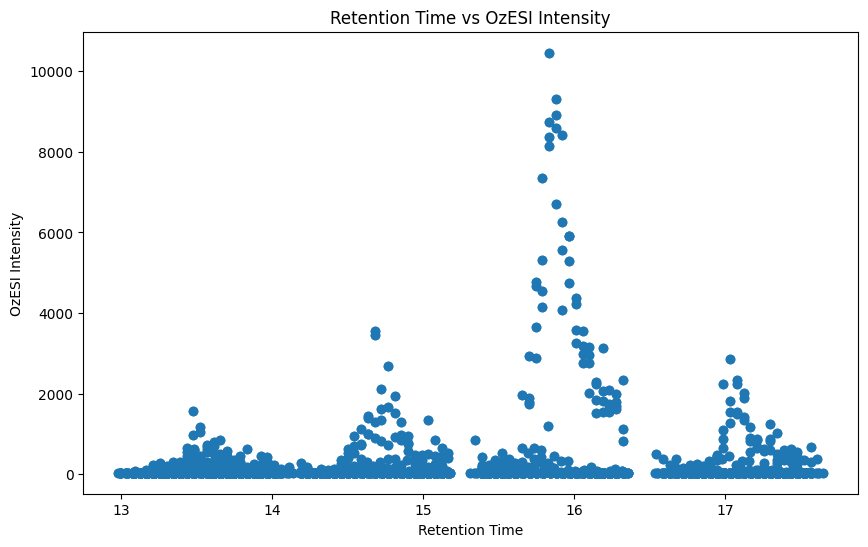

In [304]:
# Assuming clustered_data is your DataFrame with the necessary data

# Plotting the Intensity vs Retention Time
plt.figure(figsize=(10, 6))
plt.scatter(d3['Retention_Time'], d3['OzESI_Intensity'])

# Adding labels and title to the plot
plt.xlabel('Retention Time')
plt.ylabel('OzESI Intensity')
plt.title('Retention Time vs OzESI Intensity')

# Displaying the plot
plt.show()


# Save GMM Results

In [305]:
# save_gmm_results_directory = 'Projects/FaceFats/results/GMM_results/'
# save_gmm_results_name = 'FF_Brain5xFAD_OzON_Truth_GMM_results.csv'
# # d5.to_csv(save_gmm_results_directory + save_gmm_results_name)
# def save_csv_with_increment(df, directory, filename):
#     # Check if the directory exists, if not, create it
#     if not os.path.exists(directory):
#         os.makedirs(directory)
#     base, extension = os.path.splitext(filename)
#     counter = 1
#     new_filename = filename

#     # Check if file exists and increment the counter until an unused filename is found
#     while os.path.isfile(os.path.join(directory, new_filename)):
#         new_filename = f"{base}_{counter}{extension}"
#         counter += 1

#     # Save the dataframe to the new path
#     df.to_csv(os.path.join(directory, new_filename), index=False)
#     print(f"File saved as: {new_filename}")

# # Example usage
# save_csv_with_increment(d5, save_gmm_results_directory, save_gmm_results_name)

In [306]:
d4

Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
2773       774.6        599.5       12.996817        41.760002   
2774       774.6        599.5       13.041233        41.720001   
2775       774.6        599.5       13.085633        41.480003   
2776       774.6        599.5       13.130033        41.760002   
2777       774.6        599.5       13.174450        41.600002   
...          ...          ...             ...              ...   
842        794.7        605.5       17.297817       609.940063   
843        794.7        605.5       17.342217       359.900024   
844        794.7        605.5       17.386633       594.880066   
845        794.7        605.5       17.431033       294.860016   
846        794.7        605.5       17.475433       264.360016   

                                  Sample_ID      Transition  Match_Group  \
2773  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2774  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2775  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2776  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2777  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
...                                     ...             ...          ...   
842   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
843   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
844   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
845   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
846   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   

                           Lipid   Cage Mouse Genotype Biology  Group_Sample  \
2773           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2774           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2775           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2776           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2777           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
...                          ...    ...   ...      ...     ...           ...   
842   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
843   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
844   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
845   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
846   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   

     New_ID    db     FAC                  TG  Group  Cluster_Label  
2773   None  n-10  FA18:1            TG(54:5)      0              1  
2774   None  n-10  FA18:1            TG(54:5)      0              1  
2775   None  n-10  FA18:1            TG(54:5)      0              1  
2776   None  n-10  FA18:1            TG(54:5)      0              1  
2777   None  n-10  FA18:1            TG(54:5)      0              1  
...     ...   ...     ...                 ...    ...            ...  
842    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1  
843    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1  
844    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1  
845    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1  
846    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1  

[3194 rows x 19 columns]

Don't need this anymore? don't need to Find max intensity and remove clusters without db

In [307]:
# d6 = d5.copy()
# d6
# # Group by 'Group' and 'Cluster_Label' and find the maximum 'OzESI_Intensity' for each group
# max_intensity_group = d6.groupby(['Group', 'Cluster_Label'])['OzESI_Intensity'].max().reset_index()

# # Rename the column to 'Max_Intensity2'
# max_intensity_group = max_intensity_group.rename(columns={'OzESI_Intensity': 'Max_Intensity2'})

# # Merge the maximum intensity data back into the original DataFrame
# d6 = d6.merge(max_intensity_group, on=['Group', 'Cluster_Label'])
# d6
# #round max intensity to 0 decimal places
# d6['Max_Intensity2'] = d6['Max_Intensity2'].round(0)
# d6 = d6[d6['db'] != '']
# # Display the DataFrame
# d6

# # Filter the DataFrame based on the specified conditions
# filtered_df = d6[(d6['Lipid'].str.contains('TG\(50:3\)')) & (d6['db'] == 'n-9') & d6['Sample_ID'].str.contains('DOD73')]

# # Print the filtered values
# filtered_df
# # d5



# Find correct RT for OzON dataframe

In [308]:
def Correct_OzON_RT(df):
    """
    Assigns the Retention_Time of the row with the highest OzESI_Intensity
    for each group of Biology, Cage, Genotype, and Lipid as Correct_RT.

    Args:
        df (pandas.DataFrame): The DataFrame to process.

    Returns:
        pandas.DataFrame: The DataFrame with the new Correct_RT column.
    """
    # Group by the specified columns and find the max intensity for each group
    max_intensity_per_group = df.groupby(['Biology', 'Cage', 'Genotype', 'Lipid'])['OzESI_Intensity'].transform('max')

    # Mark the rows with the highest intensity in each group
    is_max_intensity = df['OzESI_Intensity'] == max_intensity_per_group

    # Copy the Retention_Time of the row with the max intensity to Correct_RT
    df['Correct_RT'] = df[is_max_intensity]['Retention_Time'].round(2)

    # Forward fill and backward fill Correct_RT within each group
    df['Correct_RT'] = df.groupby(['Biology', 'Cage', 'Genotype', 'Lipid'])['Correct_RT'].apply(lambda x: x.ffill().bfill())

    return df

# Usage example:
# Assuming your DataFrame is named d3
d5 = Correct_OzON_RT(d4)
d5

Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
2773       774.6        599.5       12.996817        41.760002   
2774       774.6        599.5       13.041233        41.720001   
2775       774.6        599.5       13.085633        41.480003   
2776       774.6        599.5       13.130033        41.760002   
2777       774.6        599.5       13.174450        41.600002   
...          ...          ...             ...              ...   
842        794.7        605.5       17.297817       609.940063   
843        794.7        605.5       17.342217       359.900024   
844        794.7        605.5       17.386633       594.880066   
845        794.7        605.5       17.431033       294.860016   
846        794.7        605.5       17.475433       264.360016   

                                  Sample_ID      Transition  Match_Group  \
2773  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2774  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2775  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2776  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2777  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
...                                     ...             ...          ...   
842   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
843   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
844   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
845   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
846   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   

                           Lipid   Cage Mouse Genotype Biology  Group_Sample  \
2773           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2774           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2775           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2776           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
2777           [TG(54:5)]_FA18:1  DOD93    F4    5xFAD   cereb            -1   
...                          ...    ...   ...      ...     ...           ...   
842   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
843   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
844   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
845   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   
846   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4    5xFAD   hippo            -1   

     New_ID    db     FAC                  TG  Group  Cluster_Label  \
2773   None  n-10  FA18:1            TG(54:5)      0              1   
2774   None  n-10  FA18:1            TG(54:5)      0              1   
2775   None  n-10  FA18:1            TG(54:5)      0              1   
2776   None  n-10  FA18:1            TG(54:5)      0              1   
2777   None  n-10  FA18:1            TG(54:5)      0              1   
...     ...   ...     ...                 ...    ...            ...   
842    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1   
843    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1   
844    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1   
845    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1   
846    None   n-9  FA18:1  TG(54:2), TG(55:9)     63              1   

      Correct_RT  
2773       13.48  
2774       13.48  
2775       13.48  
2776       13.48  
2777       13.48  
...          ...  
842        17.12  
843        17.12  
844        17.12  
845        17.12  
846        17.12  

[3194 rows x 20 columns]

# make max intensity

In [309]:
import pandas as pd

def Correct_OzON_MaxI(df, intensity_threshold):
    """
    For each group of Biology, Cage, Genotype, and Lipid, this function finds the maximum 
    OzESI_Intensity and assigns it to a new column 'Max_Intensity' only if it is above
    a specified threshold.

    Args:
        df (pandas.DataFrame): The DataFrame to process.
        intensity_threshold (float): The threshold for the OzESI_Intensity to be considered.

    Returns:
        pandas.DataFrame: The DataFrame with the new Max_Intensity column.
    """
    # Group by the specified columns and find the max intensity for each group
    max_intensity_per_group = df.groupby(['Biology', 'Cage', 'Genotype', 'Lipid'])['OzESI_Intensity'].transform('max')

    # Filter groups based on the intensity threshold
    df['Max_Intensity'] = max_intensity_per_group
    df.loc[df['Max_Intensity'] < intensity_threshold, 'Max_Intensity'] = pd.NA

    return df

# Usage example:
intensity_threshold = 300  # Define your threshold here
d6 = Correct_OzON_MaxI(d5, intensity_threshold)


# Obtain ground truth difference for each RT cluster by comparing the Max Intensity RT for each cluster to the ground truth. Keep cluster closest to the ground truth. 

In [310]:
d7 = d6.copy()
df_all_clusters = d6.copy()

# def get_ground_truth_diff(row, df_db_pos):
#     # Get the ground truth Retention_Time for the Lipid
#     ground_truth_rt = df_db_pos[df_db_pos['Lipid'] == row['Lipid']]['Retention_Time'].iloc[0]
#     # Calculate the absolute difference
#     return abs(row['Retention_Time'] - ground_truth_rt)

# d7['Ground_Truth_Dif'] = d7.apply(get_ground_truth_diff, args=(df_db_pos,), axis=1)

# Step 1: Define a function to find the peak RT for each cluster
def get_peak_rt(group_df):
    peak_rt_row = group_df.loc[group_df['OzESI_Intensity'].idxmax()]
    return peak_rt_row['Retention_Time']

# Step 2: Group by 'Group' and 'Cluster_Label' to apply the function
cluster_peak_rt = d7.groupby(['Group', 'Cluster_Label']).apply(get_peak_rt)

# Step 3: Merge the peak RT values back into d7
d7 = d7.merge(cluster_peak_rt.rename('Cluster_RT'), on=['Group', 'Cluster_Label'], how='left')

def get_cluster_rt_ground_truth_diff(row, df_db_pos):
    # Get the ground truth Retention_Time for the Lipid
    ground_truth_rt = df_db_pos[df_db_pos['Lipid'] == row['Lipid']]['Retention_Time'].iloc[0]
    # Calculate the absolute difference with Cluster_RT
    return abs(row['Cluster_RT'] - ground_truth_rt)

# Apply this function to each row of d7 to calculate the ground truth difference for Cluster_RT
d7['Cluster_Ground_Truth_Dif'] = d7.apply(get_cluster_rt_ground_truth_diff, args=(df_db_pos,), axis=1)


# Initialize an empty DataFrame to store rows with the lowest Cluster_Ground_Truth_Dif for each group
d7a = pd.DataFrame()

# Group by 'Group' and find the cluster with the lowest Cluster_Ground_Truth_Dif in each group
for group, group_df in d7.groupby('Group'):
    idx_lowest_dif = group_df['Cluster_Ground_Truth_Dif'].idxmin()
    winning_cluster = group_df.loc[idx_lowest_dif, 'Cluster_Label']
    winning_cluster_rows = group_df[group_df['Cluster_Label'] == winning_cluster]
    d7a = d7a.append(winning_cluster_rows)

def filter_groups_by_intensity(df):
    final_df = pd.DataFrame()
    
    # Iterate through each group
    for group, group_df in df.groupby('Group'):
        # Include the group if its max intensity is greater than 300
        if group_df['Max_Intensity'].max() > 400:
            final_df = final_df.append(group_df)

    return final_df

# Example usage:
d7b = filter_groups_by_intensity(d7a)
d7b


    

Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
7          774.6        599.5       13.307667        41.520004   
8          774.6        599.5       13.352067        41.740002   
9          774.6        599.5       13.396483        41.640003   
10         774.6        599.5       13.440883        41.740002   
11         774.6        599.5       13.485300        41.680004   
...          ...          ...             ...              ...   
3181       794.7        605.5       16.942567       492.900024   
3182       794.7        605.5       16.986967      1088.420044   
3183       794.7        605.5       17.031367      1558.220093   
3184       794.7        605.5       17.075783      1540.800049   
3185       794.7        605.5       17.120183      1901.360107   

                                  Sample_ID      Transition  Match_Group  \
7     11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
8     11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
9     11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
10    11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
11    11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
...                                     ...             ...          ...   
3181  11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
3182  11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
3183  11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
3184  11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
3185  11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   

                           Lipid   Cage Mouse  ... New_ID    db     FAC  \
7              [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
8              [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
9              [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
10             [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
11             [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
...                          ...    ...   ...  ...    ...   ...     ...   
3181  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
3182  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
3183  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
3184  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
3185  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   

                      TG Group Cluster_Label Correct_RT  Max_Intensity  \
7               TG(54:5)     0             0      13.48     967.360046   
8               TG(54:5)     0             0      13.48     967.360046   
9               TG(54:5)     0             0      13.48     967.360046   
10              TG(54:5)     0             0      13.48     967.360046   
11              TG(54:5)     0             0      13.48     967.360046   
...                  ...   ...           ...        ...            ...   
3181  TG(54:2), TG(55:9)    63             2      17.12    1901.360107   
3182  TG(54:2), TG(55:9)    63             2      17.12    1901.360107   
3183  TG(54:2), TG(55:9)    63             2      17.12    1901.360107   
3184  TG(54:2), TG(55:9)    63             2      17.12    1901.360107   
3185  TG(54:2), TG(55:9)    63             2      17.12    1901.360107   

      Cluster_RT  Cluster_Ground_Truth_Dif  
7      13.352067                  0.107933  
8      13.352067                  0.107933  
9      13.352067                  0.107933  
10     13.352067                  0.107933  
11     13.352067                  0.107933  
...          ...                       ...  
3181   17.120183                  0.020183  
3182   17.120183                  0.020183  
3183   17.120183                  0.020183  
3184   17.120183                  0.020183  
3185   17.12018

In [311]:
# # # Filter the DataFrame based on the specified conditions
# # filtered_df = d7a[(d7a['Lipid'].str.contains('TG\(50:3\)')) & (d7a['db'] == 'n-9') & d7a['Sample_ID'].str.contains('DOD73')]

# # # Print the filtered values
# # filtered_df
# d7b

In [312]:
d5

Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
2773       774.6        599.5       12.996817        41.760002   
2774       774.6        599.5       13.041233        41.720001   
2775       774.6        599.5       13.085633        41.480003   
2776       774.6        599.5       13.130033        41.760002   
2777       774.6        599.5       13.174450        41.600002   
...          ...          ...             ...              ...   
842        794.7        605.5       17.297817       609.940063   
843        794.7        605.5       17.342217       359.900024   
844        794.7        605.5       17.386633       594.880066   
845        794.7        605.5       17.431033       294.860016   
846        794.7        605.5       17.475433       264.360016   

                                  Sample_ID      Transition  Match_Group  \
2773  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2774  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2775  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2776  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2777  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
...                                     ...             ...          ...   
842   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
843   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
844   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
845   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
846   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   

                           Lipid   Cage Mouse  ... Biology Group_Sample  \
2773           [TG(54:5)]_FA18:1  DOD93    F4  ...   cereb           -1   
2774           [TG(54:5)]_FA18:1  DOD93    F4  ...   cereb           -1   
2775           [TG(54:5)]_FA18:1  DOD93    F4  ...   cereb           -1   
2776           [TG(54:5)]_FA18:1  DOD93    F4  ...   cereb           -1   
2777           [TG(54:5)]_FA18:1  DOD93    F4  ...   cereb           -1   
...                          ...    ...   ...  ...     ...          ...   
842   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   hippo           -1   
843   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   hippo           -1   
844   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   hippo           -1   
845   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   hippo           -1   
846   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   hippo           -1   

      New_ID    db     FAC                  TG Group  Cluster_Label  \
2773    None  n-10  FA18:1            TG(54:5)     0              1   
2774    None  n-10  FA18:1            TG(54:5)     0              1   
2775    None  n-10  FA18:1            TG(54:5)     0              1   
2776    None  n-10  FA18:1            TG(54:5)     0              1   
2777    None  n-10  FA18:1            TG(54:5)     0              1   
...      ...   ...     ...                 ...   ...            ...   
842     None   n-9  FA18:1  TG(54:2), TG(55:9)    63              1   
843     None   n-9  FA18:1  TG(54:2), TG(55:9)    63              1   
844     None   n-9  FA18:1  TG(54:2), TG(55:9)    63              1   
845     None   n-9  FA18:1  TG(54:2), TG(55:9)    63              1   
846     None   n-9  FA18:1  TG(54:2), TG(55:9)    63              1   

      Correct_RT  Max_Intensity  
2773       13.48     967.360046  
2774       13.48     967.360046  
2775       13.48     967.360046  
2776       13.48     967.360046  
2777       13.48     967.360046  
...          ...            ...  
842        17.12    1901.360107  
843        17.12    1901.360107  
844        17.12    1901.360107  
845        17.12    1901.360107  
846        17.12    1901.360107  

[3194 rows x 21 columns]

# Set Peak Boundaries using Peak Width at % of Peak Height

In [313]:
# Assuming d7 is already defined
d8 = d5.copy()

# Define the directory where you want to save the plots
save_directory = 'Projects/FaceFats/plots/peak_check/width/'
os.makedirs(save_directory, exist_ok=True)

# Setting parameters for peak finding
peak_width_fraction = 0.01
peak_width_fraction_large = 0.01
peak_width_intensity_threshold = 2000

# Function to calculate peak boundaries
def calculate_peak_boundaries(intensities, times, peak_max_index):
    peak_max_intensity = intensities[peak_max_index]
    if peak_max_intensity > peak_width_intensity_threshold:
        intensity_threshold = peak_max_intensity * peak_width_fraction_large
    else:
        intensity_threshold = peak_max_intensity * peak_width_fraction

    left_indices = np.where(intensities[:peak_max_index] < intensity_threshold)[0]
    right_indices = np.where(intensities[peak_max_index:] < intensity_threshold)[0] + peak_max_index

    peak_start = times[left_indices[-1]] if len(left_indices) > 0 else times[0]
    peak_end = times[right_indices[0]] if len(right_indices) > 0 else times[-1]

    return peak_start, peak_end

def plot_peak_and_boundaries(group_data, group, cluster_label, save_dir, peak_width_fraction=0.2):
    
    times = group_data['Retention_Time'].values
    intensities = group_data['OzESI_Intensity'].values
    peak_max_index = np.argmax(intensities)
    peak_max_intensity = intensities[peak_max_index]
    peak_start, peak_end = calculate_peak_boundaries(intensities, times, peak_max_index)

    # Extract additional information for the title
    lipid = group_data.iloc[0]['Lipid']
    biology = group_data.iloc[0]['Biology']
    genotype = group_data.iloc[0]['Genotype']
    db = group_data.iloc[0]['db']
    sample_id = group_data.iloc[0]['Sample_ID']

    # # Plotting
    # plt.figure(figsize=(10, 6))
    # plt.plot(times, intensities, label='Intensity')
    # plt.scatter(times[peak_max_index], intensities[peak_max_index], color='red', label='Peak', zorder=5)
    # if peak_max_intensity > peak_width_intensity_threshold:
    #     plt.axvline(peak_start, color='green', linestyle='--', label=f'Peak Start (Width at {peak_width_fraction_large*100:.0f}%)')
    #     plt.axvline(peak_end, color='blue', linestyle='--', label=f'Peak End (Width at {peak_width_fraction_large*100:.0f}%)')
    # else:
    #     plt.axvline(peak_start, color='green', linestyle='--', label=f'Peak Start (Width at {peak_width_fraction*100:.0f}%)')
    #     plt.axvline(peak_end, color='blue', linestyle='--', label=f'Peak End (Width at {peak_width_fraction*100:.0f}%)')
    # plt.xlabel('Retention Time')
    # plt.ylabel('OzESI Intensity')
    # plt.title(f'{group}, {cluster_label}, {lipid}, {biology}, {genotype}, {sample_id}, {db}')
    # plt.legend()

    # filename = f'{group}, {cluster_label}, {lipid}, {biology}, {genotype}, {sample_id}, {db}.png'
    # # plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
    # # plt.show()
    # plt.close()

# Iterating over groups and clusters and plotting peaks
for (group, cluster_label), group_df in d8.groupby(['Group', 'Cluster_Label']):
    group_df_sorted = group_df.sort_values(by='Retention_Time')
    peak_max_index = np.argmax(group_df_sorted['OzESI_Intensity'].values)
    peak_start, peak_end = calculate_peak_boundaries(group_df_sorted['OzESI_Intensity'].values, 
                                                     group_df_sorted['Retention_Time'].values, 
                                                     peak_max_index)

    # Update d8 with peak boundaries
    d8.loc[(d8['Group'] == group) & (d8['Cluster_Label'] == cluster_label), 'RT_Start'] = peak_start.round(2)
    d8.loc[(d8['Group'] == group) & (d8['Cluster_Label'] == cluster_label), 'RT_End'] = peak_end.round(2)

    # Plot and save peak analysis with the correct peak_width_fraction
    plot_peak_and_boundaries(group_df_sorted, group, cluster_label, save_directory, peak_width_fraction)

# Now the plots will use the peak_width_fraction of 0.22 as intended

# Display the updated DataFrame
d8




Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
2773       774.6        599.5       12.996817        41.760002   
2774       774.6        599.5       13.041233        41.720001   
2775       774.6        599.5       13.085633        41.480003   
2776       774.6        599.5       13.130033        41.760002   
2777       774.6        599.5       13.174450        41.600002   
...          ...          ...             ...              ...   
842        794.7        605.5       17.297817       609.940063   
843        794.7        605.5       17.342217       359.900024   
844        794.7        605.5       17.386633       594.880066   
845        794.7        605.5       17.431033       294.860016   
846        794.7        605.5       17.475433       264.360016   

                                  Sample_ID      Transition  Match_Group  \
2773  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2774  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2775  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2776  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2777  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
...                                     ...             ...          ...   
842   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
843   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
844   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
845   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
846   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   

                           Lipid   Cage Mouse  ... New_ID    db     FAC  \
2773           [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
2774           [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
2775           [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
2776           [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
2777           [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
...                          ...    ...   ...  ...    ...   ...     ...   
842   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
843   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
844   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
845   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
846   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   

                      TG Group Cluster_Label Correct_RT  Max_Intensity  \
2773            TG(54:5)     0             1      13.48     967.360046   
2774            TG(54:5)     0             1      13.48     967.360046   
2775            TG(54:5)     0             1      13.48     967.360046   
2776            TG(54:5)     0             1      13.48     967.360046   
2777            TG(54:5)     0             1      13.48     967.360046   
...                  ...   ...           ...        ...            ...   
842   TG(54:2), TG(55:9)    63             1      17.12    1901.360107   
843   TG(54:2), TG(55:9)    63             1      17.12    1901.360107   
844   TG(54:2), TG(55:9)    63             1      17.12    1901.360107   
845   TG(54:2), TG(55:9)    63             1      17.12    1901.360107   
846   TG(54:2), TG(55:9)    63             1      17.12    1901.360107   

      RT_Start  RT_End  
2773     13.00   13.26  
2774     13.00   13.26  
2775     13.00   13.26  
2776     13.00   13.26  
2777     13.00   13.26  
...        ...     ...  
842      17.16   17.48  
843      17.16   17.48  
844      17.16   17.48  
845      17.16   17.48  
846      17.16   17.48  

[3194 rows x 23 columns]

# Adjust new RTs based off peak width % calc

In [314]:
d9 = d8.copy()
d9
# Initialize an empty DataFrame to store the filtered results
filtered_d9 = pd.DataFrame()

# Iterate over each group-cluster pair
for (group, cluster_label), group_df in d9.groupby(['Group', 'Cluster_Label']):
    # Get the RT_Start and RT_End values for the current group-cluster pair
    rt_start = group_df['RT_Start'].iloc[0]
    rt_end = group_df['RT_End'].iloc[0]

    # Filter the DataFrame for rows where Retention_Time is within the start and end window
    within_window = group_df[(group_df['Retention_Time'] >= rt_start) & (group_df['Retention_Time'] <= rt_end)]

    # Append the filtered data to the results DataFrame
    filtered_d9 = pd.concat([filtered_d9, within_window])

# Assign the filtered DataFrame back to d9
d9 = filtered_d9

# Display the filtered DataFrame
d9


Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
2781       774.6        599.5       13.352067        41.740002   
2782       774.6        599.5       13.396483        41.640003   
2783       774.6        599.5       13.440883        41.740002   
2784       774.6        599.5       13.485300        41.680004   
2785       774.6        599.5       13.529700        41.720001   
...          ...          ...             ...              ...   
833        794.7        605.5       16.898150       252.080017   
834        794.7        605.5       16.942567       492.900024   
835        794.7        605.5       16.986967      1088.420044   
836        794.7        605.5       17.031367      1558.220093   
837        794.7        605.5       17.075783      1540.800049   

                                  Sample_ID      Transition  Match_Group  \
2781  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2782  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2783  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2784  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2785  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
...                                     ...             ...          ...   
833   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
834   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
835   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
836   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
837   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   

                           Lipid   Cage Mouse  ... New_ID    db     FAC  \
2781           [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
2782           [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
2783           [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
2784           [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
2785           [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
...                          ...    ...   ...  ...    ...   ...     ...   
833   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
834   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
835   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
836   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
837   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   

                      TG Group Cluster_Label Correct_RT  Max_Intensity  \
2781            TG(54:5)     0             0      13.48     967.360046   
2782            TG(54:5)     0             0      13.48     967.360046   
2783            TG(54:5)     0             0      13.48     967.360046   
2784            TG(54:5)     0             0      13.48     967.360046   
2785            TG(54:5)     0             0      13.48     967.360046   
...                  ...   ...           ...        ...            ...   
833   TG(54:2), TG(55:9)    63             2      17.12    1901.360107   
834   TG(54:2), TG(55:9)    63             2      17.12    1901.360107   
835   TG(54:2), TG(55:9)    63             2      17.12    1901.360107   
836   TG(54:2), TG(55:9)    63             2      17.12    1901.360107   
837   TG(54:2), TG(55:9)    63             2      17.12    1901.360107   

      RT_Start  RT_End  
2781     13.31   13.62  
2782     13.31   13.62  
2783     13.31   13.62  
2784     13.31   13.62  
2785     13.31   13.62  
...        ...     ...  
833      16.85   17.12  
834      16.85   17.12  
835      16.85   17.12  
836      16.85   17.12  
837      16.85   17.12  

[2810 rows x 23 columns]

# Dont need? Add Clusters back for a specific group because GMM did not Cluster Properly

In [315]:
# def add_clusters(d9, df_all_clusters, groups):
#     # Iterate over the list of group numbers
#     for group in groups:
#         # Filter df_all_clusters for the current group
#         group_data = df_all_clusters[df_all_clusters['Group'] == group]

#         # Append the data from the current group back to d9
#         d9 = pd.concat([d9, group_data])

#     return d9

# def merge_clusters(df, groups):
#     # Initialize an empty DataFrame for updated groups
#     updated_groups_df = pd.DataFrame()

#     # Iterate over the list of group numbers
#     for group in groups:
#         # Filter the DataFrame for the current group
#         group_data = df[df['Group'] == group]

#         # Change all Cluster_Labels in the group to '4'
#         group_data['Cluster_Label'] = 4

#         # Sort the group data by Retention_Time
#         group_data = group_data.sort_values(by='Retention_Time')

#         # Set the new min and max Retention_Time as RT_Start and RT_End
#         if not group_data.empty:
#             rt_start = group_data['Retention_Time'].min()
#             rt_end = group_data['Retention_Time'].max()
#             group_data['RT_Start'] = rt_start
#             group_data['RT_End'] = rt_end

#         # Append updated group data to the temporary DataFrame
#         updated_groups_df = pd.concat([updated_groups_df, group_data])

#     # Update the original DataFrame: Remove the old groups data
#     df_updated = df[~df['Group'].isin(groups)]

#     # Append the updated groups data to the original DataFrame
#     df_updated = pd.concat([df_updated, updated_groups_df])

#     return df_updated

# # Example usage
# groups_to_add = adjusted_list # Replace with the desired list of group numbers
# d9 = add_clusters(d9, df_all_clusters, groups_to_add)
# d9 = merge_clusters(d9, groups_to_add)


# Manually adjust RTs

In [316]:

def Peak_Adjust(d9, adjust_specs):
    adjusted_df = d9.copy()

    for spec in adjust_specs:
        group = spec['group']
        start_left = spec.get('start_left', None)
        start_right = spec.get('start_right', None)

        group_mask = adjusted_df['Group'] == group

        if not adjusted_df[group_mask].empty:
            if start_left == 999:
                start_left = adjusted_df[group_mask]['RT_Start'].iloc[0]
            if start_right == 999:
                start_right = adjusted_df[group_mask]['RT_End'].iloc[0]

            for cluster_label in adjusted_df[group_mask]['Cluster_Label'].unique():
                mask = group_mask & (adjusted_df['Cluster_Label'] == cluster_label)

                adjusted_df.loc[mask, 'RT_Start'] = start_left
                adjusted_df.loc[mask, 'RT_End'] = start_right

                if start_left is not None:
                    adjusted_df.loc[mask, 'Retention_Time'] = adjusted_df.loc[mask, 'Retention_Time'].clip(lower=start_left)
                if start_right is not None:
                    adjusted_df.loc[mask, 'Retention_Time'] = adjusted_df.loc[mask, 'Retention_Time'].clip(upper=start_right)

    return adjusted_df


# Define the Peak Retention Time Adjustments for each Group
adjust_specs = [
    #50:3
{'group': 54, 'start_left': 999, 'start_right': 999},
#    #52:5
#     {'group': 172, 'start_left': 999, 'start_right': 12.5},
#     {'group': 166, 'start_left': 12.1, 'start_right': 12.55},
#     {'group': 164, 'start_left': 12.1, 'start_right': 12.55},
#     {'group': 159, 'start_left': 12.0, 'start_right': 12.4},
#     {'group': 158, 'start_left': 12.1, 'start_right': 12.55},
#     {'group': 156, 'start_left': 12.1, 'start_right': 12.55},
#     {'group': 154, 'start_left': 12.0, 'start_right': 12.6},
#     {'group': 152, 'start_left': 12.1, 'start_right': 12.5},      
#     {'group': 151, 'start_left': 12.1, 'start_right': 12.45}, 
#     {'group': 149, 'start_left': 999, 'start_right': 12.4}, 
#     {'group': 148, 'start_left': 12.1, 'start_right': 12.5},
#     {'group': 147, 'start_left': 999, 'start_right': 12.45}, 
#     {'group': 146, 'start_left': 12.1, 'start_right': 12.45}, 
#     {'group': 145, 'start_left': 12.1, 'start_right': 12.45},
#     {'group': 144, 'start_left': 12.1, 'start_right': 12.45},  
#     #50:3
#     {'group': 3, 'start_left': 13.4, 'start_right': 13.8}, 
#     {'group': 58, 'start_left': 13.2, 'start_right': 13.65}, 
#     {'group': 73, 'start_left': 13.2, 'start_right': 13.9}, 
#     {'group': 74, 'start_left': 13.4, 'start_right': 13.8}, 
#     {'group': 75, 'start_left': 999, 'start_right': 13.7}, 
#     {'group': 76, 'start_left': 13.4, 'start_right': 13.9}, 
#     {'group': 77, 'start_left': 999, 'start_right': 13.8}, 
#     {'group': 78, 'start_left': 13.2, 'start_right': 13.9},
#     {'group': 79, 'start_left': 13.4, 'start_right': 13.8}, 
#     {'group': 82, 'start_left': 13.2, 'start_right': 13.9},
#     {'group': 84, 'start_left': 13.2, 'start_right': 13.9},
#     {'group': 85, 'start_left': 13.2, 'start_right': 13.9},
#     {'group': 86, 'start_left': 13.4, 'start_right': 13.8},
#     {'group': 87, 'start_left': 999, 'start_right': 13.6},
#     {'group': 88, 'start_left': 13.4, 'start_right': 13.8},
#     {'group': 89, 'start_left': 13.2, 'start_right': 14.0},
#     {'group': 90, 'start_left': 13.55, 'start_right': 13.9},
#     {'group': 94, 'start_left': 13.55, 'start_right': 13.9},
#     #54:1
#     {'group': 747, 'start_left': 16.7, 'start_right': 17.2}, 
#     #54:2
#     {'group': 842, 'start_left': 16.8, 'start_right': 17.25}, 
#     {'group': 840, 'start_left': 16.8, 'start_right': 17.35},
#     {'group': 841, 'start_left': 16.8, 'start_right': 17.35},
#     {'group': 844, 'start_left': 16.8, 'start_right': 17.35},
#     {'group': 846, 'start_left': 16.8, 'start_right': 17.35},
#     {'group': 847, 'start_left': 16.8, 'start_right': 17.35},
#     {'group': 848, 'start_left': 16.8, 'start_right': 17.35},
#     {'group': 851, 'start_left': 999, 'start_right': 17.1},
#     {'group': 858, 'start_left': 16.8, 'start_right': 17.35},
#     {'group': 859, 'start_left': 16.8, 'start_right': 17.35},
#     {'group': 860, 'start_left': 16.8, 'start_right': 17.35},
#     {'group': 862, 'start_left': 16.8, 'start_right': 17.35},
#     {'group': 863, 'start_left': 16.8, 'start_right': 17.35},
# #54:3
#     {'group': 534, 'start_left': 15.4, 'start_right': 16.0},
#     {'group': 552, 'start_left': 15.4, 'start_right': 16.2},
#     {'group': 553, 'start_left': 999, 'start_right': 16.2},
#     {'group': 554, 'start_left': 15.4, 'start_right': 16.2},
#     {'group': 558, 'start_left': 15.4, 'start_right': 16.25},
#     {'group': 560, 'start_left': 15.4, 'start_right': 16.25},
#     {'group': 563, 'start_left': 15.4, 'start_right': 16.25},
#     {'group': 564, 'start_left': 15.4, 'start_right': 16.25},
#     {'group': 565, 'start_left': 15.4, 'start_right': 16.25},
#     {'group': 566, 'start_left': 15.4, 'start_right': 16.25},
#     {'group': 568, 'start_left': 15.4, 'start_right': 16.25},
#     {'group': 570, 'start_left': 15.4, 'start_right': 16.25},
#     {'group': 571, 'start_left': 15.4, 'start_right': 16.25},
#     {'group': 572, 'start_left': 15.4, 'start_right': 16.25},
#     {'group': 574, 'start_left': 15.4, 'start_right': 16.25},
#     {'group': 575, 'start_left': 15.4, 'start_right': 16.25},
# #54:4
#     {'group': 631, 'start_left': 14.2, 'start_right': 14.9},
#     {'group': 632, 'start_left': 14.2, 'start_right': 14.9},
#     {'group': 640, 'start_left': 14.2, 'start_right': 14.9},
#     {'group': 648, 'start_left': 14.2, 'start_right': 14.9},
#     {'group': 667, 'start_left': 14.2, 'start_right': 14.9},
#     {'group': 668, 'start_left': 14.2, 'start_right': 14.9},
#     {'group': 670, 'start_left': 14.2, 'start_right': 14.9},
#     {'group': 671, 'start_left': 14.8, 'start_right': 15.1},
# #54:5
#     {'group': 352, 'start_left': 13.3, 'start_right': 13.7},
#     {'group': 360, 'start_left': 13.3, 'start_right': 13.7},
#     {'group': 361, 'start_left': 13.3, 'start_right': 13.7},
#     {'group': 362, 'start_left': 13.3, 'start_right': 13.7},
#     {'group': 366, 'start_left': 13.3, 'start_right': 13.7},
#     {'group': 367, 'start_left': 13.3, 'start_right': 13.7},
#     {'group': 382, 'start_left': 13.3, 'start_right': 13.7},
# #54:6
#     {'group': 456, 'start_left': 12.3, 'start_right': 12.6},
# #54:7
#     {'group': 1226, 'start_left': 17.8, 'start_right': 18.35},

]

d9 = Peak_Adjust(d9, adjust_specs)

def adjust_spec_list(specs):
    group_list = []
    for spec in specs:
        group_list.append(spec['group'])
    return group_list

# Example usage
adjusted_list = adjust_spec_list(adjust_specs)
adjusted_list


# Display a portion of the adjusted DataFrame
d9



Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
2781       774.6        599.5       13.352067        41.740002   
2782       774.6        599.5       13.396483        41.640003   
2783       774.6        599.5       13.440883        41.740002   
2784       774.6        599.5       13.485300        41.680004   
2785       774.6        599.5       13.529700        41.720001   
...          ...          ...             ...              ...   
833        794.7        605.5       16.898150       252.080017   
834        794.7        605.5       16.942567       492.900024   
835        794.7        605.5       16.986967      1088.420044   
836        794.7        605.5       17.031367      1558.220093   
837        794.7        605.5       17.075783      1540.800049   

                                  Sample_ID      Transition  Match_Group  \
2781  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2782  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2783  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2784  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
2785  11292023_DOD93_F4_5xFAD_cereb_O3on_01  774.6 -> 599.5          184   
...                                     ...             ...          ...   
833   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
834   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
835   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
836   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   
837   11292023_DOD93_F4_5xFAD_hippo_O3on_01  794.7 -> 605.5          271   

                           Lipid   Cage Mouse  ... New_ID    db     FAC  \
2781           [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
2782           [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
2783           [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
2784           [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
2785           [TG(54:5)]_FA18:1  DOD93    F4  ...   None  n-10  FA18:1   
...                          ...    ...   ...  ...    ...   ...     ...   
833   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
834   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
835   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
836   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
837   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   

                      TG Group Cluster_Label Correct_RT  Max_Intensity  \
2781            TG(54:5)     0             0      13.48     967.360046   
2782            TG(54:5)     0             0      13.48     967.360046   
2783            TG(54:5)     0             0      13.48     967.360046   
2784            TG(54:5)     0             0      13.48     967.360046   
2785            TG(54:5)     0             0      13.48     967.360046   
...                  ...   ...           ...        ...            ...   
833   TG(54:2), TG(55:9)    63             2      17.12    1901.360107   
834   TG(54:2), TG(55:9)    63             2      17.12    1901.360107   
835   TG(54:2), TG(55:9)    63             2      17.12    1901.360107   
836   TG(54:2), TG(55:9)    63             2      17.12    1901.360107   
837   TG(54:2), TG(55:9)    63             2      17.12    1901.360107   

      RT_Start  RT_End  
2781     13.31   13.62  
2782     13.31   13.62  
2783     13.31   13.62  
2784     13.31   13.62  
2785     13.31   13.62  
...        ...     ...  
833      16.85   17.12  
834      16.85   17.12  
835      16.85   17.12  
836      16.85   17.12  
837      16.85   17.12  

[2810 rows x 23 columns]

In [317]:
def add_clusters(d9, df_all_clusters, groups):
    # Iterate over the list of group numbers
    for group in groups:
        # Filter df_all_clusters for the current group
        group_data = df_all_clusters[df_all_clusters['Group'] == group]

        # Append the data from the current group back to d9
        d9 = pd.concat([d9, group_data])

    return d9

def merge_clusters(df, groups):
    # Initialize an empty DataFrame for updated groups
    updated_groups_df = pd.DataFrame()

    # Iterate over the list of group numbers
    for group in groups:
        # Filter the DataFrame for the current group
        group_data = df[df['Group'] == group]

        # Change all Cluster_Labels in the group to '4'
        group_data['Cluster_Label'] = 4

        # Sort the group data by Retention_Time
        group_data = group_data.sort_values(by='Retention_Time')

        # Set the new min and max Retention_Time as RT_Start and RT_End
        if not group_data.empty:
            rt_start = group_data['Retention_Time'].min()
            rt_end = group_data['Retention_Time'].max()
            group_data['RT_Start'] = rt_start
            group_data['RT_End'] = rt_end

        # Append updated group data to the temporary DataFrame
        updated_groups_df = pd.concat([updated_groups_df, group_data])

    # Update the original DataFrame: Remove the old groups data
    df_updated = df[~df['Group'].isin(groups)]

    # Append the updated groups data to the original DataFrame
    df_updated = pd.concat([df_updated, updated_groups_df])

    return df_updated

# Example usage
groups_to_add = adjusted_list # Replace with the desired list of group numbers
# add all clusters and merge together
d9 = add_clusters(d9, df_all_clusters, groups_to_add)
d9 = merge_clusters(d9, groups_to_add)
#adjust peak RT
d9 = Peak_Adjust(d9, adjust_specs)


/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Filter d9 df based on manually selected RT_Start and RT_End

In [318]:
d10 = d9.copy()  # Creating d10 DataFrame from the newly filtered d9

# Initialize an empty DataFrame to store the filtered results
filtered_d10 = pd.DataFrame()

# Iterate over each group-cluster pair
for (group, cluster_label), group_df in d10.groupby(['Group', 'Cluster_Label']):
    # Get the RT_Start and RT_End values for the current group-cluster pair
    rt_start = group_df['RT_Start'].iloc[0]
    rt_end = group_df['RT_End'].iloc[0]

    # Filter the DataFrame for rows where Retention_Time is within the start and end window
    within_window = group_df[(group_df['Retention_Time'] >= rt_start) & (group_df['Retention_Time'] <= rt_end)]

    # Append the filtered data to the results DataFrame
    filtered_d10 = pd.concat([filtered_d10, within_window])

# Assign the filtered DataFrame back to d10
d10 = filtered_d10
# Sort d10 DataFrame by 'Retention_Time'
d10= d10.sort_values(by='Retention_Time')

# Display the filtered DataFrame
d10


Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
2839       816.7        599.5       12.983900        41.640003   
3062       816.7        599.5       12.983900        41.640003   
2795       788.7        599.5       12.992167        41.660004   
3018       788.7        599.5       12.992167        41.660004   
3040       788.7        599.5       12.992417        41.540005   
...          ...          ...             ...              ...   
21         752.6        605.5       17.575750        41.780003   
309        822.7        605.5       17.600450        41.560001   
421        822.7        605.5       17.600450        41.560001   
287        794.7        605.5       17.608667       384.960022   
399        794.7        605.5       17.608667       384.960022   

                                   Sample_ID      Transition  Match_Group  \
2839   11292023_DOD93_F4_5xFAD_cereb_O3on_01  816.7 -> 599.5          348   
3062   11292023_DOD93_F4_5xFAD_cereb_O3on_01  816.7 -> 599.5          348   
2795   11292023_DOD93_F4_5xFAD_cereb_O3on_01  788.7 -> 599.5          244   
3018   11292023_DOD93_F4_5xFAD_cereb_O3on_01  788.7 -> 599.5          244   
3040   11292023_DOD93_F4_5xFAD_cereb_O3on_01  788.7 -> 599.5          244   
...                                      ...             ...          ...   
21     11292023_DOD93_F4_5xFAD_cereb_O3on_01  752.6 -> 605.5          120   
309   11292023_DOD93_F4_5xFAD_cortex_O3on_01  822.7 -> 605.5          373   
421   11292023_DOD93_F4_5xFAD_cortex_O3on_01  822.7 -> 605.5          373   
287   11292023_DOD93_F4_5xFAD_cortex_O3on_01  794.7 -> 605.5          269   
399   11292023_DOD93_F4_5xFAD_cortex_O3on_01  794.7 -> 605.5          269   

                           Lipid   Cage Mouse  ... New_ID    db     FAC  \
2839           [TG(54:5)]_FA18:1  DOD93    F4  ...   None   n-7  FA18:1   
3062           [TG(54:5)]_FA18:1  DOD93    F4  ...   None   n-7  FA18:1   
2795           [TG(54:5)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
3018           [TG(54:5)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
3040           [TG(54:5)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
...                          ...    ...   ...  ...    ...   ...     ...   
21    [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None  n-12  FA18:1   
309   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-7  FA18:1   
421   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-7  FA18:1   
287   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   
399   [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...   None   n-9  FA18:1   

                      TG Group Cluster_Label Correct_RT  Max_Intensity  \
2839            TG(54:5)     8             1      13.48     967.360046   
3062            TG(54:5)     8             1      13.48     967.360046   
2795            TG(54:5)    12             1      13.48     967.360046   
3018            TG(54:5)    12             1      13.48     967.360046   
3040            TG(54:5)    12             1      13.48     967.360046   
...                  ...   ...           ...        ...            ...   
21    TG(54:2), TG(55:9)    52             0      17.08    2328.940186   
309   TG(54:2), TG(55:9)    57             0      17.12    2026.900146   
421   TG(54:2), TG(55:9)    57             0      17.12    2026.900146   
287   TG(54:2), TG(55:9)    61             2      17.12    2026.900146   
399   TG(54:2), TG(55:9)    61             2      17.12    2026.900146   

      RT_Start  RT_End  
2839     12.98   13.29  
3062     12.98   13.29  
2795     12.99   13.30  
3018     12.99   13.30  
3040     12.99   13.30  
...        ...     ...  
21       17.35   17.58  
309      17.38   17.64  
421      17.38   17.64  
287      17.34   17.61  
399      17.34   17.61  

[2854 rows x 23 columns]

# Plot the manually adjusted RTs to confirm peaks are correct

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.08


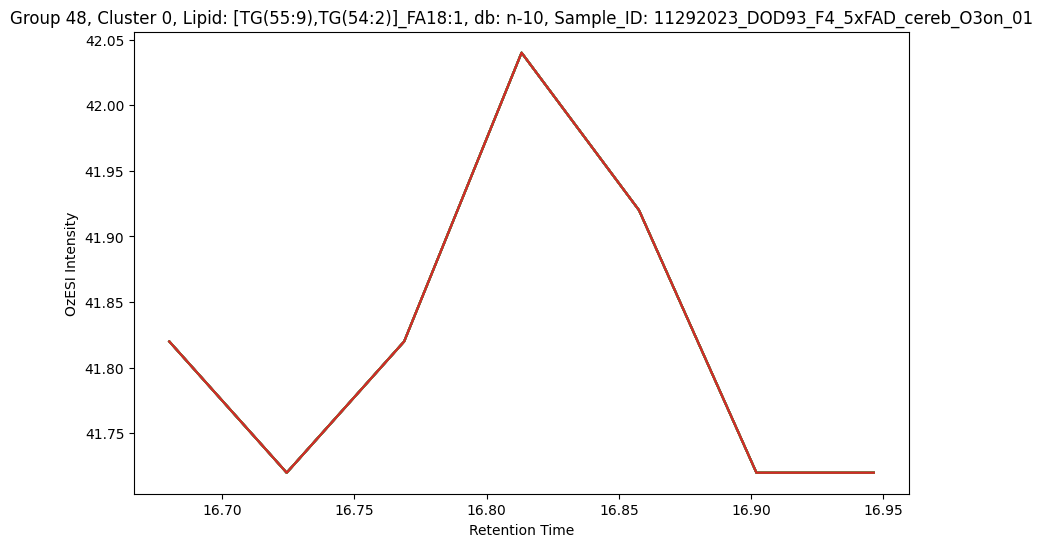

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.08


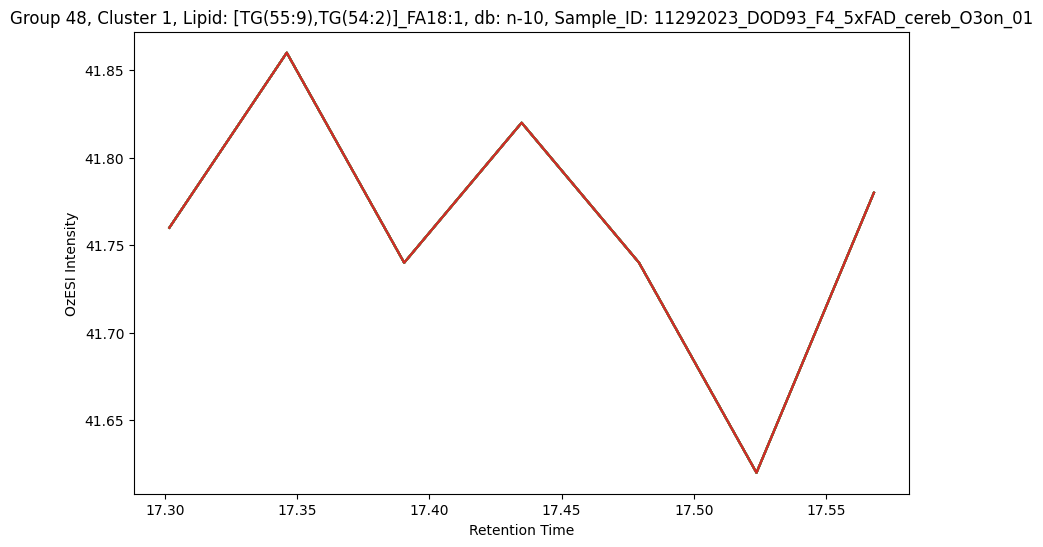

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.08


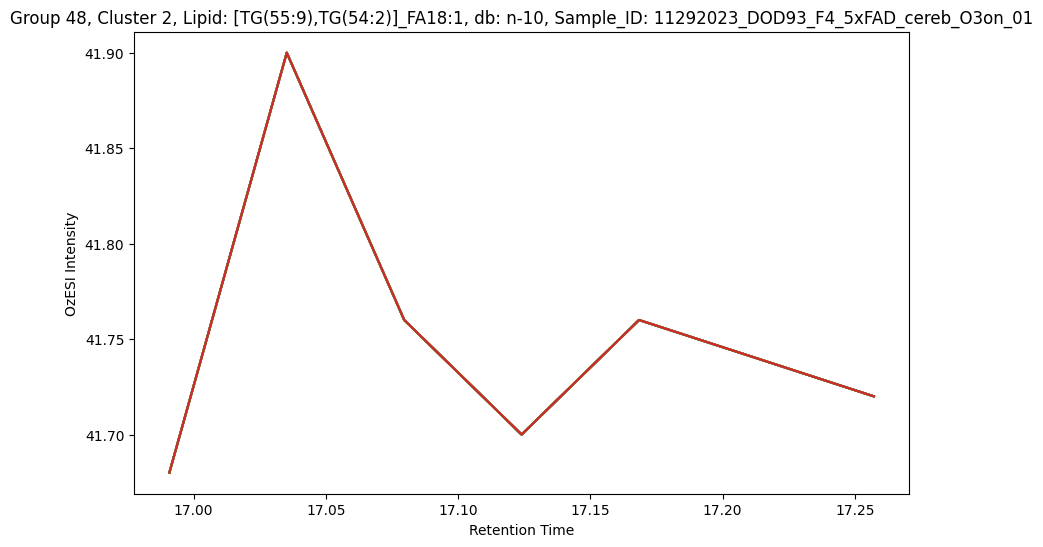

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


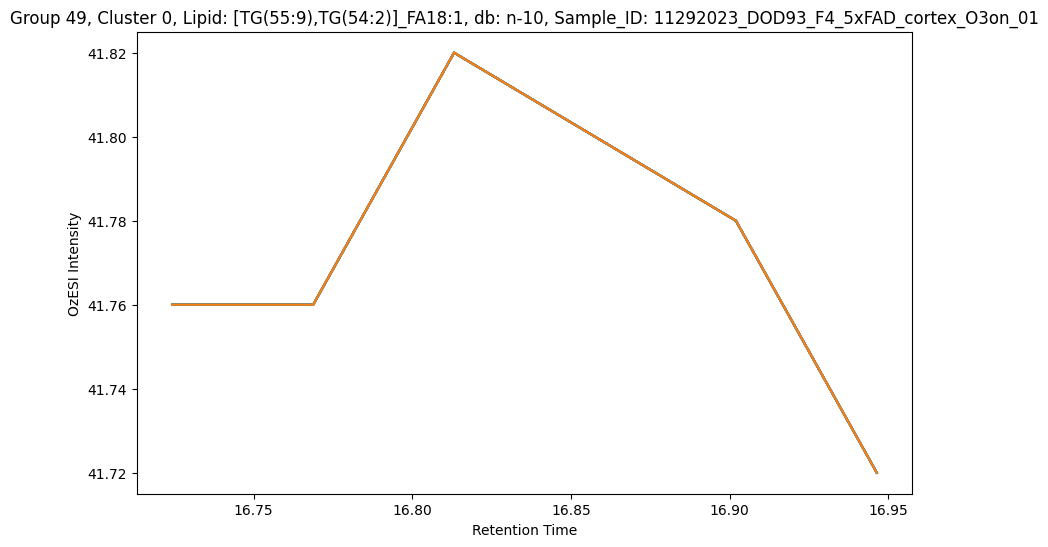

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


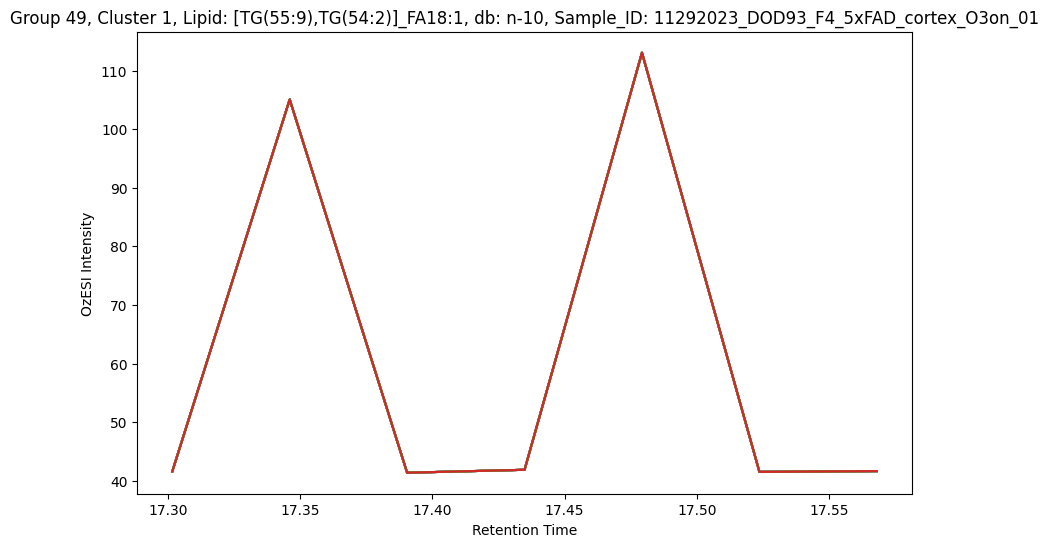

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


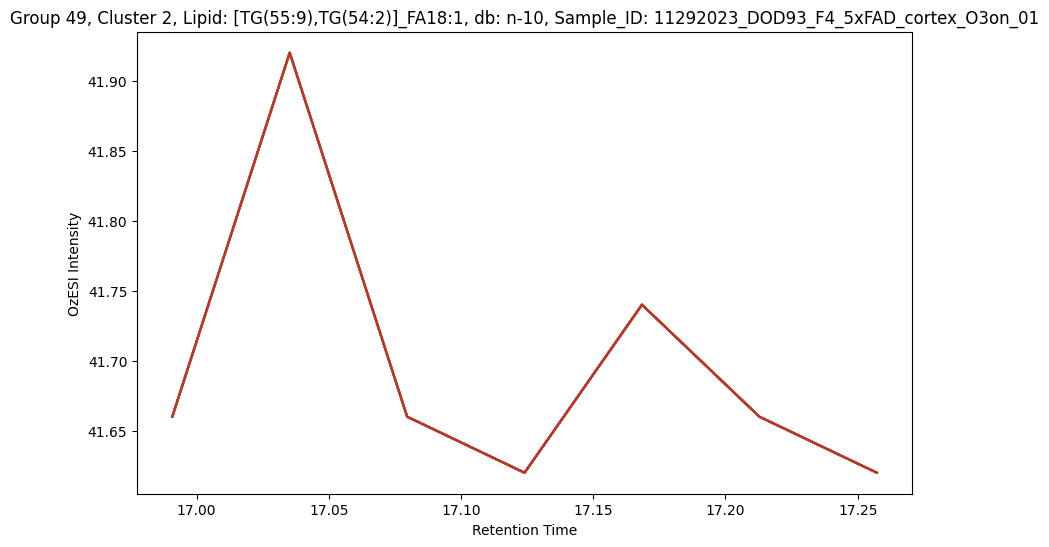

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.03


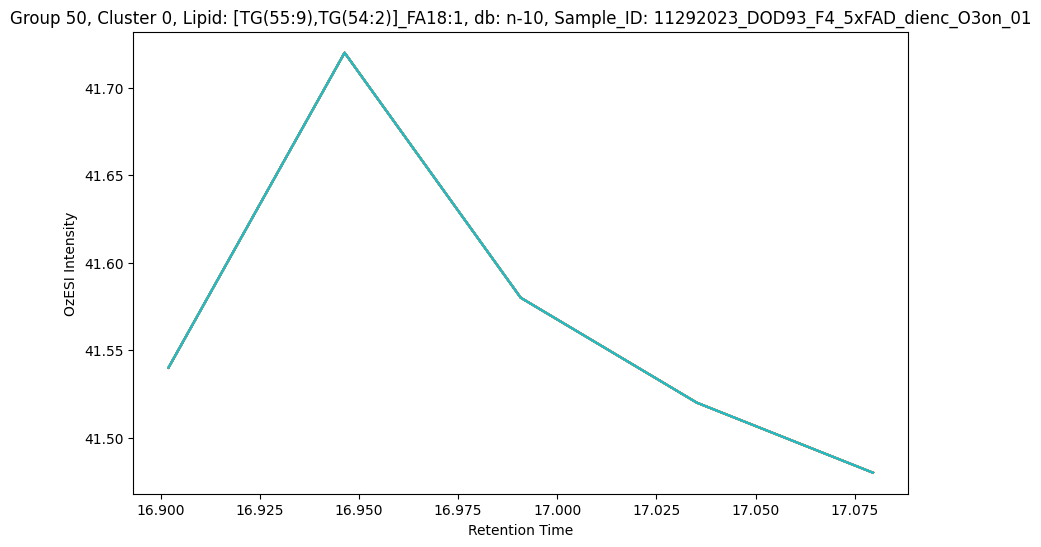

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.03


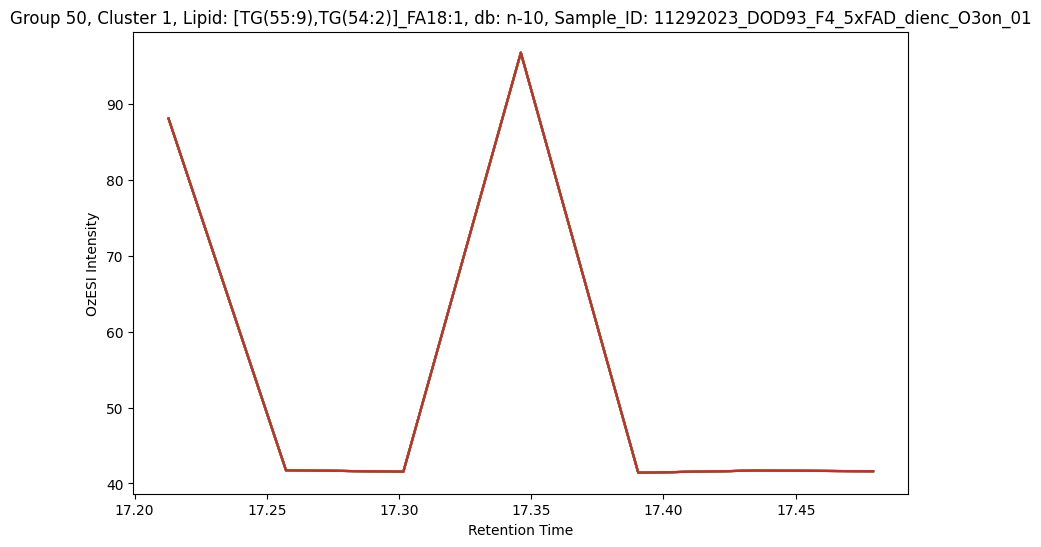

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.03


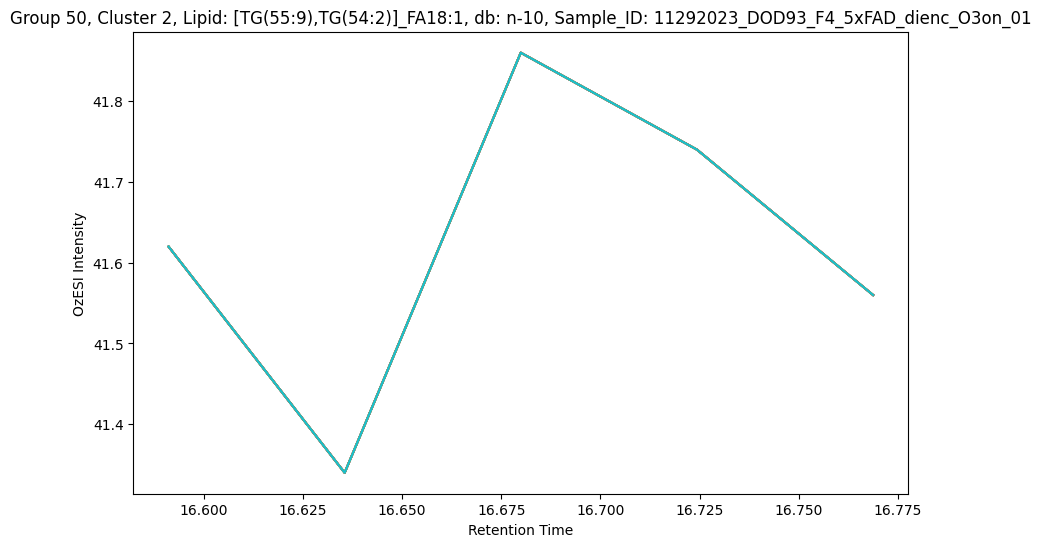

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


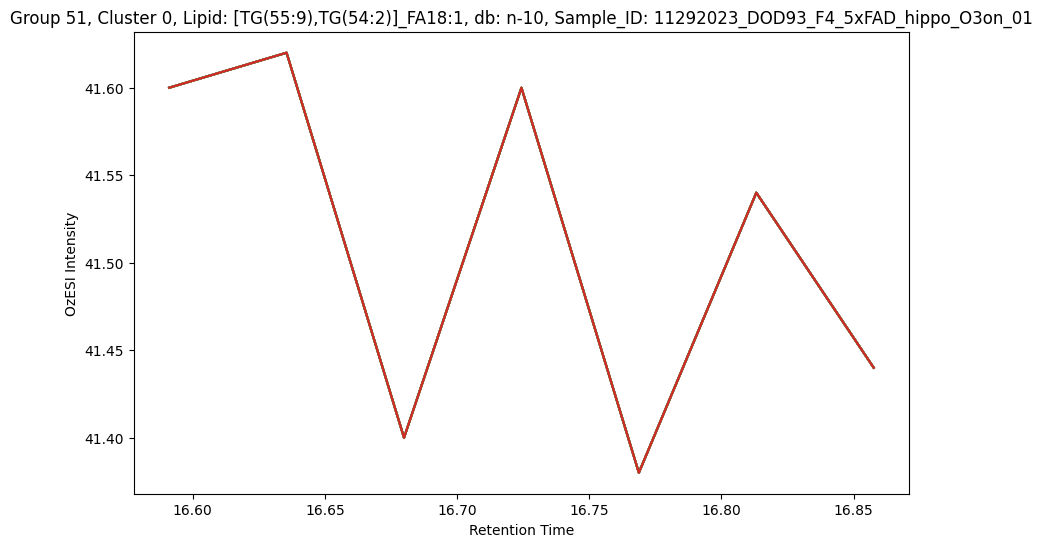

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


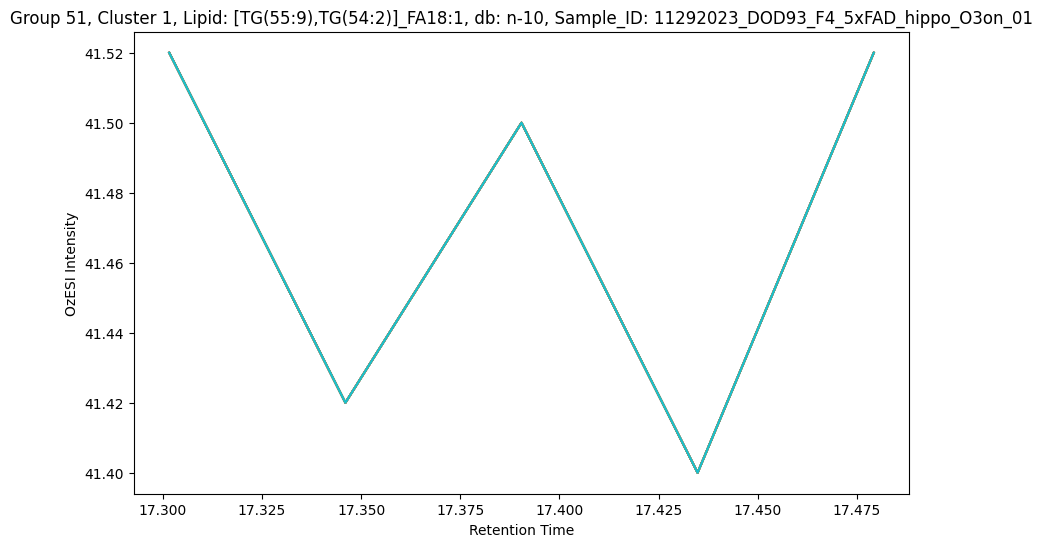

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


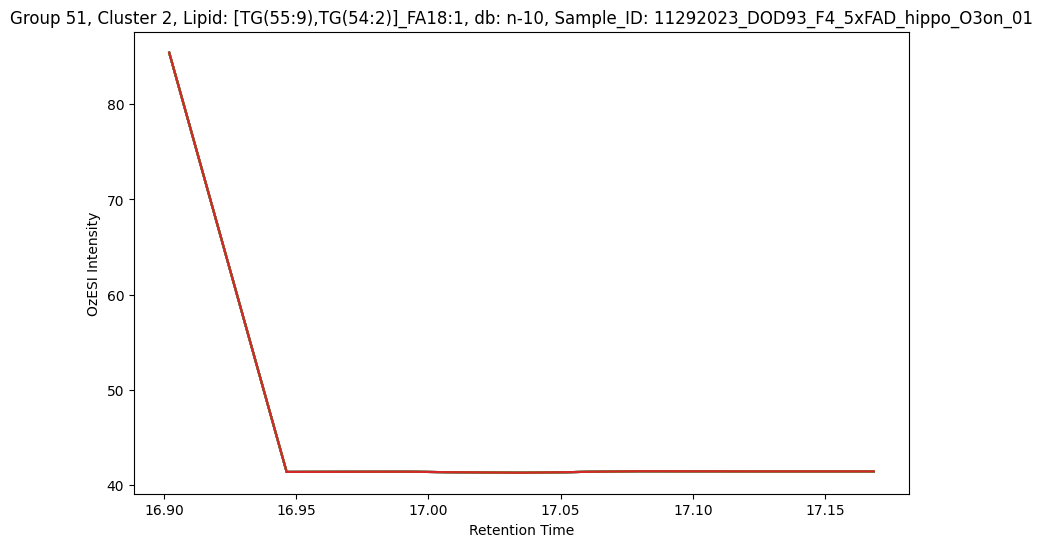

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.08


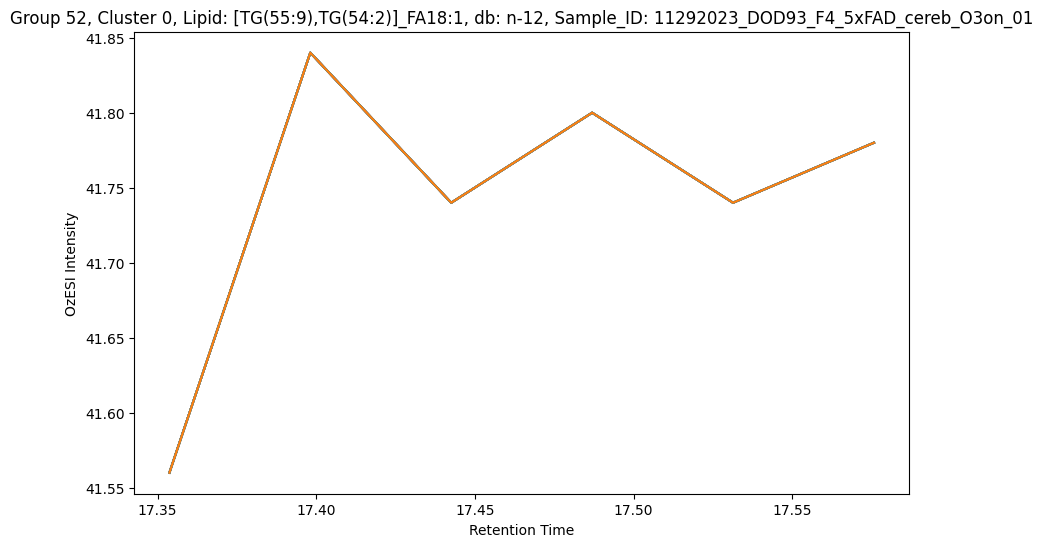

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.08


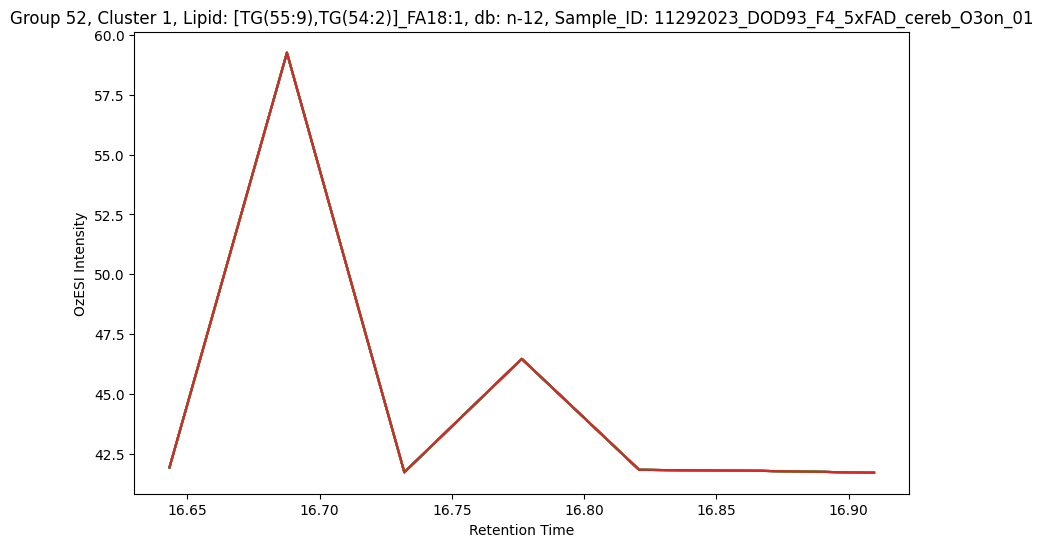

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.08


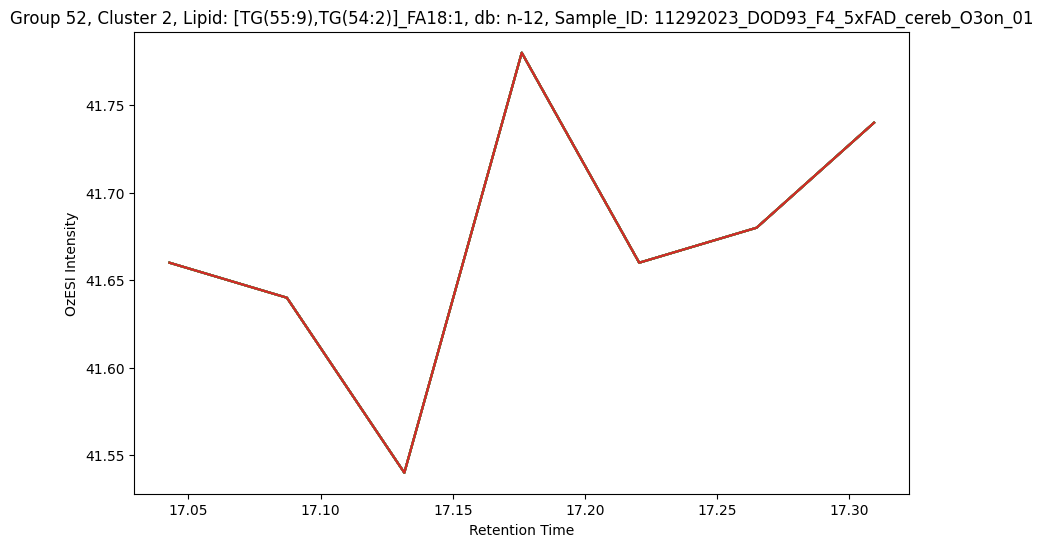

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


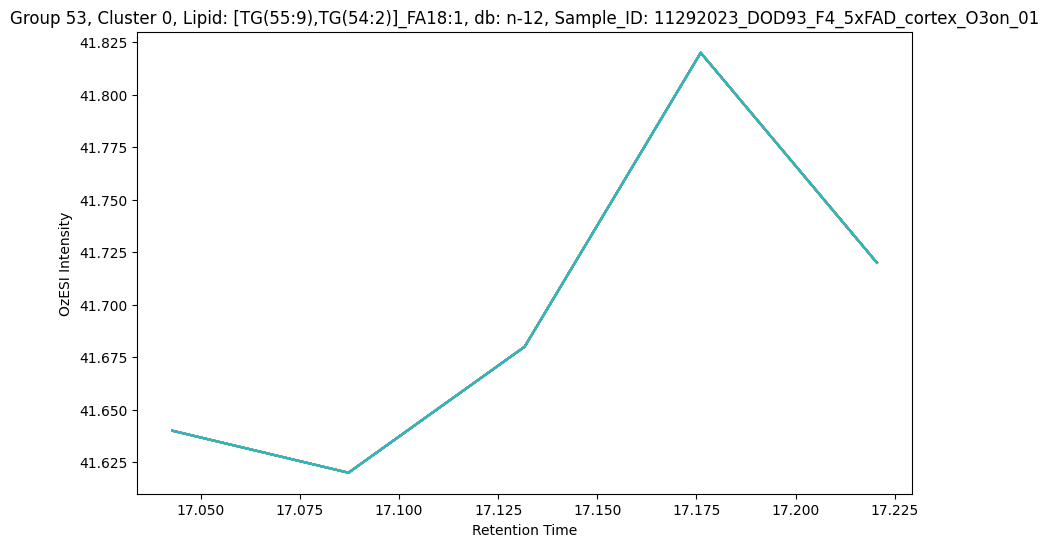

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


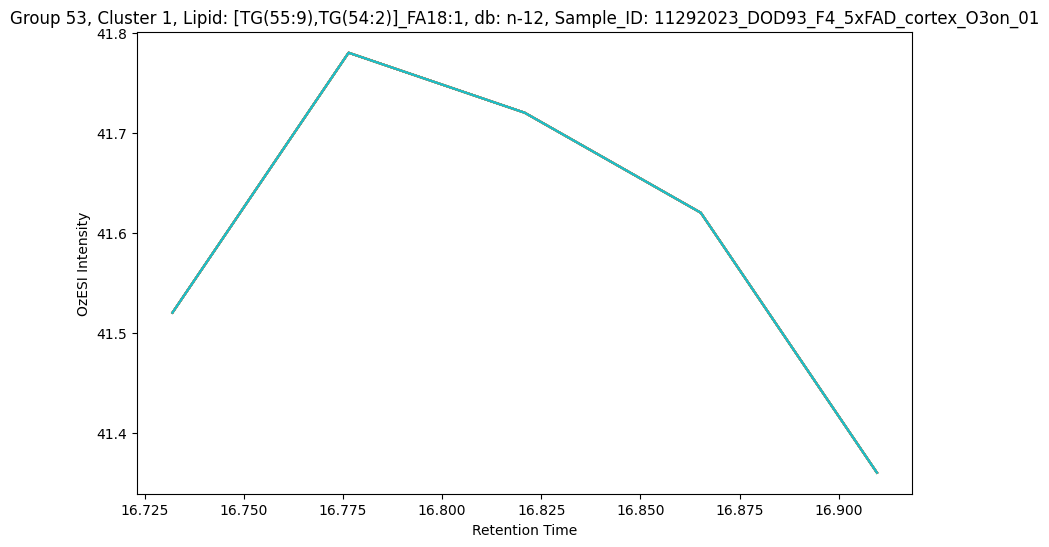

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


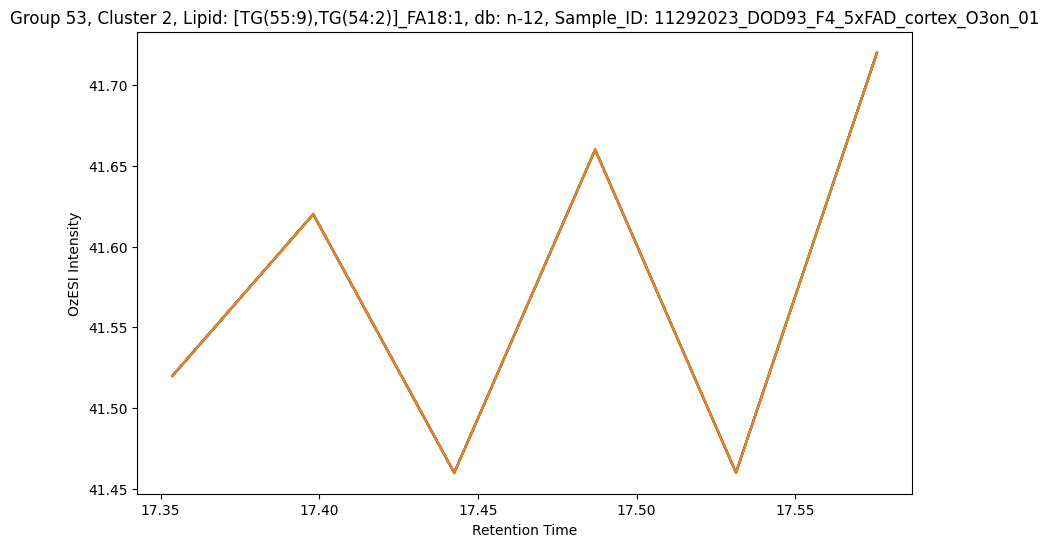

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.03


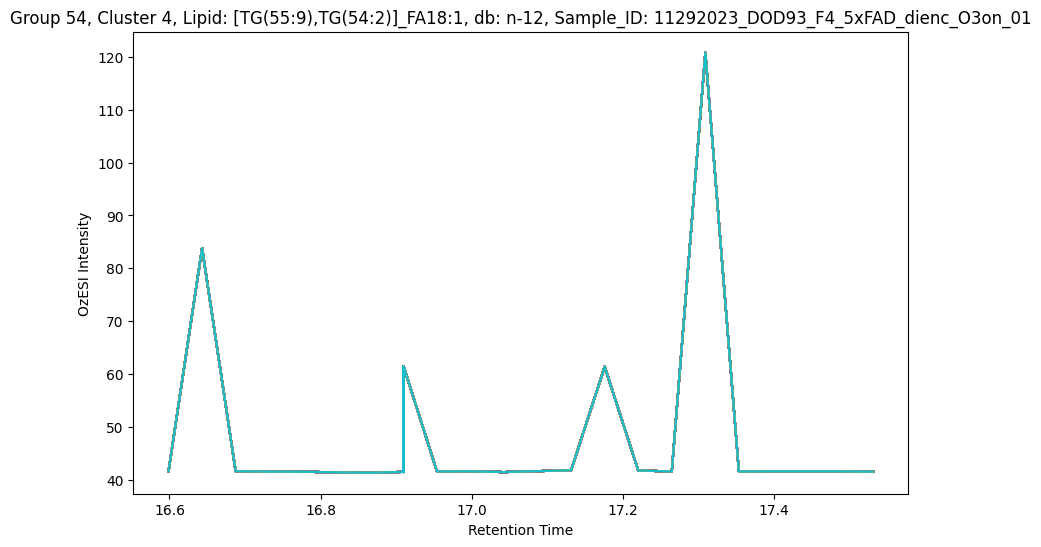

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


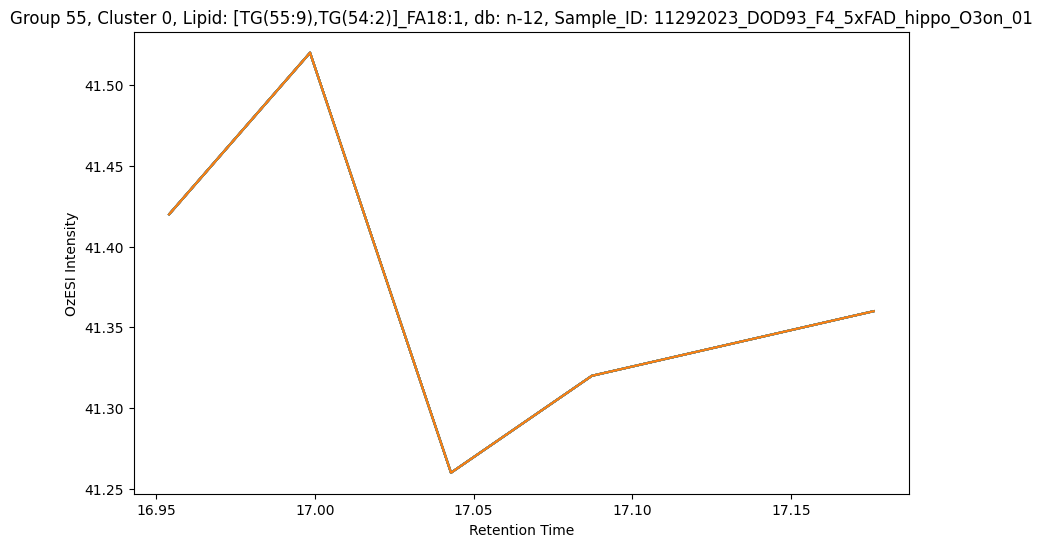

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


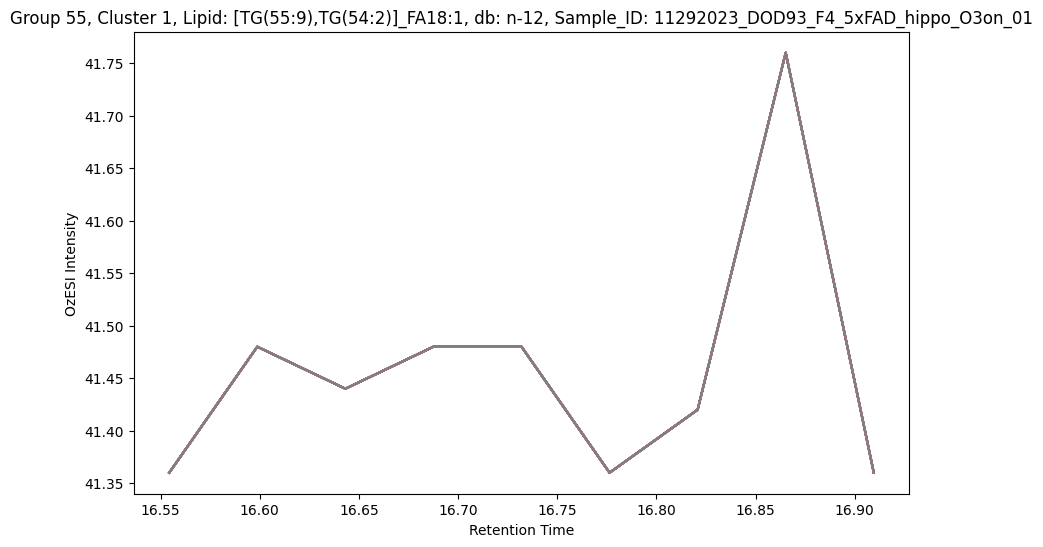

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


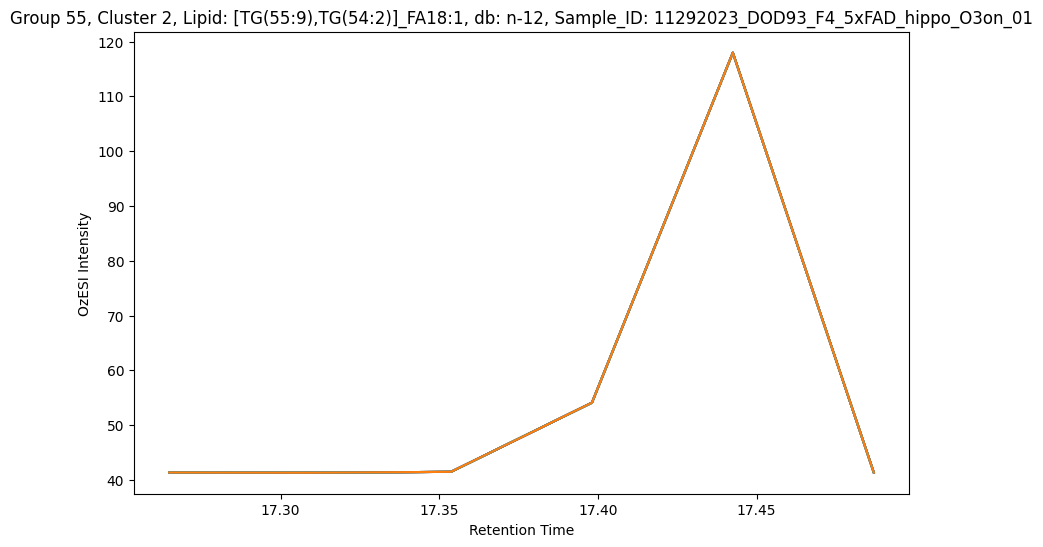

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.08


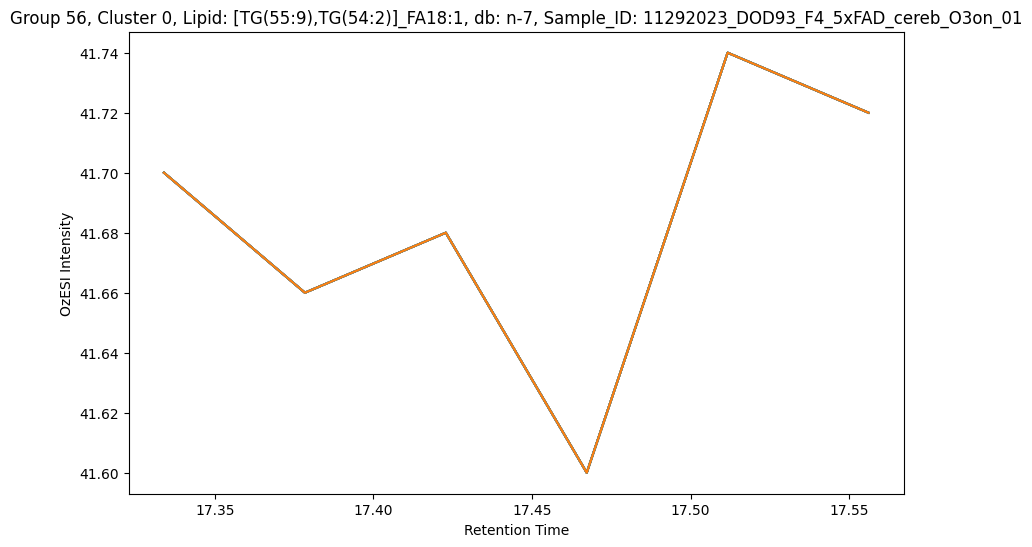

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.08


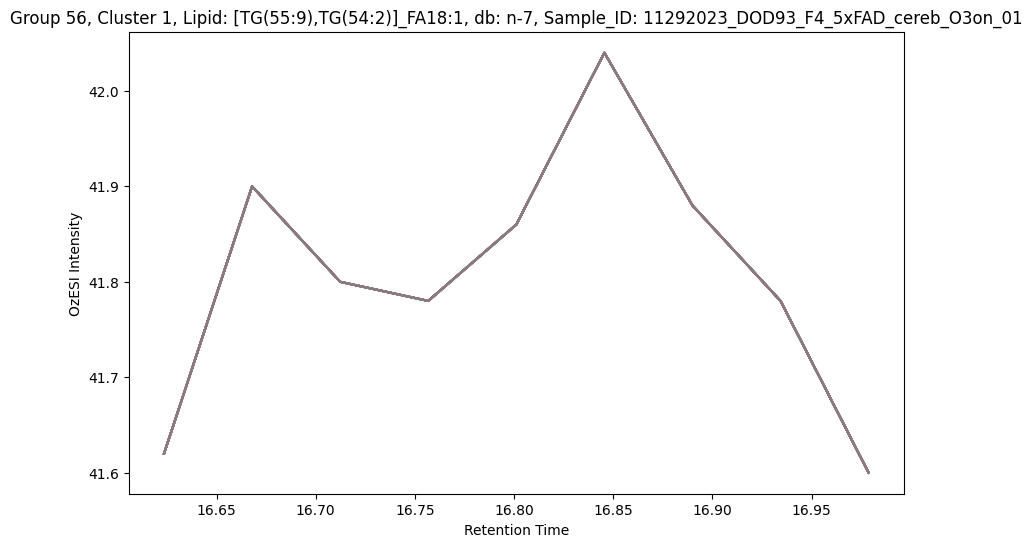

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.08


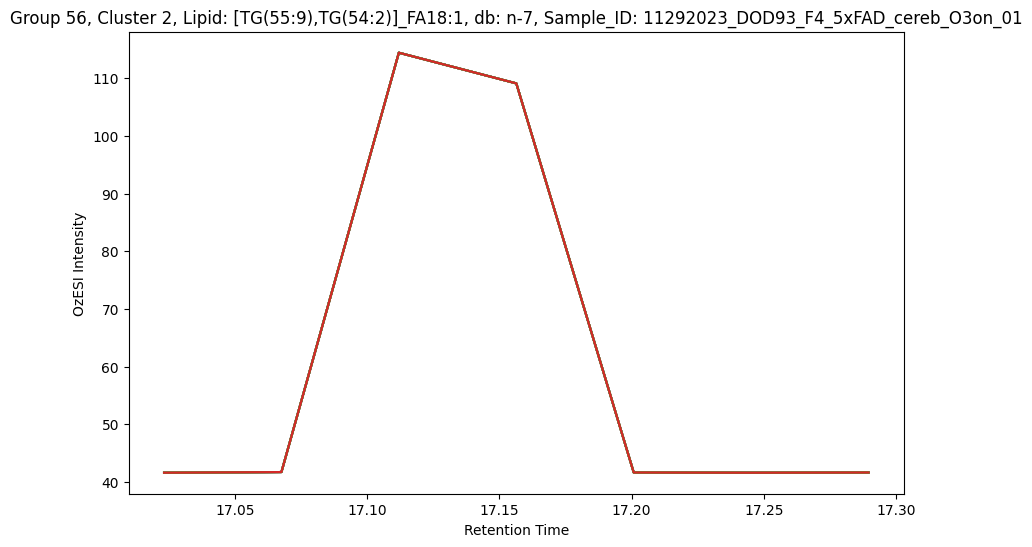

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


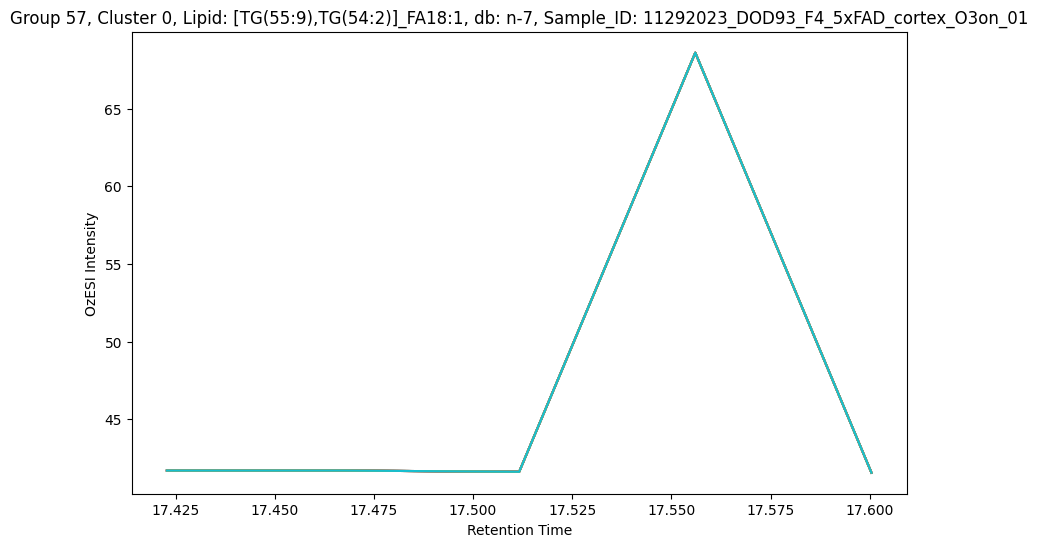

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


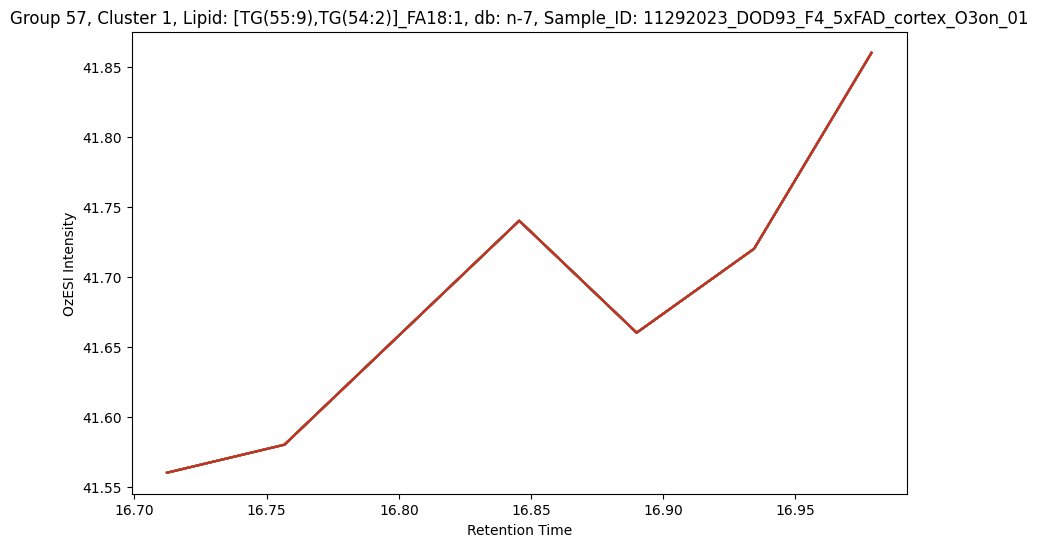

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


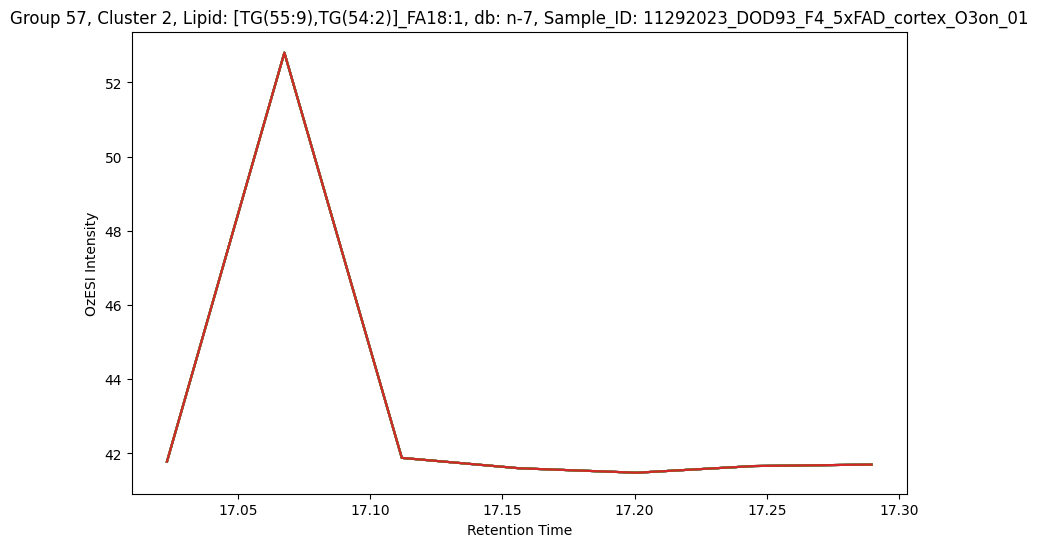

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.03


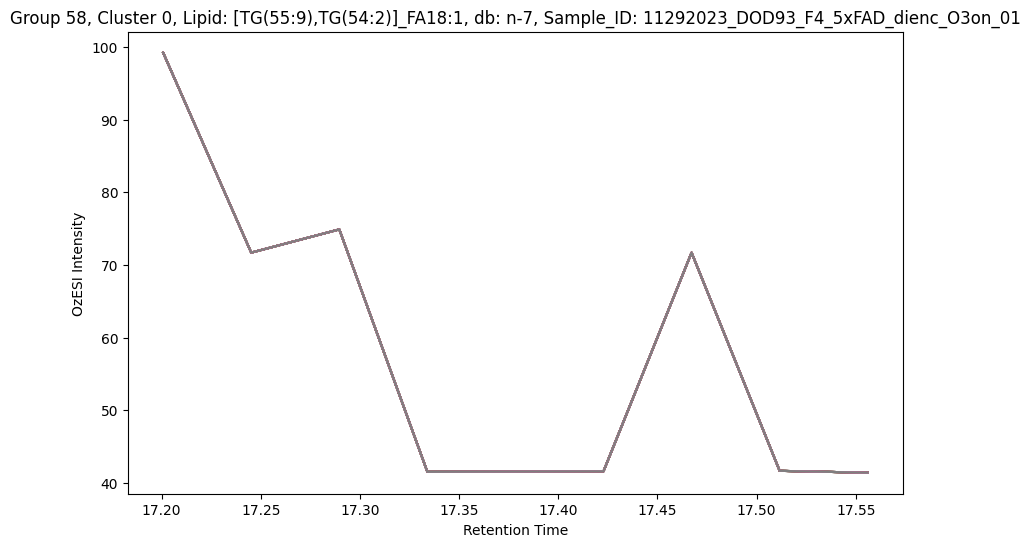

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.03


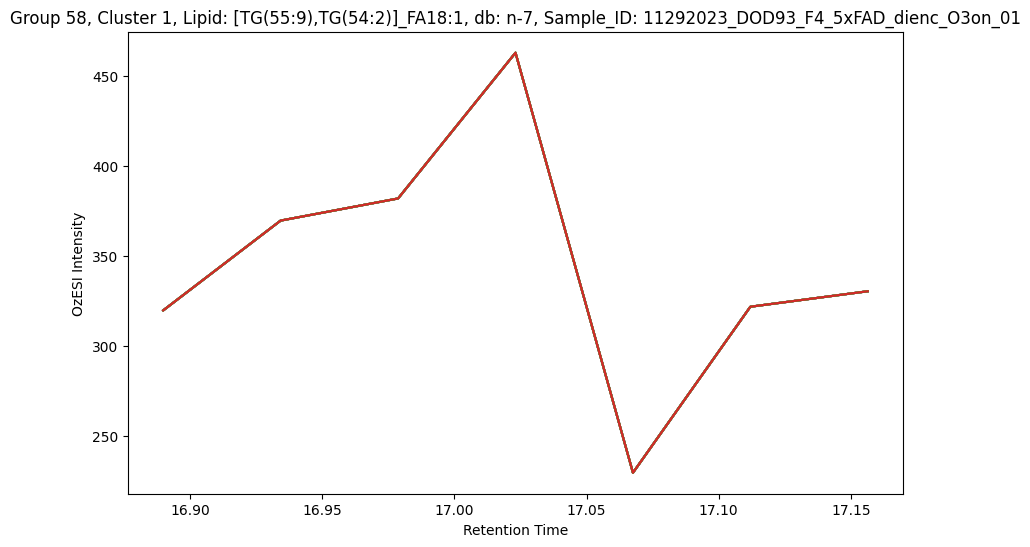

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.03


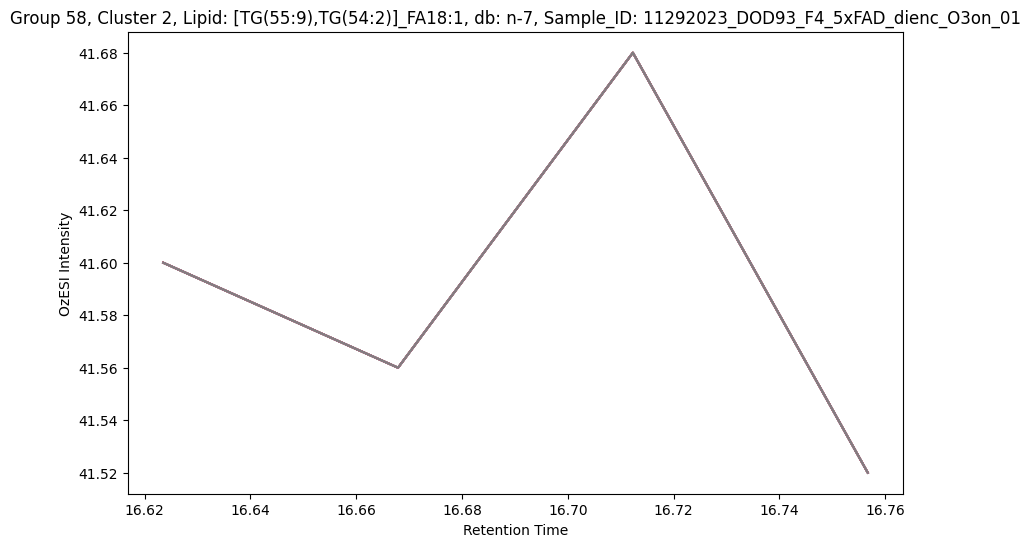

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


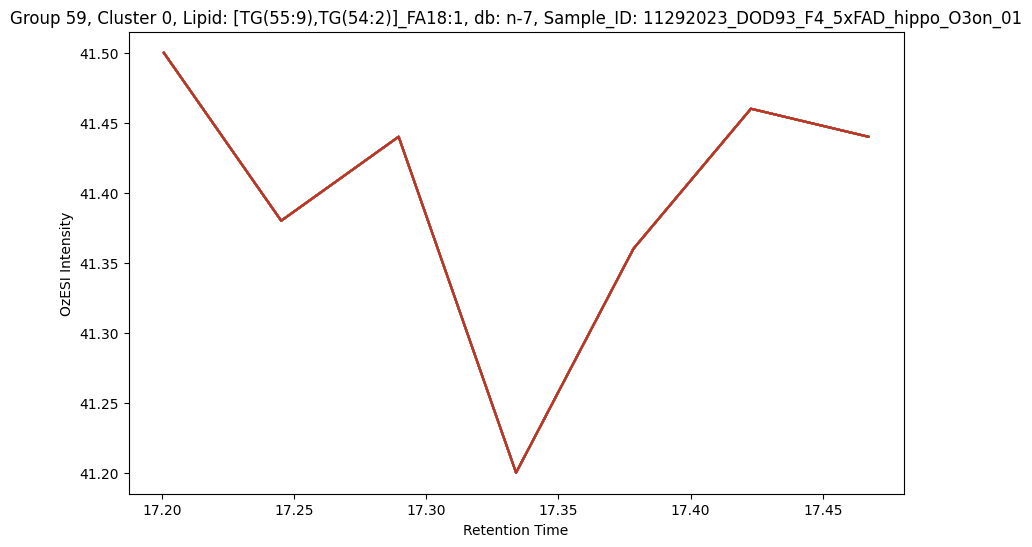

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


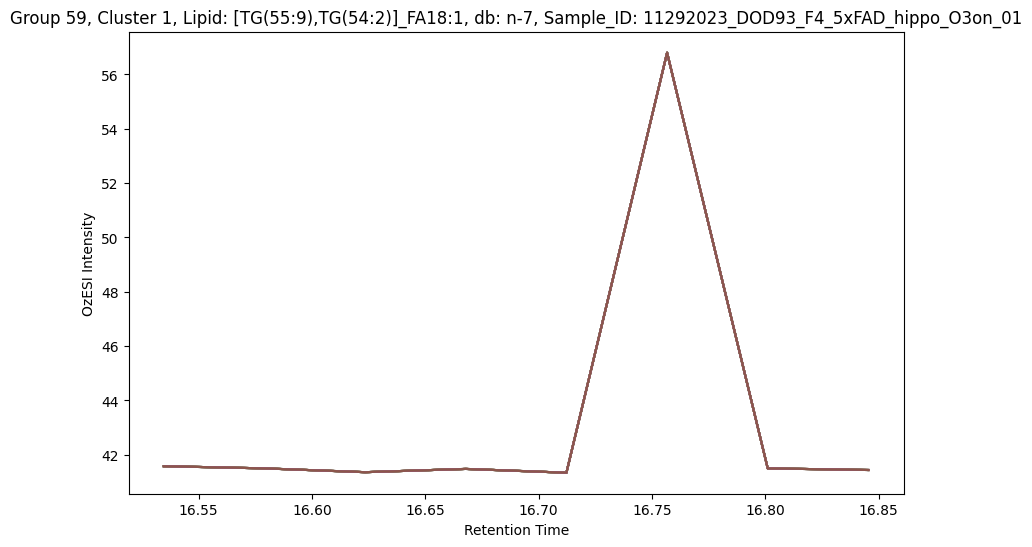

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


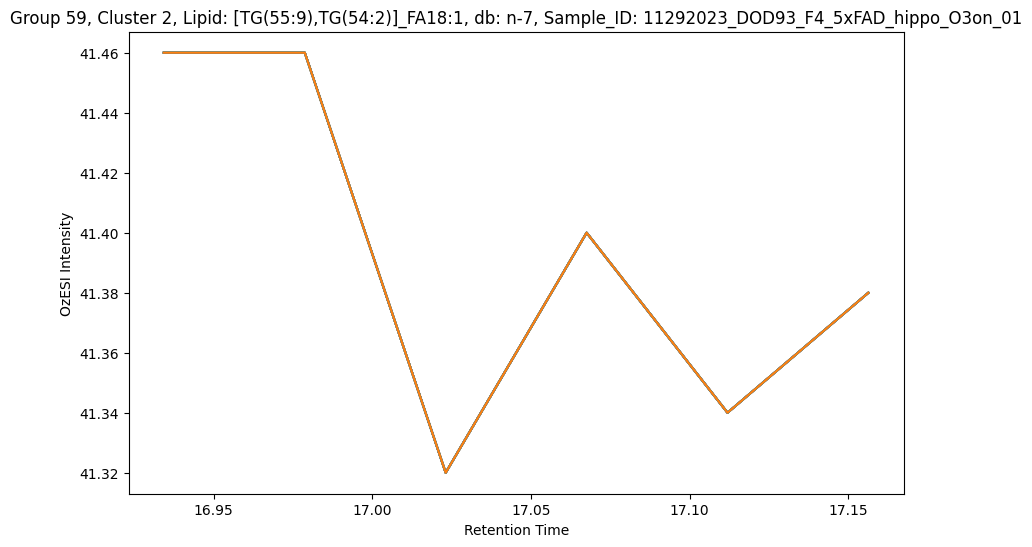

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.08


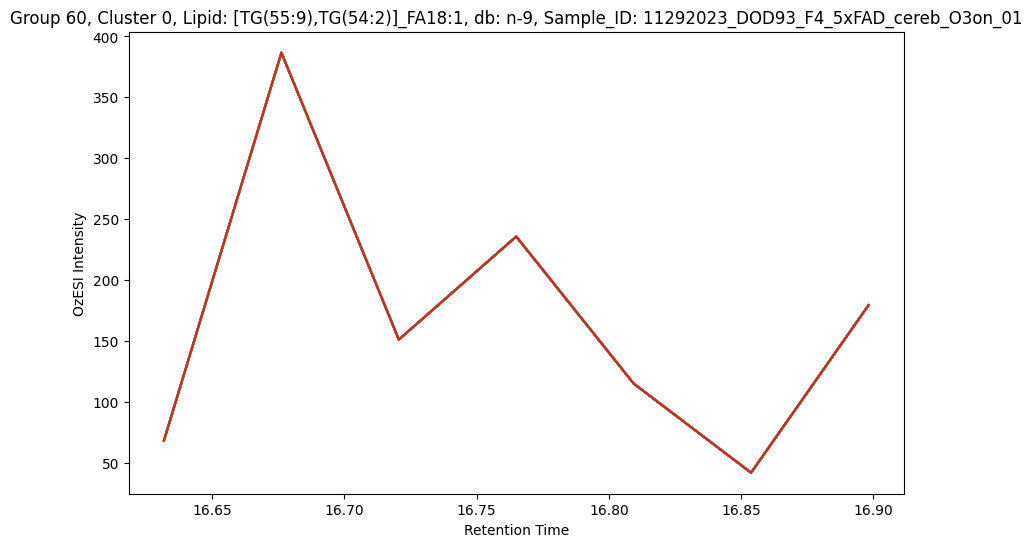

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.08


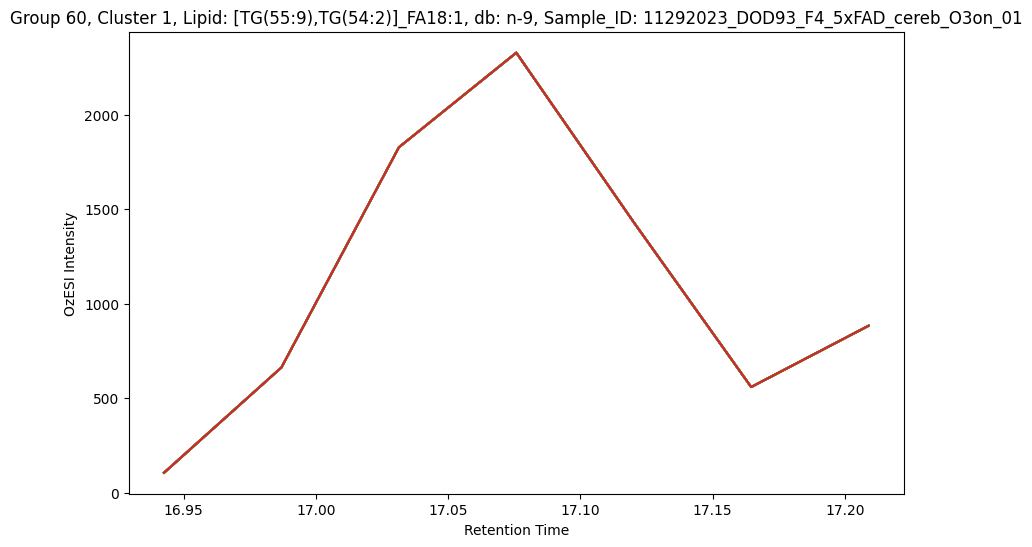

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.08


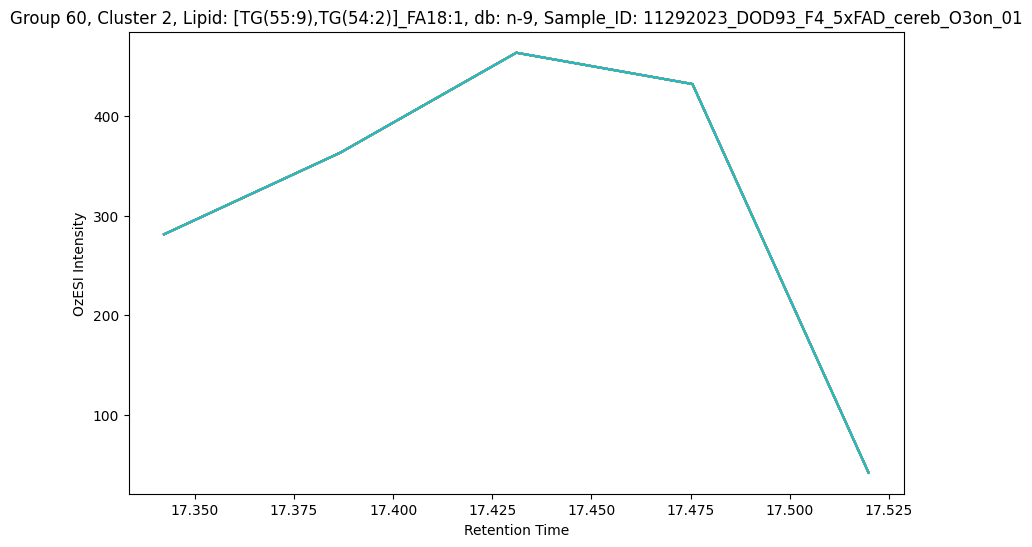

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


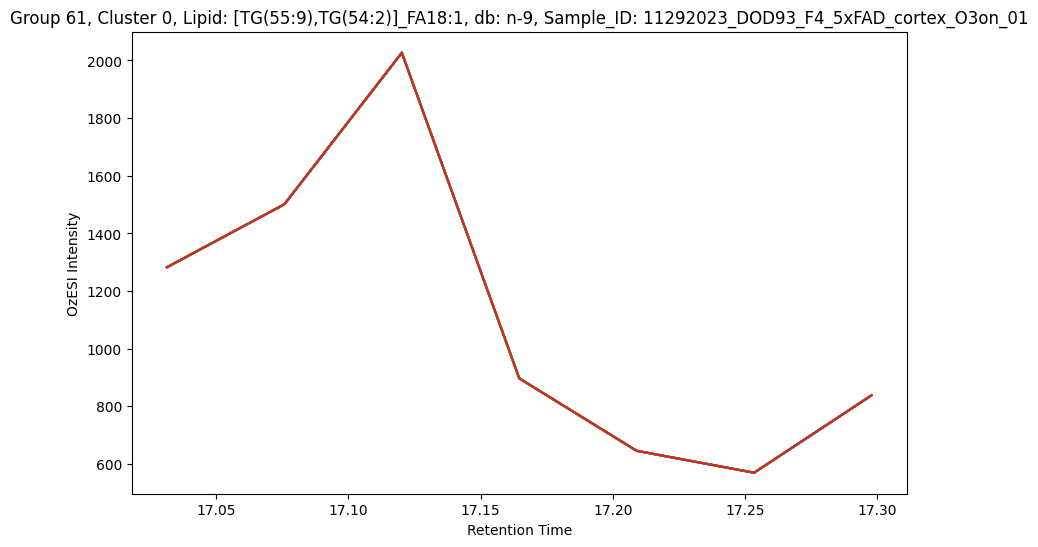

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


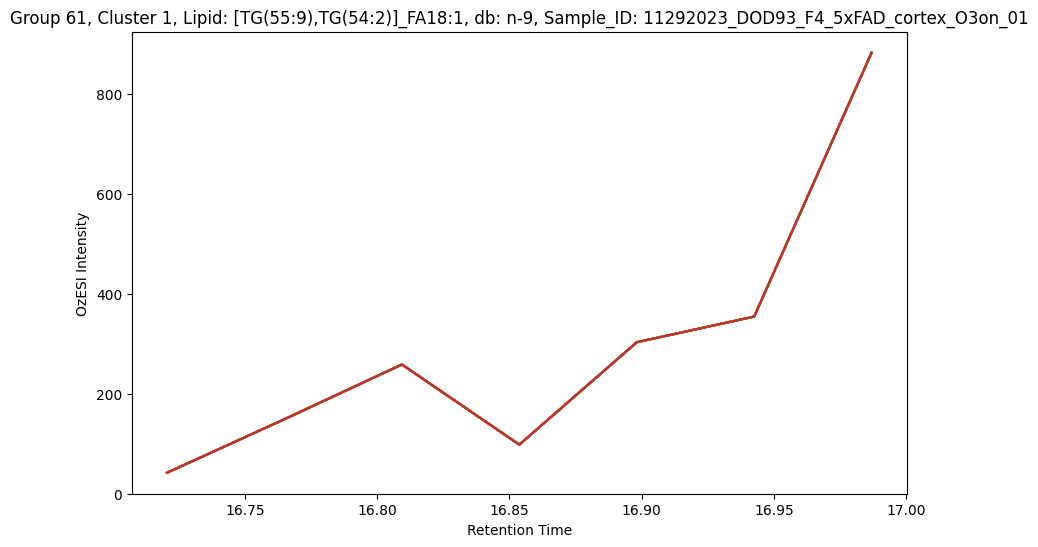

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


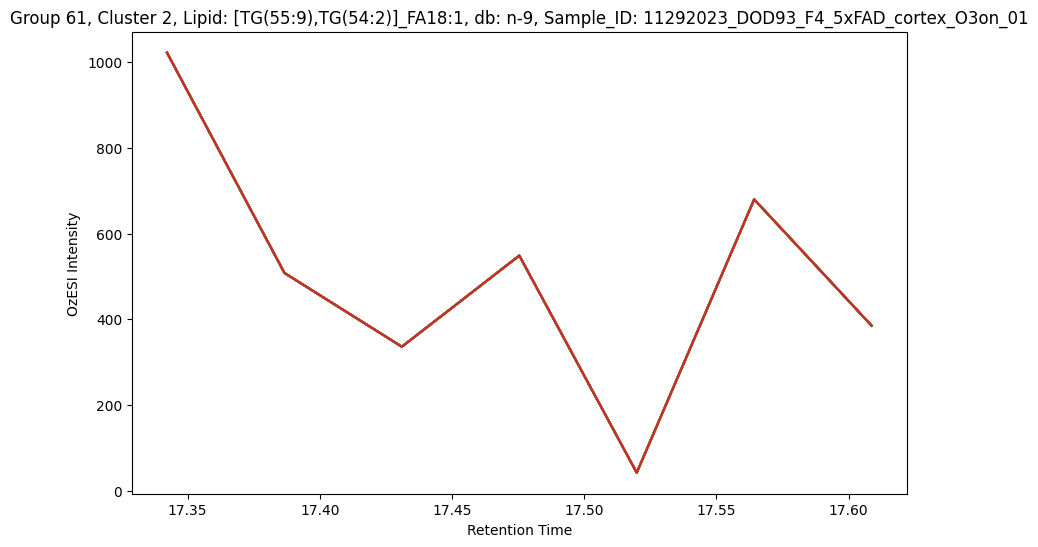

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.03


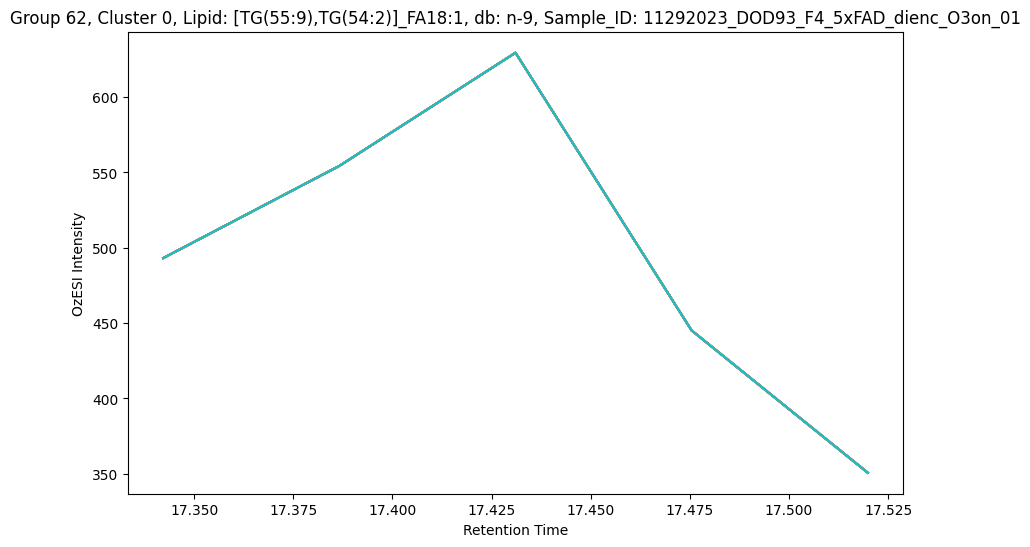

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.03


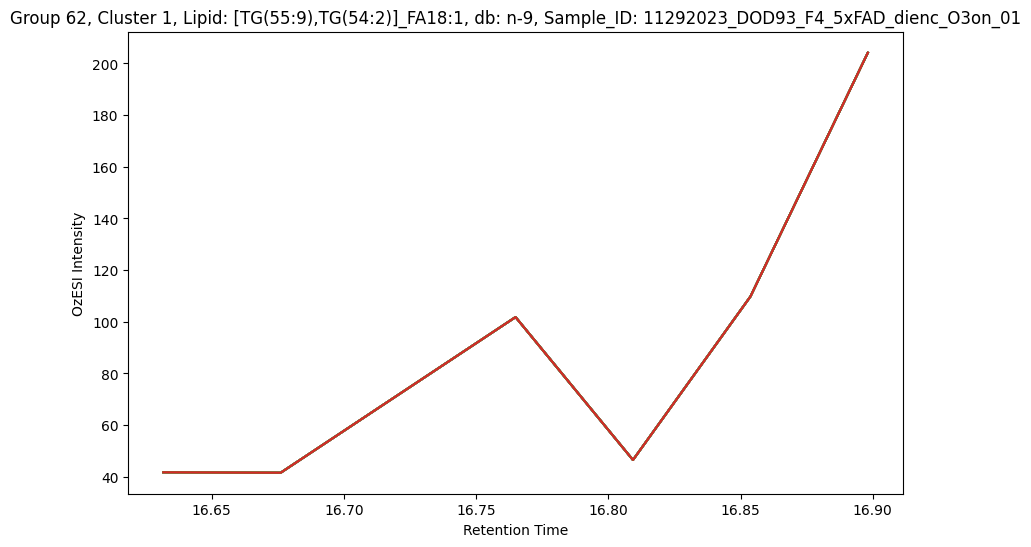

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.03


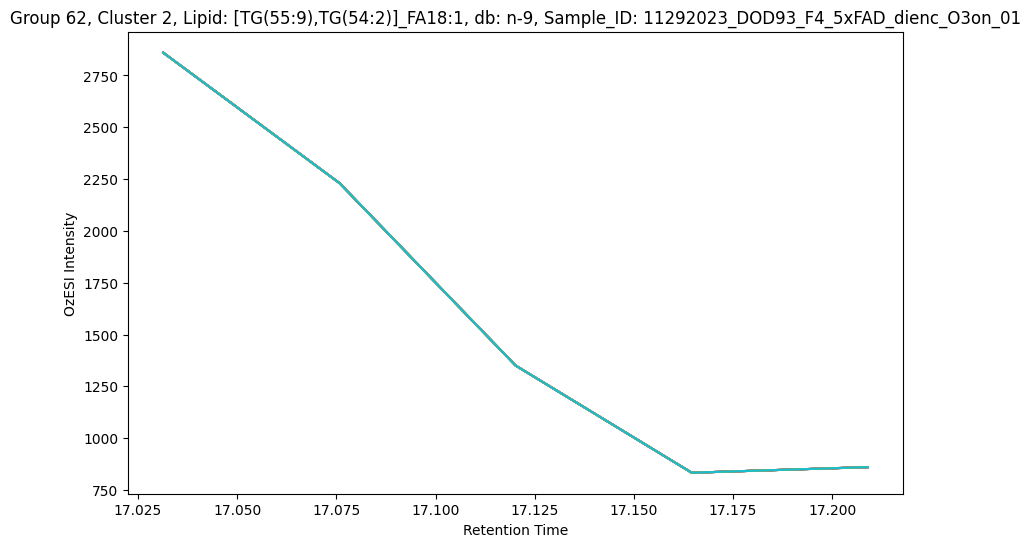

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


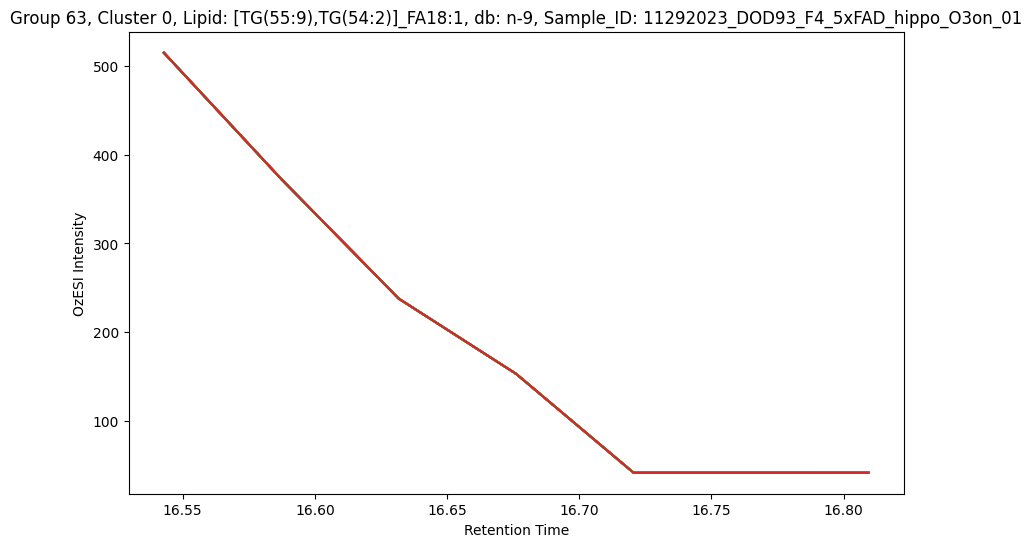

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


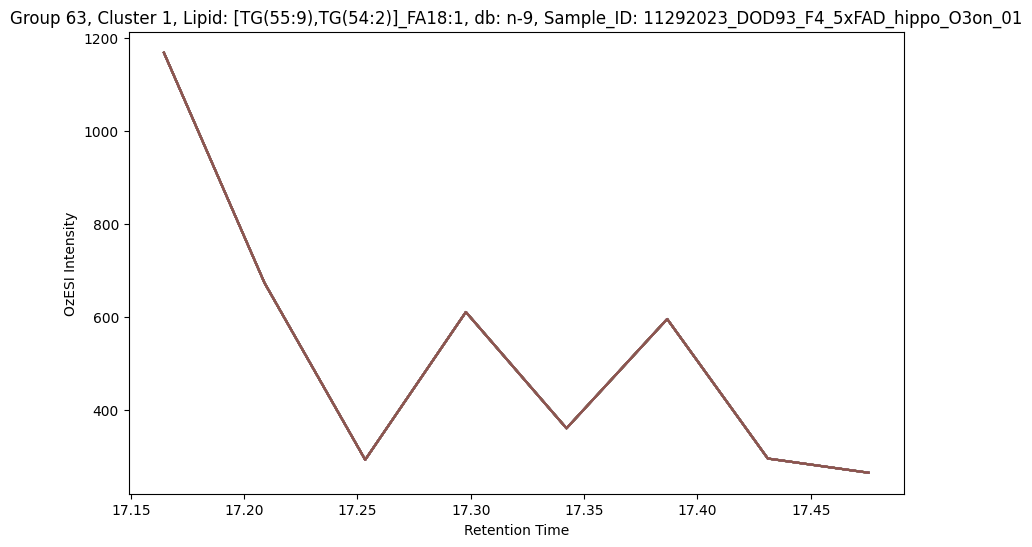

Lipid: [TG(55:9),TG(54:2)]_FA18:1, Correct_RT: 17.12


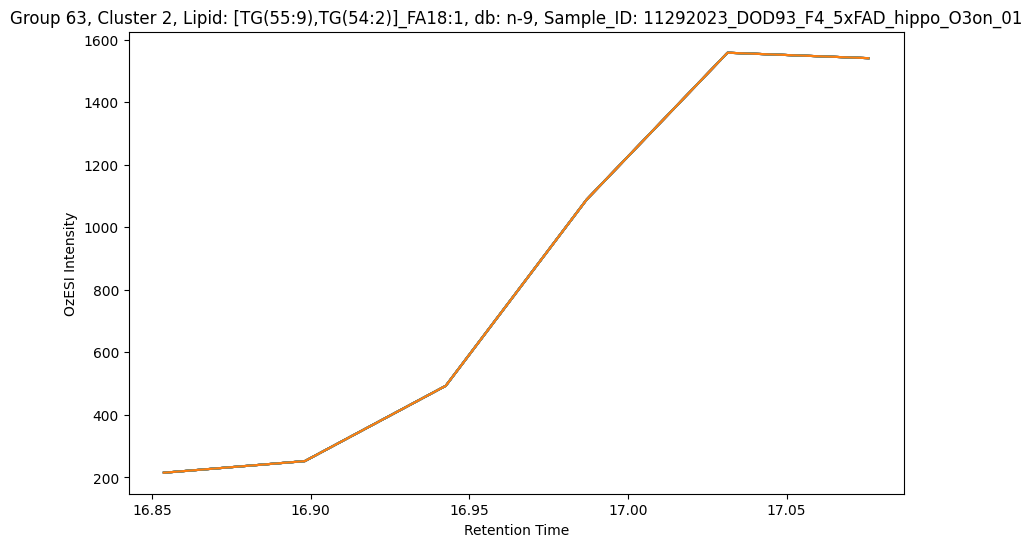

In [319]:
import matplotlib.pyplot as plt
import os

def plot_data(group_data, group, cluster_label, lipid_substring, save_dir):
    # Filter group_data for lipids containing the specified substring, if provided
    if lipid_substring:
        group_data = group_data[group_data['Lipid'].str.contains(lipid_substring)]

    if group_data.empty:
        return

    # Print Correct_RT for each unique lipid
    unique_lipids = group_data['Lipid'].unique()
    for lipid in unique_lipids:
        correct_rt = group_data[group_data['Lipid'] == lipid]['Correct_RT'].iloc[0]
        print(f"Lipid: {lipid}, Correct_RT: {correct_rt}")

    # Extracting data for plotting
    times = group_data['Retention_Time'].values
    intensities = group_data['OzESI_Intensity'].values

    # Plotting
    plt.figure(figsize=(10, 6))
    for _, row in group_data.iterrows():
        plt.plot(times, intensities, label=f"{row['Lipid']} Intensity")
    plt.xlabel('Retention Time')
    plt.ylabel('OzESI Intensity')

    # Extract additional information for the title
    lipid = group_data.iloc[0]['Lipid']
    db = group_data.iloc[0]['db']
    sample_id = group_data.iloc[0]['Sample_ID']
    plt.title(f'Group {group}, Cluster {cluster_label}, Lipid: {lipid}, db: {db}, Sample_ID: {sample_id}')

    # plt.legend()

    # Save the plot
    filename = f'Group_{group}_Cluster_{cluster_label}_Lipids_containing_{lipid_substring}.png'
    # Uncomment the line below to save the plot
    # plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
    plt.show()
    plt.close()

# Define the directory to save the plots
save_directory = 'Projects/FaceFats/plots/peak_check/manual/'  # Replace with your directory path

# Specify the substring to search in the Lipid column
selected_lipid_substring = '54:2'  # Replace with the substring you want to search for

# Plotting for each group-cluster pair in d10
for (group, cluster_label), group_df in d10.groupby(['Group', 'Cluster_Label']):
    plot_data(group_df, group, cluster_label, selected_lipid_substring, save_directory)


# Calculate Area of peak

In [320]:
d11 = d10.copy()  # Creating d11 DataFrame from the newly filtered d10



# Create an empty DataFrame for storing the calculated areas
area_results = pd.DataFrame(columns=['Group', 'Cluster_Label', 'Area'])

# Group by 'Group' and 'Cluster_Label'
grouped_data = d11.groupby(['Group', 'Cluster_Label'])

# Iterate over each group and calculate the area
for (group, cluster_label), group_data in grouped_data:
    # Sort the group data by 'Retention_Time'
    sorted_group_data = group_data.sort_values(by='Retention_Time')

    # Extract 'Retention_Time' and 'OzESI_Intensity'
    retention_time = sorted_group_data['Retention_Time']
    intensity = sorted_group_data['OzESI_Intensity']

    # Calculate the area using the trapezoidal rule
    area = trapz(intensity, retention_time)

    # Append the results to the area_results DataFrame
    area_results = area_results.append({
        'Group': group, 
        'Cluster_Label': cluster_label, 
        'Area': area
    }, ignore_index=True)

# Merge the calculated areas back into the original DataFrame
d11 = pd.merge(d11, area_results, on=['Group', 'Cluster_Label'])

# Round the 'Area' to 0 decimal places
d11['Area'] = d11['Area'].round(0)
d11


Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0          816.7        599.5       12.983900        41.640003   
1          816.7        599.5       12.983900        41.640003   
2          816.7        599.5       13.028300        41.920002   
3          816.7        599.5       13.028300        41.920002   
4          816.7        599.5       13.072700        41.640003   
...          ...          ...             ...              ...   
2849       822.7        605.5       17.511633        41.620003   
2850       822.7        605.5       17.556033        68.600006   
2851       822.7        605.5       17.556033        68.600006   
2852       822.7        605.5       17.600450        41.560001   
2853       822.7        605.5       17.600450        41.560001   

                                   Sample_ID      Transition  Match_Group  \
0      11292023_DOD93_F4_5xFAD_cereb_O3on_01  816.7 -> 599.5          348   
1      11292023_DOD93_F4_5xFAD_cereb_O3on_01  816.7 -> 599.5          348   
2      11292023_DOD93_F4_5xFAD_cereb_O3on_01  816.7 -> 599.5          348   
3      11292023_DOD93_F4_5xFAD_cereb_O3on_01  816.7 -> 599.5          348   
4      11292023_DOD93_F4_5xFAD_cereb_O3on_01  816.7 -> 599.5          348   
...                                      ...             ...          ...   
2849  11292023_DOD93_F4_5xFAD_cortex_O3on_01  822.7 -> 605.5          373   
2850  11292023_DOD93_F4_5xFAD_cortex_O3on_01  822.7 -> 605.5          373   
2851  11292023_DOD93_F4_5xFAD_cortex_O3on_01  822.7 -> 605.5          373   
2852  11292023_DOD93_F4_5xFAD_cortex_O3on_01  822.7 -> 605.5          373   
2853  11292023_DOD93_F4_5xFAD_cortex_O3on_01  822.7 -> 605.5          373   

                           Lipid   Cage Mouse  ...   db     FAC  \
0              [TG(54:5)]_FA18:1  DOD93    F4  ...  n-7  FA18:1   
1              [TG(54:5)]_FA18:1  DOD93    F4  ...  n-7  FA18:1   
2              [TG(54:5)]_FA18:1  DOD93    F4  ...  n-7  FA18:1   
3              [TG(54:5)]_FA18:1  DOD93    F4  ...  n-7  FA18:1   
4              [TG(54:5)]_FA18:1  DOD93    F4  ...  n-7  FA18:1   
...                          ...    ...   ...  ...  ...     ...   
2849  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...  n-7  FA18:1   
2850  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...  n-7  FA18:1   
2851  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...  n-7  FA18:1   
2852  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...  n-7  FA18:1   
2853  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...  n-7  FA18:1   

                      TG Group Cluster_Label Correct_RT Max_Intensity  \
0               TG(54:5)     8             1      13.48    967.360046   
1               TG(54:5)     8             1      13.48    967.360046   
2               TG(54:5)     8             1      13.48    967.360046   
3               TG(54:5)     8             1      13.48    967.360046   
4               TG(54:5)     8             1      13.48    967.360046   
...                  ...   ...           ...        ...           ...   
2849  TG(54:2), TG(55:9)    57             0      17.12   2026.900146   
2850  TG(54:2), TG(55:9)    57             0      17.12   2026.900146   
2851  TG(54:2), TG(55:9)    57             0      17.12   2026.900146   
2852  TG(54:2), TG(55:9)    57             0      17.12   2026.900146   
2853  TG(54:2), TG(55:9)    57             0      17.12   2026.900146   

      RT_Start  RT_End  Area  
0        12.98   13.29  11.0  
1        12.98   13.29  11.0  
2        12.98   13.29  11.0  
3        12.98   13.29  11.0  
4        12.98   13.29  11.0  
...        ...     ...   ...  
2849     17.38   17.64   9.0  
2850     17.38   17.64   9.0  
2851     17.38   17.64   9.0  
2852     17.38   17.64   9.0  
2853     17.38   17.64   9.0  

[2854 rows x 24 columns]

# Data Dependent Threshold (List of intensities)

In [321]:
d12 = d11.copy()

# Group the data by 'Group' and collect the 'OzESI_Intensity' values in lists
grouped_data = d12.groupby('Group')['OzESI_Intensity'].apply(list).reset_index(name='Group_Intensity')
# Merge the original data with the grouped data
d12 = d12.merge(grouped_data, on='Group')


# Sorting the lists in the 'Group_Intensity' column
d12['Group_Intensity'] = d12['Group_Intensity'].apply(lambda x: sorted(x))

d12  # Display the first few rows of the merged DataFrame



def set_threshold(group_intensity_list, threshold1=0.3, threshold2=0):
    """
    Function to set a threshold at a specified level of the list and add an additional value to it.

    :param group_intensity_list: List of intensity values for a group.
    :param threshold1: The percentage level at which to set the threshold (default is 0.3 for 30%).
    :param threshold2: An additional value to add to the threshold (default is 0).
    :return: The threshold value.
    """
    if not group_intensity_list:
        return None
    sorted_list = sorted(group_intensity_list)
    index = int(len(sorted_list) * threshold1)
    return sorted_list[index] + threshold2

# Example usage
# Assuming df_merged is your DataFrame with the 'Group_Intensity' column
d12['Group_Threshold'] = d12['Group_Intensity'].apply(lambda x: set_threshold(x, threshold1=0.15, threshold2=100))
#round the threshold to 0 decimal places
d12['Group_Threshold'] = d12['Group_Threshold'].round(0)


# To display the first few rows of the DataFrame with the new column
d12

# Filter the DataFrame to keep only the rows where 'OzESI_Intensity' is greater than or equal to 'Group_Threshold'
d13 = d12[d12['OzESI_Intensity'] >= d12['Group_Threshold']]

# Display the first few rows of the filtered DataFrame
d13




Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
18         816.7        599.5       13.472367       209.920013   
19         816.7        599.5       13.472367       209.920013   
20         816.7        599.5       13.516767       144.700012   
21         816.7        599.5       13.516767       144.700012   
68         788.7        599.5       13.391817       147.840012   
...          ...          ...             ...              ...   
2775       794.7        605.5       17.475450       548.480042   
2778       794.7        605.5       17.564267       679.740051   
2779       794.7        605.5       17.564267       679.740051   
2780       794.7        605.5       17.608667       384.960022   
2781       794.7        605.5       17.608667       384.960022   

                                   Sample_ID      Transition  Match_Group  \
18     11292023_DOD93_F4_5xFAD_cereb_O3on_01  816.7 -> 599.5          348   
19     11292023_DOD93_F4_5xFAD_cereb_O3on_01  816.7 -> 599.5          348   
20     11292023_DOD93_F4_5xFAD_cereb_O3on_01  816.7 -> 599.5          348   
21     11292023_DOD93_F4_5xFAD_cereb_O3on_01  816.7 -> 599.5          348   
68     11292023_DOD93_F4_5xFAD_cereb_O3on_01  788.7 -> 599.5          244   
...                                      ...             ...          ...   
2775  11292023_DOD93_F4_5xFAD_cortex_O3on_01  794.7 -> 605.5          269   
2778  11292023_DOD93_F4_5xFAD_cortex_O3on_01  794.7 -> 605.5          269   
2779  11292023_DOD93_F4_5xFAD_cortex_O3on_01  794.7 -> 605.5          269   
2780  11292023_DOD93_F4_5xFAD_cortex_O3on_01  794.7 -> 605.5          269   
2781  11292023_DOD93_F4_5xFAD_cortex_O3on_01  794.7 -> 605.5          269   

                           Lipid   Cage Mouse  ...                  TG Group  \
18             [TG(54:5)]_FA18:1  DOD93    F4  ...            TG(54:5)     8   
19             [TG(54:5)]_FA18:1  DOD93    F4  ...            TG(54:5)     8   
20             [TG(54:5)]_FA18:1  DOD93    F4  ...            TG(54:5)     8   
21             [TG(54:5)]_FA18:1  DOD93    F4  ...            TG(54:5)     8   
68             [TG(54:5)]_FA18:1  DOD93    F4  ...            TG(54:5)    12   
...                          ...    ...   ...  ...                 ...   ...   
2775  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...  TG(54:2), TG(55:9)    61   
2778  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...  TG(54:2), TG(55:9)    61   
2779  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...  TG(54:2), TG(55:9)    61   
2780  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...  TG(54:2), TG(55:9)    61   
2781  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...  TG(54:2), TG(55:9)    61   

      Cluster_Label Correct_RT Max_Intensity RT_Start RT_End   Area  \
18                2      13.48    967.360046    13.34  13.61   21.0   
19                2      13.48    967.360046    13.34  13.61   21.0   
20                2      13.48    967.360046    13.34  13.61   21.0   
21                2      13.48    967.360046    13.34  13.61   21.0   
68                2      13.48    967.360046    13.35  13.61   67.0   
...             ...        ...           ...      ...    ...    ...   
2775              2      17.12   2026.900146    17.34  17.61  125.0   
2778              2      17.12   2026.900146    17.34  17.61  125.0   
2779              2      17.12   2026.900146    17.34  17.61  125.0   
2780              2      17.12   2026.900146    17.34  17.61  125.0   
2781              2      17.12   2026.900146    17.34  17.61  125.0   

                                        Group_Intensity  Group_Threshold  
18    [41.480003356933594, 41.480003356933594, 41.56...            142.0  
19    [41.480003356933594, 41.480003356933594, 41.56...            142.0  
20    [41.480003356933594, 41.480003356933594, 41.56...            142.0  
21    [41.480003356933594, 41.480003356933594, 41.56...            142.0  
68    [41.42000198364258, 41.42000198364258, 41.4400...            142.0  
...                     

# DDT Area Calculations 

In [322]:


# Assuming d5e is your original DataFrame
d14 = d13.copy()

# Create an empty DataFrame for storing the calculated areas
area_results_ddt = pd.DataFrame(columns=['Group', 'Cluster_Label', 'Area_DDT'])

# Group by 'Group' and 'Cluster_Label'
grouped_data_ddt = d14.groupby(['Group', 'Cluster_Label'])

# Iterate over each group and calculate the area
for (group, cluster_label), group_data in grouped_data_ddt:
    # Sort the group data by 'Retention_Time'
    sorted_group_data = group_data.sort_values(by='Retention_Time')

    # Extract 'Retention_Time' and 'OzESI_Intensity'
    retention_time = sorted_group_data['Retention_Time']
    intensity = sorted_group_data['OzESI_Intensity']

    # Calculate the area using the trapezoidal rule
    area = trapz(intensity, retention_time)

    # Append the results to the area_results_ddt DataFrame
    area_results_ddt = area_results_ddt.append({
        'Group': group, 
        'Cluster_Label': cluster_label, 
        'Area_DDT': area
    }, ignore_index=True)

# ... [previous code for calculating areas and appending to area_results_ddt] ...

# Merge the calculated areas back into the original DataFrame
d14 = pd.merge(d14, area_results_ddt, on=['Group', 'Cluster_Label'], how='left')

# Check if 'Area_DDT' is in d14 after merging
if 'Area_DDT' in d14.columns:
    # Round the 'Area_DDT' to 0 decimal places
    d14['Area_DDT'] = d14['Area_DDT'].round(0)
else:
    print("Area_DDT column not found in d14 after merging.")

# Display the DataFrame
d14






Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0         816.7        599.5       13.472367       209.920013   
1         816.7        599.5       13.472367       209.920013   
2         816.7        599.5       13.516767       144.700012   
3         816.7        599.5       13.516767       144.700012   
4         788.7        599.5       13.391817       147.840012   
..          ...          ...             ...              ...   
561       794.7        605.5       17.475450       548.480042   
562       794.7        605.5       17.564267       679.740051   
563       794.7        605.5       17.564267       679.740051   
564       794.7        605.5       17.608667       384.960022   
565       794.7        605.5       17.608667       384.960022   

                                  Sample_ID      Transition  Match_Group  \
0     11292023_DOD93_F4_5xFAD_cereb_O3on_01  816.7 -> 599.5          348   
1     11292023_DOD93_F4_5xFAD_cereb_O3on_01  816.7 -> 599.5          348   
2     11292023_DOD93_F4_5xFAD_cereb_O3on_01  816.7 -> 599.5          348   
3     11292023_DOD93_F4_5xFAD_cereb_O3on_01  816.7 -> 599.5          348   
4     11292023_DOD93_F4_5xFAD_cereb_O3on_01  788.7 -> 599.5          244   
..                                      ...             ...          ...   
561  11292023_DOD93_F4_5xFAD_cortex_O3on_01  794.7 -> 605.5          269   
562  11292023_DOD93_F4_5xFAD_cortex_O3on_01  794.7 -> 605.5          269   
563  11292023_DOD93_F4_5xFAD_cortex_O3on_01  794.7 -> 605.5          269   
564  11292023_DOD93_F4_5xFAD_cortex_O3on_01  794.7 -> 605.5          269   
565  11292023_DOD93_F4_5xFAD_cortex_O3on_01  794.7 -> 605.5          269   

                          Lipid   Cage Mouse  ... Group Cluster_Label  \
0             [TG(54:5)]_FA18:1  DOD93    F4  ...     8             2   
1             [TG(54:5)]_FA18:1  DOD93    F4  ...     8             2   
2             [TG(54:5)]_FA18:1  DOD93    F4  ...     8             2   
3             [TG(54:5)]_FA18:1  DOD93    F4  ...     8             2   
4             [TG(54:5)]_FA18:1  DOD93    F4  ...    12             2   
..                          ...    ...   ...  ...   ...           ...   
561  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...    61             2   
562  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...    61             2   
563  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...    61             2   
564  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...    61             2   
565  [TG(55:9),TG(54:2)]_FA18:1  DOD93    F4  ...    61             2   

     Correct_RT Max_Intensity RT_Start RT_End   Area  \
0         13.48    967.360046    13.34  13.61   21.0   
1         13.48    967.360046    13.34  13.61   21.0   
2         13.48    967.360046    13.34  13.61   21.0   
3         13.48    967.360046    13.34  13.61   21.0   
4         13.48    967.360046    13.35  13.61   67.0   
..          ...           ...      ...    ...    ...   
561       17.12   2026.900146    17.34  17.61  125.0   
562       17.12   2026.900146    17.34  17.61  125.0   
563       17.12   2026.900146    17.34  17.61  125.0   
564       17.12   2026.900146    17.34  17.61  125.0   
565       17.12   2026.900146    17.34  17.61  125.0   

                                       Group_Intensity  Group_Threshold  \
0    [41.480003356933594, 41.480003356933594, 41.56...            142.0   
1    [41.480003356933594, 41.480003356933594, 41.56...            142.0   
2    [41.480003356933594, 41.480003356933594, 41.56...            142.0   
3    [41.480003356933594, 41.480003356933594, 41.56...            142.0   
4    [41.42000198364258, 41.42000198364258, 41.4400...            142.0   
..                                                 ...              ...   
561  [41.62000274658203, 41.62000274658203, 41.6400...            249.0   
562  [41.62000274658203, 41.62000274658203, 41.6400...            249.0   
563  [41.62000274658203, 41.62000274658203, 41.6400...            249.0   
564  [41.62

# Remove db not present and sort df 

In [323]:
#based on sample_ID Lipid and db pos, keep the unique value with the highest intensity
# Sort the DataFrame by 'OzESI_Intensity' in descending order to ensure the highest intensity is first

d15 = d14.copy()
# Assuming your DataFrame is named d15
d15 = d15[d15['db'] != '']
d15




#sort d15 by max OzESI_Intensity
d15 = d15.sort_values(by='OzESI_Intensity', ascending=False)

d15 = d15.groupby(['Lipid', 'Sample_ID', 'db']).first().reset_index()



#round the retention time to 2 decimal places
d15['Retention_Time'] = d15['Retention_Time'].round(2)
#round intensity to 0 decimal places
d15['OzESI_Intensity'] = d15['OzESI_Intensity'].round(0)

d15 = d15.sort_values(by=['Biology','Genotype','FAC', 'TG'])

d15

Lipid                               Sample_ID    db  \
23   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
6   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01  n-12   
7   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-7   
8   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
17  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
0             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-7   
1             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
24   [TG(55:9),TG(54:2)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
9   [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01  n-12   
10  [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
11  [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
18  [TG(55:11),TG(54:4)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
19  [TG(55:11),TG(54:4)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
2             [TG(54:5)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
3             [TG(54:5)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
25   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
26   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
12  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
13  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
20  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
21  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
4             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
27   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
14  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01  n-12   
15  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-7   
16  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
22  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
5             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   

    Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity      Transition  \
23       794.7        605.5           17.08           2329.0  794.7 -> 605.5   
6        750.6        603.5           16.11            181.0  750.6 -> 603.5   
7        820.7        603.5           15.78            442.0  820.7 -> 603.5   
8        792.7        603.5           15.88           9306.0  792.7 -> 603.5   
17       790.7        601.5           14.63           1445.0  790.7 -> 601.5   
0        816.7        599.5           13.47            210.0  816.7 -> 599.5   
1        788.7        599.5           13.48            967.0  788.7 -> 599.5   
24       794.7        605.5           17.12           2027.0  794.7 -> 605.5   
9        750.6        603.5           15.84            190.0  750.6 -> 603.5   
10       820.7        603.5           15.74            654.0  820.7 -> 603.5   
11       792.7        603.5           15.88           8602.0  792.7 -> 603.5   
18       818.7        601.5           14.63            313.0  818.7 -> 601.5   
19       790.7        601.5           14.68           3545.0  790.7 -> 601.5   
2        816.7        599.5           13.56            155.0  816.7 -> 599.5   
3        788.7        599.5           13.53           1047.0  788.7 -> 599.5   
25       822.7        605.5           17.02            463.0  822.7 -> 605.5   
26       794.7        605.5           17.03           2860.0  794.7 -> 605.5   
12       820.7        603.5           15.82           1197.0  820.7 -> 603.5   
13       792.7        603.5           15.83          10458.0  792.7 -> 603.5   
20       818.7        601.5           14.72            319.0  818.7 -> 601.5

Calculate Area Ratio

In [324]:
d16 = d15.copy()

# Filter for 'n-9' and 'n-7' in the 'db' column
filtered_df = d16[d16['db'].isin(['n-9', 'n-7'])]

# Group by 'Lipid' and 'Sample_ID'
grouped = filtered_df.groupby(['Lipid', 'Sample_ID'])

# DataFrame for Area Ratios
area_ratios = pd.DataFrame(columns=['Lipid', 'Sample_ID', 'Area_DDT_Ratio'])

# Calculate Area Ratio for each group
for (lipid, sample_id), group in grouped:
    n9_area = group[group['db'] == 'n-9']['Area_DDT'].sum()  # Sum if there are multiple 'n-9' entries
    n7_area = group[group['db'] == 'n-7']['Area_DDT'].sum()  # Sum if there are multiple 'n-7' entries
    ratio = round(n9_area / n7_area, 2) if n7_area != 0 else None

    # Append to DataFrame
    area_ratios = area_ratios.append({
        'Lipid': lipid,
        'Sample_ID': sample_id,
        'Area_DDT_Ratio': ratio
    }, ignore_index=True)

# Merge the Area Ratio DataFrame with the original DataFrame
d16 = pd.merge(d16, area_ratios, on=['Lipid', 'Sample_ID'], how='left')

d16 # Display the updated DataFrame with 'Area_Ratio'


Lipid                               Sample_ID    db  \
0    [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
1   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01  n-12   
2   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-7   
3   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
4   [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
5             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-7   
6             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
7    [TG(55:9),TG(54:2)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
8   [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01  n-12   
9   [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
10  [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
11  [TG(55:11),TG(54:4)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
12  [TG(55:11),TG(54:4)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
13            [TG(54:5)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
14            [TG(54:5)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
15   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
16   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
17  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
18  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
19  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
20  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
21            [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
22   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
23  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01  n-12   
24  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-7   
25  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
26  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
27            [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   

    Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity      Transition  \
0        794.7        605.5           17.08           2329.0  794.7 -> 605.5   
1        750.6        603.5           16.11            181.0  750.6 -> 603.5   
2        820.7        603.5           15.78            442.0  820.7 -> 603.5   
3        792.7        603.5           15.88           9306.0  792.7 -> 603.5   
4        790.7        601.5           14.63           1445.0  790.7 -> 601.5   
5        816.7        599.5           13.47            210.0  816.7 -> 599.5   
6        788.7        599.5           13.48            967.0  788.7 -> 599.5   
7        794.7        605.5           17.12           2027.0  794.7 -> 605.5   
8        750.6        603.5           15.84            190.0  750.6 -> 603.5   
9        820.7        603.5           15.74            654.0  820.7 -> 603.5   
10       792.7        603.5           15.88           8602.0  792.7 -> 603.5   
11       818.7        601.5           14.63            313.0  818.7 -> 601.5   
12       790.7        601.5           14.68           3545.0  790.7 -> 601.5   
13       816.7        599.5           13.56            155.0  816.7 -> 599.5   
14       788.7        599.5           13.53           1047.0  788.7 -> 599.5   
15       822.7        605.5           17.02            463.0  822.7 -> 605.5   
16       794.7        605.5           17.03           2860.0  794.7 -> 605.5   
17       820.7        603.5           15.82           1197.0  820.7 -> 603.5   
18       792.7        603.5           15.83          10458.0  792.7 -> 603.5   
19       818.7        601.5           14.72            319.0  818.7 -> 601.5

# Save df to results

In [325]:
# d16_save_directory = 'Projects/FaceFats/results/'
# d16.to_csv(os.path.join(d16_save_directory, 'LiverOzON_01Jan24.csv'), index=False)
d16

Lipid                               Sample_ID    db  \
0    [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
1   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01  n-12   
2   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-7   
3   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
4   [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
5             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-7   
6             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
7    [TG(55:9),TG(54:2)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
8   [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01  n-12   
9   [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
10  [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
11  [TG(55:11),TG(54:4)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
12  [TG(55:11),TG(54:4)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
13            [TG(54:5)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
14            [TG(54:5)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
15   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
16   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
17  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
18  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
19  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
20  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
21            [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
22   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
23  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01  n-12   
24  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-7   
25  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
26  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
27            [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   

    Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity      Transition  \
0        794.7        605.5           17.08           2329.0  794.7 -> 605.5   
1        750.6        603.5           16.11            181.0  750.6 -> 603.5   
2        820.7        603.5           15.78            442.0  820.7 -> 603.5   
3        792.7        603.5           15.88           9306.0  792.7 -> 603.5   
4        790.7        601.5           14.63           1445.0  790.7 -> 601.5   
5        816.7        599.5           13.47            210.0  816.7 -> 599.5   
6        788.7        599.5           13.48            967.0  788.7 -> 599.5   
7        794.7        605.5           17.12           2027.0  794.7 -> 605.5   
8        750.6        603.5           15.84            190.0  750.6 -> 603.5   
9        820.7        603.5           15.74            654.0  820.7 -> 603.5   
10       792.7        603.5           15.88           8602.0  792.7 -> 603.5   
11       818.7        601.5           14.63            313.0  818.7 -> 601.5   
12       790.7        601.5           14.68           3545.0  790.7 -> 601.5   
13       816.7        599.5           13.56            155.0  816.7 -> 599.5   
14       788.7        599.5           13.53           1047.0  788.7 -> 599.5   
15       822.7        605.5           17.02            463.0  822.7 -> 605.5   
16       794.7        605.5           17.03           2860.0  794.7 -> 605.5   
17       820.7        603.5           15.82           1197.0  820.7 -> 603.5   
18       792.7        603.5           15.83          10458.0  792.7 -> 603.5   
19       818.7        601.5           14.72            319.0  818.7 -> 601.5

# RT Window Drop peaks

In [326]:


# Assuming d6 and df_db_pos are your DataFrames and user_window is the time window specified by the user
user_window = 0.5  # Replace 0.5 with the value specified by the user

# Copy d6 to d17
d17 = d16.copy()

# Iterate over each row in d17
for index, row in d17.iterrows():
    # Extract Lipid and Retention_Time from the row in d17
    lipid = row['Lipid']
    retention_time_d7 = row['Retention_Time']

    # Find the corresponding row in df_db_pos
    df_db_pos_row = df_db_pos[df_db_pos['Lipid'] == lipid]

    # Check if the lipid was found in df_db_pos
    if not df_db_pos_row.empty:
        # Extract the Average_Retention_Time from df_db_pos
        retention_time_db_pos = df_db_pos_row.iloc[0]['Retention_Time']

        # Check if the retention time in d17 is outside the specified window
        if abs(retention_time_d7 - retention_time_db_pos) > user_window:
            # Remove the row from d17 if it is outside the window
            d17.drop(index, inplace=True)

# #show all TG(52:5)
# d17[d17['Lipid'].str.contains('TG\(54:3\)')].head(60)


d17

# # Filter for rows where 'Lipid' contains 'TG(52:5)' and FA16:1
# filtered_rows = d17[(d17['Lipid'].str.contains('TG\(54:2\)')) ]

# filtered_rows

Lipid                               Sample_ID    db  \
0    [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
1   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01  n-12   
2   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-7   
3   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
4   [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
5             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-7   
6             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
7    [TG(55:9),TG(54:2)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
8   [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01  n-12   
9   [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
10  [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
11  [TG(55:11),TG(54:4)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
12  [TG(55:11),TG(54:4)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
13            [TG(54:5)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
14            [TG(54:5)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
15   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
16   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
17  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
18  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
19  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
20  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
21            [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
22   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
23  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01  n-12   
24  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-7   
25  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
26  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
27            [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   

    Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity      Transition  \
0        794.7        605.5           17.08           2329.0  794.7 -> 605.5   
1        750.6        603.5           16.11            181.0  750.6 -> 603.5   
2        820.7        603.5           15.78            442.0  820.7 -> 603.5   
3        792.7        603.5           15.88           9306.0  792.7 -> 603.5   
4        790.7        601.5           14.63           1445.0  790.7 -> 601.5   
5        816.7        599.5           13.47            210.0  816.7 -> 599.5   
6        788.7        599.5           13.48            967.0  788.7 -> 599.5   
7        794.7        605.5           17.12           2027.0  794.7 -> 605.5   
8        750.6        603.5           15.84            190.0  750.6 -> 603.5   
9        820.7        603.5           15.74            654.0  820.7 -> 603.5   
10       792.7        603.5           15.88           8602.0  792.7 -> 603.5   
11       818.7        601.5           14.63            313.0  818.7 -> 601.5   
12       790.7        601.5           14.68           3545.0  790.7 -> 601.5   
13       816.7        599.5           13.56            155.0  816.7 -> 599.5   
14       788.7        599.5           13.53           1047.0  788.7 -> 599.5   
15       822.7        605.5           17.02            463.0  822.7 -> 605.5   
16       794.7        605.5           17.03           2860.0  794.7 -> 605.5   
17       820.7        603.5           15.82           1197.0  820.7 -> 603.5   
18       792.7        603.5           15.83          10458.0  792.7 -> 603.5   
19       818.7        601.5           14.72            319.0  818.7 -> 601.5

# Plot stacked bar plot 

In [327]:
d17

Lipid                               Sample_ID    db  \
0    [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
1   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01  n-12   
2   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-7   
3   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
4   [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
5             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-7   
6             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
7    [TG(55:9),TG(54:2)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
8   [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01  n-12   
9   [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
10  [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
11  [TG(55:11),TG(54:4)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
12  [TG(55:11),TG(54:4)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
13            [TG(54:5)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
14            [TG(54:5)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
15   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
16   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
17  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
18  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
19  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
20  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
21            [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
22   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
23  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01  n-12   
24  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-7   
25  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
26  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
27            [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   

    Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity      Transition  \
0        794.7        605.5           17.08           2329.0  794.7 -> 605.5   
1        750.6        603.5           16.11            181.0  750.6 -> 603.5   
2        820.7        603.5           15.78            442.0  820.7 -> 603.5   
3        792.7        603.5           15.88           9306.0  792.7 -> 603.5   
4        790.7        601.5           14.63           1445.0  790.7 -> 601.5   
5        816.7        599.5           13.47            210.0  816.7 -> 599.5   
6        788.7        599.5           13.48            967.0  788.7 -> 599.5   
7        794.7        605.5           17.12           2027.0  794.7 -> 605.5   
8        750.6        603.5           15.84            190.0  750.6 -> 603.5   
9        820.7        603.5           15.74            654.0  820.7 -> 603.5   
10       792.7        603.5           15.88           8602.0  792.7 -> 603.5   
11       818.7        601.5           14.63            313.0  818.7 -> 601.5   
12       790.7        601.5           14.68           3545.0  790.7 -> 601.5   
13       816.7        599.5           13.56            155.0  816.7 -> 599.5   
14       788.7        599.5           13.53           1047.0  788.7 -> 599.5   
15       822.7        605.5           17.02            463.0  822.7 -> 605.5   
16       794.7        605.5           17.03           2860.0  794.7 -> 605.5   
17       820.7        603.5           15.82           1197.0  820.7 -> 603.5   
18       792.7        603.5           15.83          10458.0  792.7 -> 603.5   
19       818.7        601.5           14.72            319.0  818.7 -> 601.5

In [328]:
# Step 1: Create d18 as a copy of d24
d18 = d17.copy()

# Step 2: Define the columns to be dropped
dropped_columns = ['Transition', 'Group_Threshold', 'Group_Intensity', 'Cluster_Label', 'RT_Start','RT_End']

# Step 3: Drop the specified columns from d18
d18.drop(columns=dropped_columns, inplace=True)

# d18 now has the specified columns dropped
d18

Lipid                               Sample_ID    db  \
0    [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
1   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01  n-12   
2   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-7   
3   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
4   [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
5             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-7   
6             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
7    [TG(55:9),TG(54:2)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
8   [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01  n-12   
9   [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
10  [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
11  [TG(55:11),TG(54:4)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
12  [TG(55:11),TG(54:4)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
13            [TG(54:5)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
14            [TG(54:5)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
15   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
16   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
17  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
18  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
19  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
20  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
21            [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
22   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
23  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01  n-12   
24  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-7   
25  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
26  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
27            [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   

    Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  Match_Group  \
0        794.7        605.5           17.08           2329.0          268   
1        750.6        603.5           16.11            181.0          116   
2        820.7        603.5           15.78            442.0          364   
3        792.7        603.5           15.88           9306.0          264   
4        790.7        601.5           14.63           1445.0          252   
5        816.7        599.5           13.47            210.0          348   
6        788.7        599.5           13.48            967.0          244   
7        794.7        605.5           17.12           2027.0          269   
8        750.6        603.5           15.84            190.0          117   
9        820.7        603.5           15.74            654.0          365   
10       792.7        603.5           15.88           8602.0          265   
11       818.7        601.5           14.63            313.0          357   
12       790.7        601.5           14.68           3545.0          253   
13       816.7        599.5           13.56            155.0          349   
14       788.7        599.5           13.53           1047.0          245   
15       822.7        605.5           17.02            463.0          374   
16       794.7        605.5           17.03           2860.0          270   
17       820.7        603.5           15.82           1197.0          366   
18       792.7        603.5           15.83          10458.0          266   
19       818.7        601.5           14.72            319.0          358   
20       790.7        601.5           14.68           3450.

# make mouse column

In [329]:
# Extracting the mouse name from the 'Sample_ID' column
d18['Mouse'] = d18['Sample_ID'].apply(lambda x: '_'.join(x.split('_')[1:3]))
d18

Lipid                               Sample_ID    db  \
0    [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
1   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01  n-12   
2   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-7   
3   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
4   [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
5             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-7   
6             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
7    [TG(55:9),TG(54:2)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
8   [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01  n-12   
9   [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
10  [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
11  [TG(55:11),TG(54:4)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
12  [TG(55:11),TG(54:4)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
13            [TG(54:5)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
14            [TG(54:5)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
15   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
16   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
17  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
18  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
19  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
20  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
21            [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
22   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
23  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01  n-12   
24  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-7   
25  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
26  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
27            [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   

    Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  Match_Group  \
0        794.7        605.5           17.08           2329.0          268   
1        750.6        603.5           16.11            181.0          116   
2        820.7        603.5           15.78            442.0          364   
3        792.7        603.5           15.88           9306.0          264   
4        790.7        601.5           14.63           1445.0          252   
5        816.7        599.5           13.47            210.0          348   
6        788.7        599.5           13.48            967.0          244   
7        794.7        605.5           17.12           2027.0          269   
8        750.6        603.5           15.84            190.0          117   
9        820.7        603.5           15.74            654.0          365   
10       792.7        603.5           15.88           8602.0          265   
11       818.7        601.5           14.63            313.0          357   
12       790.7        601.5           14.68           3545.0          253   
13       816.7        599.5           13.56            155.0          349   
14       788.7        599.5           13.53           1047.0          245   
15       822.7        605.5           17.02            463.0          374   
16       794.7        605.5           17.03           2860.0          270   
17       820.7        603.5           15.82           1197.0          366   
18       792.7        603.5           15.83          10458.0          266   
19       818.7        601.5           14.72            319.0          358   
20       790.7        601.5           14.68           3450.

# Group by Sample Lipid Biology Genotype and sort by FA16:1 FA18:1

In [330]:
d18['SLBG_group'] = d18.groupby(['Lipid', 'Sample_ID','Biology','Genotype']).ngroup()
d18 = d18.sort_values(by=['FAC', 'Lipid'], ascending=[True, True])

# If you specifically want 'FA16:1' to appear before 'FA18:1'
# You might need a custom sorting function or a categorical type for the 'Lipid_End' column
d18['FAC'] = pd.Categorical(d18['FAC'], categories=['FA16:1', 'FA18:1'], ordered=True)
d18 = d18.sort_values(by=['FAC', 'Lipid'])
d18

Lipid                               Sample_ID    db  \
5             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-7   
6             [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
13            [TG(54:5)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
14            [TG(54:5)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
21            [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
27            [TG(54:5)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
1   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01  n-12   
2   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-7   
3   [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
8   [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01  n-12   
9   [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
10  [TG(55:10),TG(54:3)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
17  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
18  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
23  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01  n-12   
24  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-7   
25  [TG(55:10),TG(54:3)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
4   [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
11  [TG(55:11),TG(54:4)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-7   
12  [TG(55:11),TG(54:4)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
19  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
20  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
26  [TG(55:11),TG(54:4)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   
0    [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_cereb_O3on_01   n-9   
7    [TG(55:9),TG(54:2)]_FA18:1  11292023_DOD93_F4_5xFAD_cortex_O3on_01   n-9   
15   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-7   
16   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_dienc_O3on_01   n-9   
22   [TG(55:9),TG(54:2)]_FA18:1   11292023_DOD93_F4_5xFAD_hippo_O3on_01   n-9   

    Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  Match_Group  \
5        816.7        599.5           13.47            210.0          348   
6        788.7        599.5           13.48            967.0          244   
13       816.7        599.5           13.56            155.0          349   
14       788.7        599.5           13.53           1047.0          245   
21       788.7        599.5           13.48           1571.0          246   
27       788.7        599.5           13.66            483.0          247   
1        750.6        603.5           16.11            181.0          116   
2        820.7        603.5           15.78            442.0          364   
3        792.7        603.5           15.88           9306.0          264   
8        750.6        603.5           15.84            190.0          117   
9        820.7        603.5           15.74            654.0          365   
10       792.7        603.5           15.88           8602.0          265   
17       820.7        603.5           15.82           1197.0          366   
18       792.7        603.5           15.83          10458.0          266   
23       750.6        603.5           15.58            329.0          119   
24       820.7        603.5           15.82            163.0          367   
25       792.7        603.5           15.88           8914.0          267   
4        790.7        601.5           14.63           1445.0          252   
11       818.7        601.5           14.63            313.0          357   
12       790.7        601.5           14.68           3545.0          253   
19       818.7        601.5           14.72            319.

# Save results

In [331]:
# save_results_directory = 'Projects/FaceFats/results/'
# save_results_name = 'Brain5xFAD_OzON_Truth_Results_13Jan2024'
# file_extension = '.csv'
# file_number = 1
# full_path = os.path.join(save_results_directory, f'{save_results_name}{file_extension}')


# # Check if file exists and increment the number suffix until an unused filename is found
# while os.path.exists(full_path):
#     full_path = os.path.join(save_results_directory, f'{save_results_name}_{file_number}{file_extension}')
#     file_number += 1

# # Save the dataframe to the new path
# d18.to_csv(full_path, index=False)
# d18.to_excel('Projects/FaceFats/results/Brain5xFAD_OzON_Truth_Results_13Jan2024.xlsx', index=False)

# Load Results

In [332]:
# # Example usage:
# d_load = pd.read_csv('Projects/FaceFats/results/Brain5xFAD_OzON_Results_04Jan2024_7.csv')

# Create DB columns for pviot table n7 n9 n10 n12 focus on Brain 5xFAD only

In [333]:
# use d_load or dload

# # Filtering for 5xFAD Genotype
df_5xFAD = d18[d18['Genotype'] == '5xFAD']
# df_5xFAD = d_load[d_load['Genotype'] == '5xFAD']

# Step 1: Filter for non-liver samples and rename to df_brain_5xFAD
df_brain_5xFAD = df_5xFAD[df_5xFAD['Biology'] != 'liver']

# Step 1: Filter for non-liver samples and rename to df_brain_5xFAD
df_brain_5xFAD = df_5xFAD[df_5xFAD['Biology'] != 'liver']
df_brain_5xFAD_cereb = df_brain_5xFAD[df_brain_5xFAD['Biology'] == 'cereb']
df_brain_5xFAD_cortex = df_brain_5xFAD[df_brain_5xFAD['Biology'] == 'cortex']
df_brain_5xFAD_hippo = df_brain_5xFAD[df_brain_5xFAD['Biology'] == 'hippo']
df_brain_5xFAD_dienc = df_brain_5xFAD[df_brain_5xFAD['Biology'] == 'dienc']

def process_n_percent(df):
    # Create and fill n-7, n-9, n-10, n-12 columns
    for col in ['n-7', 'n-9', 'n-10', 'n-12']:
        df[col] = df.apply(lambda x: x['Area'] if x['db'] == col else 0, axis=1)

    # Group by 'Lipid' and sum up the n columns
    df_grouped = df.groupby('Lipid')[['n-7', 'n-9', 'n-10', 'n-12']].sum().round(0).reset_index()

    # Calculate total intensity
    df_grouped['Total_Intensity'] = df_grouped[['n-7', 'n-9', 'n-10', 'n-12']].sum(axis=1)

    # Calculate relative intensities
    for col in ['n-7', 'n-9', 'n-10', 'n-12']:
        df_grouped[col + '%'] = ((df_grouped[col] / df_grouped['Total_Intensity']) * 100).round(1)

    # Return the new dataframe
    return df_grouped

#Example usage:
df_brain_5xFAD2 = process_n_percent(df_brain_5xFAD)
df_brain_5xFAD_cereb2 = process_n_percent(df_brain_5xFAD_cereb)
df_brain_5xFAD_cortex2 = process_n_percent(df_brain_5xFAD_cortex)
df_brain_5xFAD_hippo2 = process_n_percent(df_brain_5xFAD_hippo)
df_brain_5xFAD_dienc2 = process_n_percent(df_brain_5xFAD_dienc)



# Display the final DataFrame df_brain_5xFAD2
df_brain_5xFAD2
df_brain_5xFAD_cereb2
df_brain_5xFAD_cortex2
df_brain_5xFAD_hippo2
df_brain_5xFAD_dienc2


/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Lipid    n-7     n-9  n-10  n-12  Total_Intensity  \
0            [TG(54:5)]_FA18:1    0.0   181.0     0     0            181.0   
1  [TG(55:10),TG(54:3)]_FA18:1  103.0  1096.0     0     0           1199.0   
2  [TG(55:11),TG(54:4)]_FA18:1   28.0   397.0     0     0            425.0   
3   [TG(55:9),TG(54:2)]_FA18:1   93.0   279.0     0     0            372.0   

   n-7%   n-9%  n-10%  n-12%  
0   0.0  100.0    0.0    0.0  
1   8.6   91.4    0.0    0.0  
2   6.6   93.4    0.0    0.0  
3  25.0   75.0    0.0    0.0

# create total intensity and column for FA 16 18

In [334]:
# Grouping by 'Lipid' and summing up the n-7, n-9, n-10, and n-12 columns
df_brain_5xFAD2 = df_brain_5xFAD.groupby('Lipid')[['n-7', 'n-9', 'n-10', 'n-12']].sum().round(0).reset_index()
#Creating a new column 'Total Intensity' in df_brain_5xFAD2
df_brain_5xFAD2['Total_Intensity'] = df_brain_5xFAD2[['n-7', 'n-9', 'n-10', 'n-12']].sum(axis=1)

# Create the 'FA' column
df_brain_5xFAD2['FA'] = df_brain_5xFAD2['Lipid'].apply(lambda x: '16' if 'FA16:1' in x else ('18' if 'FA18:1' in x else 'Other'))

# Sort the DataFrame by the 'FA' column
df_brain_5xFAD2.sort_values(by='FA', inplace=True)
# Displaying df4
df_brain_5xFAD2

Lipid    n-7     n-9  n-10  n-12  Total_Intensity  FA
0            [TG(54:5)]_FA18:1   45.0   438.0     0   0.0            483.0  18
1  [TG(55:10),TG(54:3)]_FA18:1  184.0  5101.0     0  71.0           5356.0  18
2  [TG(55:11),TG(54:4)]_FA18:1   72.0  1226.0     0   0.0           1298.0  18
3   [TG(55:9),TG(54:2)]_FA18:1   93.0  1092.0     0   0.0           1185.0  18

# add n% FAC and TG columns 

In [335]:
# Creating a new dataframe df_brain_5xFAD3 from df_liver2
df_brain_5xFAD3 = df_brain_5xFAD2.copy()

# Calculating the relative intensity of each db_pos for each lipid
for col in ['n-7', 'n-9', 'n-10', 'n-12']:
    df_brain_5xFAD3[col + '%'] = ((df_brain_5xFAD3[col] / df_brain_5xFAD3['Total_Intensity']) * 100).round(1)


# Function to determine the value for the FAC column
def determine_fac(lipid):
    if 'FA18:1' in lipid:
        return 'FA18:1'
    elif 'FA16:1' in lipid:
        return 'FA16:1'
    else:
        return None  # or some other default value

# Apply the function to the Lipid column to create the FAC column
df_brain_5xFAD3['FAC'] = df_brain_5xFAD3['Lipid'].apply(determine_fac)

import pandas as pd
import re

# Function to extract TG values
def extract_tg(lipid):
    # Regular expression pattern to match TG(##:#) or similar patterns
    pattern = r'TG\(\d+:\d+\)'
    matches = re.findall(pattern, lipid)
    return ', '.join(matches) if matches else None

# Apply the function to the Lipid column to create the TG column
df_brain_5xFAD3['TG'] = df_brain_5xFAD3['Lipid'].apply(extract_tg)




# Function to sort TG values within a cell
def sort_tg_values(tg_cell):
    if not pd.isna(tg_cell) and ', ' in tg_cell:
        tg_list = tg_cell.split(', ')
        tg_list_sorted = sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')])
        return ', '.join(tg_list_sorted)
    else:
        return tg_cell

# Apply the function to the TG column
df_brain_5xFAD3['TG'] = df_brain_5xFAD3['TG'].apply(sort_tg_values)
df_brain_5xFAD3 = df_brain_5xFAD3.sort_values(by=['FAC', 'TG'])
import pandas as pd
import re

# Function to remove TG(##:0) patterns from the Lipid string
def remove_tg_zero(lipid):
    # Pattern to match TG(##:0)
    pattern = r'TG\(\d+:0\)'
    # Remove TG(##:0) patterns
    new_lipid = re.sub(pattern, '', lipid)
    # Remove any extra commas and spaces left after removal
    new_lipid = re.sub(r',\s+', ', ', new_lipid).strip(', ')
    return new_lipid

# Apply the function to the Lipid column
df_brain_5xFAD3['Lipid'] = df_brain_5xFAD3['Lipid'].apply(remove_tg_zero)

# Continue with the rest of your code for sorting
# ... [rest of your code] ...

# Displaying df_l


# Displaying df_brain_5xFAD3 with the new relative intensity columns
df_brain_5xFAD3


Lipid    n-7     n-9  n-10  n-12  Total_Intensity  \
3   [TG(55:9),TG(54:2)]_FA18:1   93.0  1092.0     0   0.0           1185.0   
1  [TG(55:10),TG(54:3)]_FA18:1  184.0  5101.0     0  71.0           5356.0   
2  [TG(55:11),TG(54:4)]_FA18:1   72.0  1226.0     0   0.0           1298.0   
0            [TG(54:5)]_FA18:1   45.0   438.0     0   0.0            483.0   

   FA  n-7%  n-9%  n-10%  n-12%     FAC                   TG  
3  18   7.8  92.2    0.0    0.0  FA18:1   TG(54:2), TG(55:9)  
1  18   3.4  95.2    0.0    1.3  FA18:1  TG(54:3), TG(55:10)  
2  18   5.5  94.5    0.0    0.0  FA18:1  TG(54:4), TG(55:11)  
0  18   9.3  90.7    0.0    0.0  FA18:1             TG(54:5)

# Create pivot table from data above

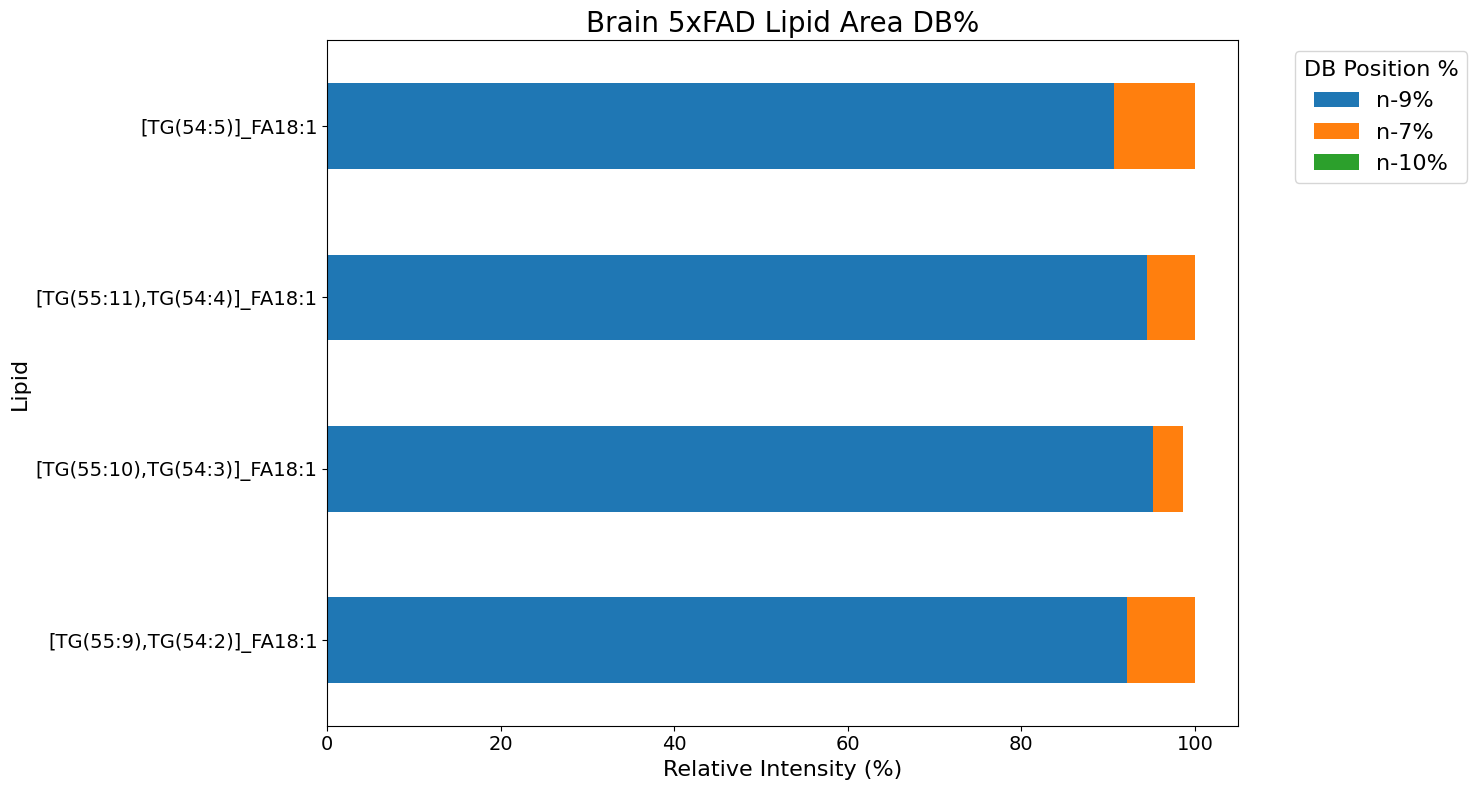

In [336]:
# Reshaping the DataFrame
reshaped_df = df_brain_5xFAD3.melt(id_vars='Lipid', value_vars=['n-7%', 'n-9%', 'n-10%', 'n-12%'], var_name='db', value_name='Percentage')


# reshaped_df = reshaped_df[~reshaped_df['Lipid'].str.contains('FA18:2')]

reshaped_df


# Creating a pivot table
pivot_df = reshaped_df.pivot_table(index='Lipid', columns='db', values='Percentage', aggfunc='sum')


# Function to generate a combined sorting key
def combined_sort_key(lipid):
    # Check if lipid contains 'FA16:1'
    fa16_1_key = '0' if 'FA16:1' in lipid else '1'  # '0' for FA16:1, '1' otherwise

    # Extract and sort TG values
    tg_list = re.findall(r'TG\(\d+:\d+\)', lipid)
    tg_list_sorted = ', '.join(sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')]))

    # Combine the keys
    return fa16_1_key + tg_list_sorted + lipid

# Apply the combined sorting function to the Lipid index to create a sorting key
pivot_df['Combined_Sort_Key'] = pivot_df.index.to_series().apply(combined_sort_key)


# Sort the DataFrame by the combined sorting key
pivot_df = pivot_df.sort_values(by='Combined_Sort_Key')

# Drop the combined sorting key column
pivot_df.drop('Combined_Sort_Key', axis=1, inplace=True)

# Reordering the columns to make n-9% appear first
column_order = ['n-9%', 'n-7%', 'n-10%']
# column_order = ['n-9%', 'n-7%', 'n-10%']
pivot_df = pivot_df[column_order]
#delete FA18:2

pivot_df
# Plotting
fig, ax = plt.subplots(figsize=(15, 8))
pivot_df.plot(kind='barh', stacked=True, ax=ax)

ax.set_xlabel('Relative Intensity (%)', fontsize = 16)
ax.set_ylabel('Lipid', fontsize = 16)
ax.set_title('Brain 5xFAD Lipid Area DB%', fontsize = 20)
plt.xticks(fontsize =14)
plt.yticks(fontsize =14)

# Moving the legend outside of the plot
ax.legend(title='DB Position %', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 16, title_fontsize = 16)

# # # Saving the plot as a PNG file
# plt.savefig('Projects/FaceFats/plots/Barstack_area/Brain5xFAD_Area.png', dpi=300, bbox_inches='tight')
# plt.savefig('Projects/FaceFats/plots/Barstack_area/Brain5xFAD_Area.pdf', dpi=300, bbox_inches='tight')
# # #save as pdf

plt.tight_layout()
plt.show()


# Brain region stacked barplot

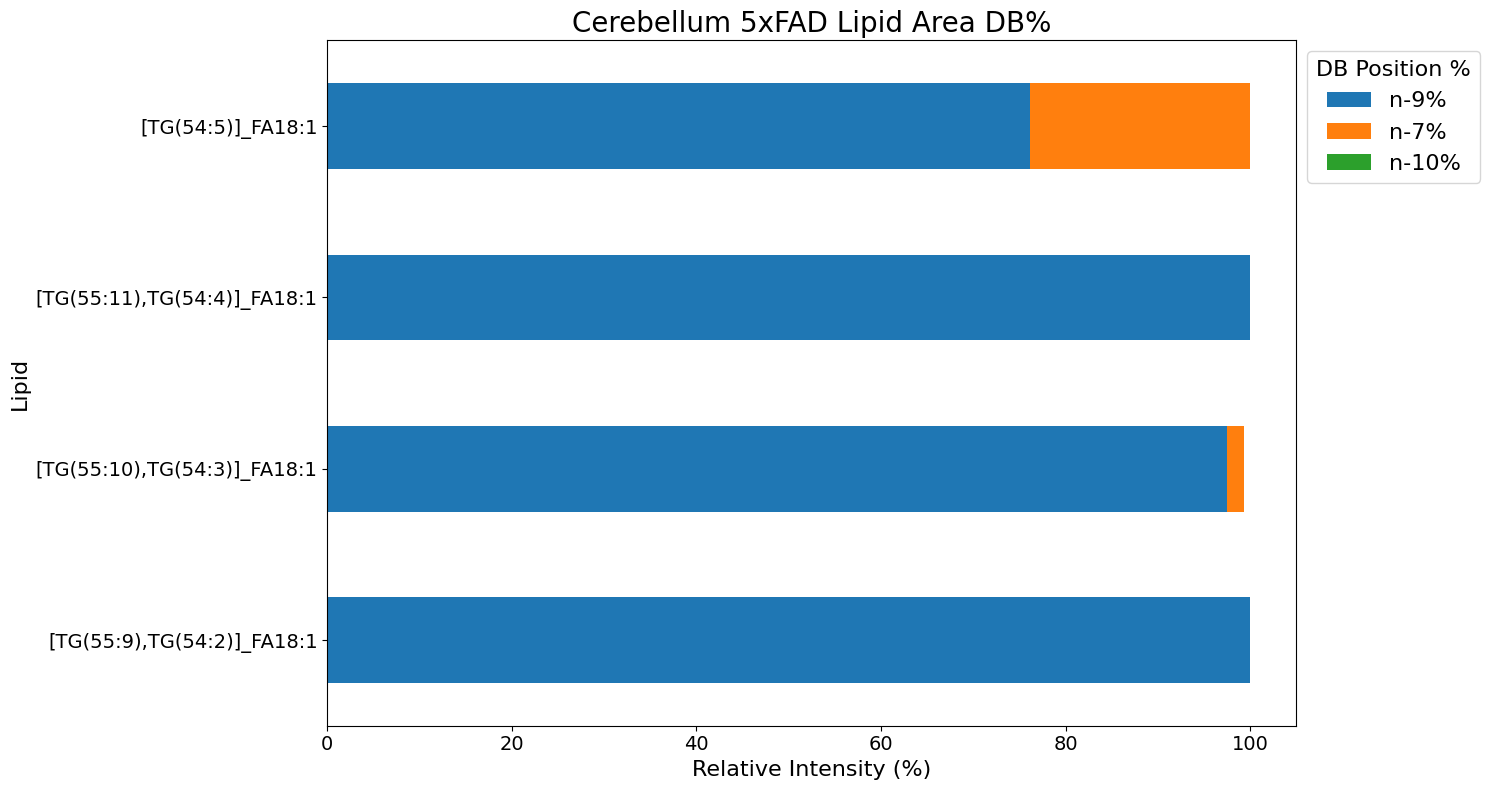

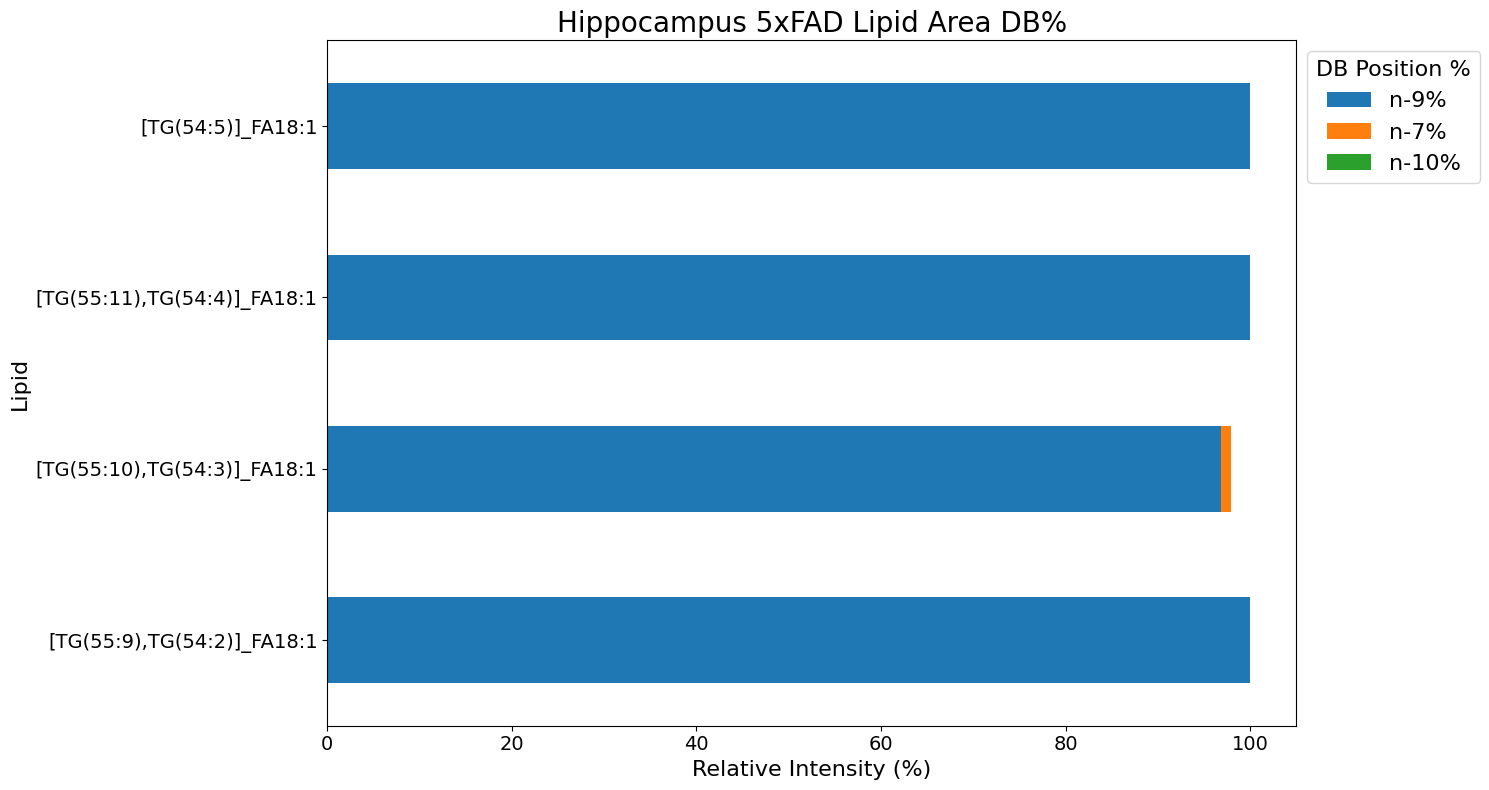

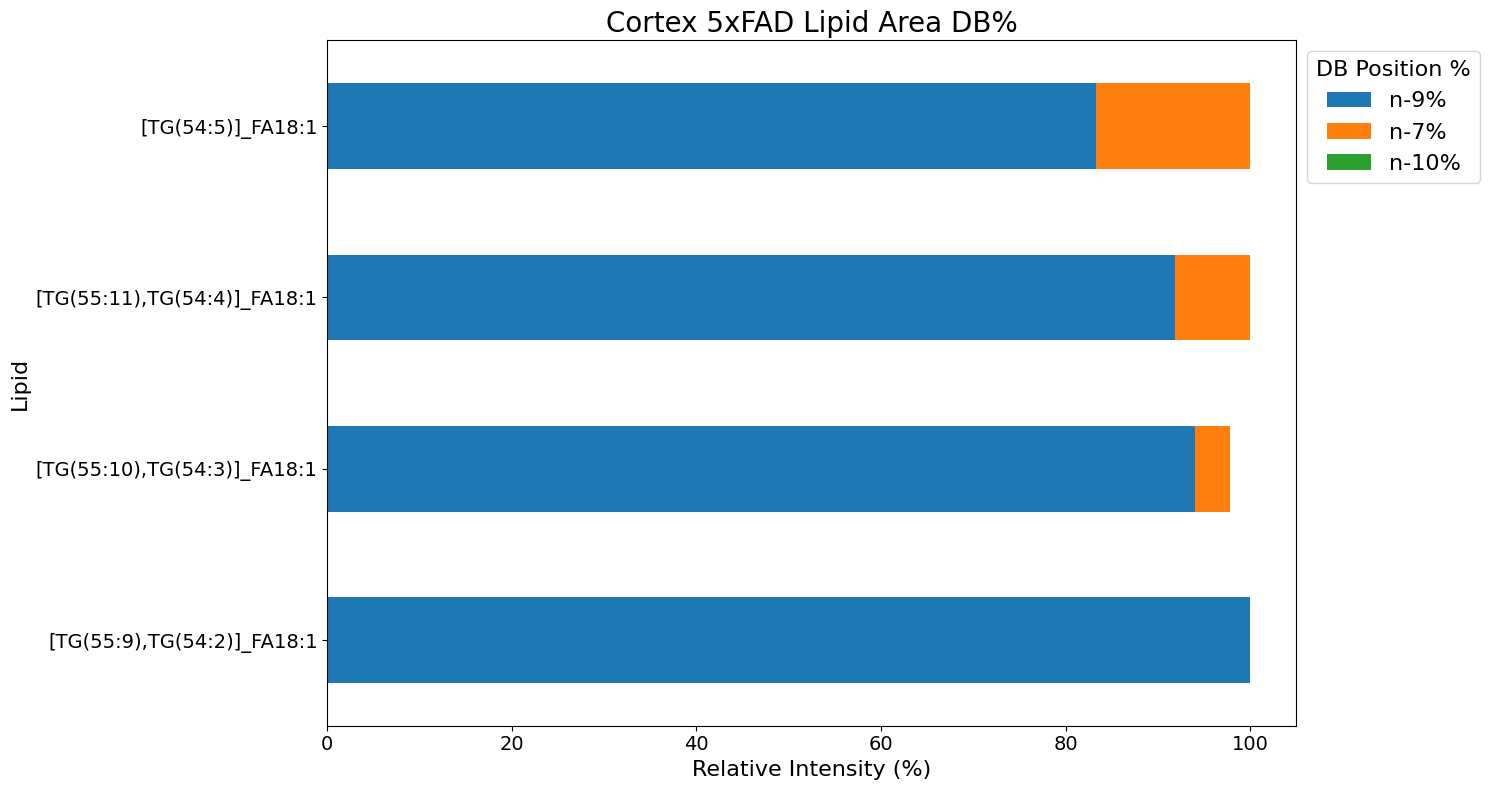

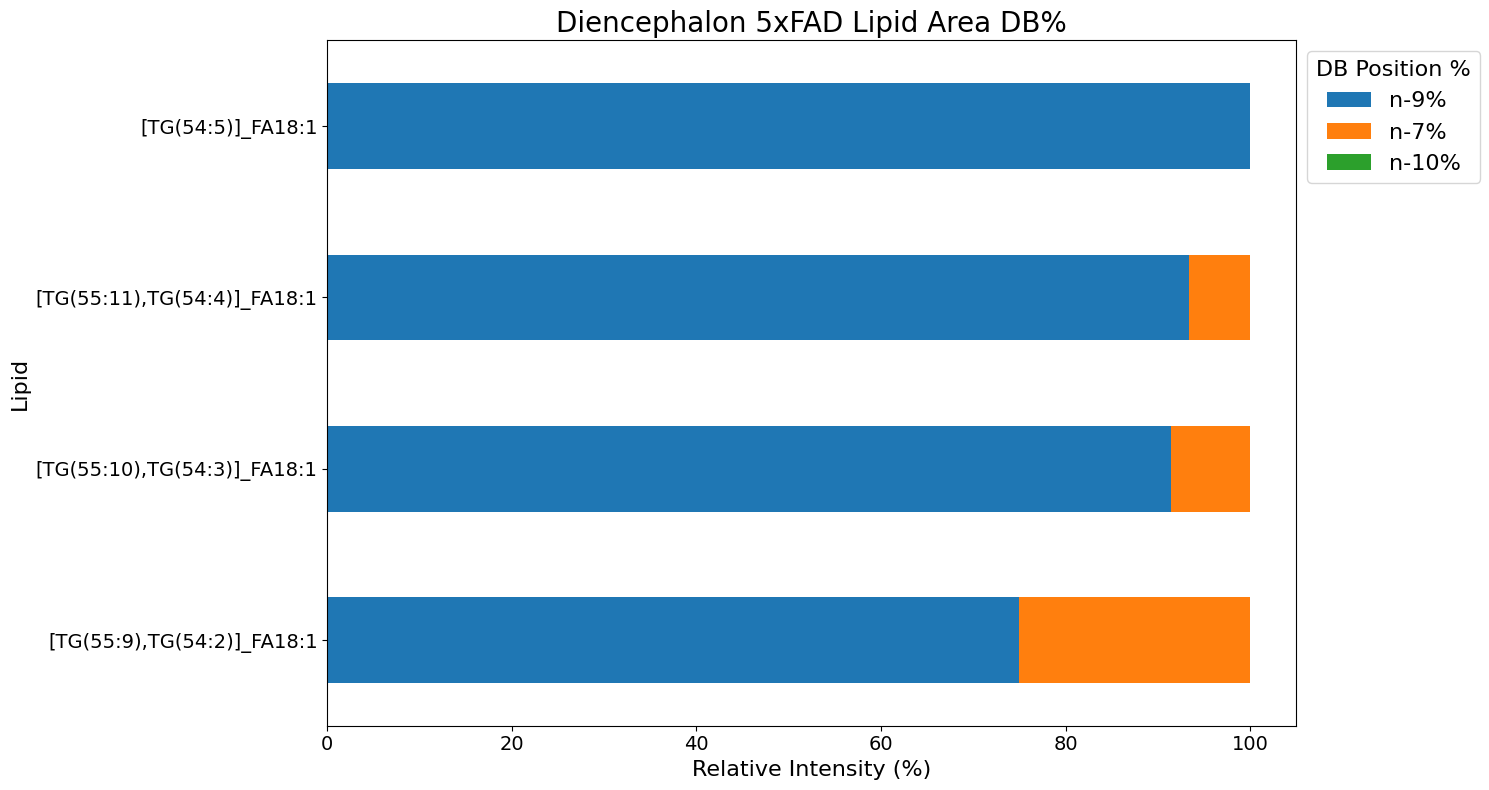

In [337]:
import matplotlib.pyplot as plt
import pandas as pd
import re

def combined_sort_key(lipid):
    fa16_1_key = '0' if 'FA16:1' in lipid else '1'
    tg_list = re.findall(r'TG\(\d+:\d+\)', lipid)
    tg_list_sorted = ', '.join(sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')]))
    return fa16_1_key + tg_list_sorted + lipid

def plot_brain_region_5xFAD(df, region_name):
    # # Calculate percentages
    # for col in ['n-7', 'n-9', 'n-10', 'n-12']:
    #     df[col + '%'] = ((df[col] / df['Total Intensity']) * 100).round(1)

    # Reshape the DataFrame
    reshaped_df = df.melt(id_vars='Lipid', value_vars=['n-7%', 'n-9%', 'n-10%', 'n-12%'], var_name='db_pos', value_name='Percentage')

    # Create pivot table
    pivot_df = reshaped_df.pivot_table(index='Lipid', columns='db_pos', values='Percentage', aggfunc='sum')[['n-9%', 'n-7%', 'n-10%']]

    # Apply the combined sorting function to the Lipid index to create a sorting key
    pivot_df['Combined_Sort_Key'] = pivot_df.index.to_series().apply(combined_sort_key)

    # Sort the DataFrame by the combined sorting key
    pivot_df = pivot_df.sort_values(by='Combined_Sort_Key')

    # Drop the combined sorting key column
    pivot_df.drop('Combined_Sort_Key', axis=1, inplace=True)

    # Plotting
    pivot_df.plot(kind='barh', stacked=True, figsize=(15, 8))
    plt.xlabel('Relative Intensity (%)', fontsize = 16)
    plt.ylabel('Lipid', fontsize = 16)
    plt.title(f'{region_name} 5xFAD Lipid Area DB%', fontsize = 20)
    plt.legend(title='DB Position %', loc='upper left', bbox_to_anchor=(1, 1), fontsize = 16, title_fontsize = 16)
    plt.xticks(fontsize =14)
    plt.yticks(fontsize =14)

    # # Saving the plot
    # plt.savefig(f'Projects/FaceFats/plots/Barstack_area/{region_name}_5xFAD_Area.png', dpi=300, bbox_inches='tight')
    # plt.savefig(f'Projects/FaceFats/plots/Barstack_area/{region_name}_5xFAD_Area.pdf', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


df_brain_5xFAD_cereb2
df_brain_5xFAD_cortex2
df_brain_5xFAD_hippo2
df_brain_5xFAD_dienc2
# Example usage
plot_brain_region_5xFAD(df_brain_5xFAD_cereb2, 'Cerebellum')
plot_brain_region_5xFAD(df_brain_5xFAD_hippo2, 'Hippocampus')
plot_brain_region_5xFAD(df_brain_5xFAD_cortex2, 'Cortex')
plot_brain_region_5xFAD(df_brain_5xFAD_dienc2, 'Diencephalon')


In [338]:
# # Assuming d17 is your DataFrame
# # Filter d17 for rows where 'Lipid' column contains 'TG(52:5)'
# filtered_d16 = d17[d17['Lipid'].str.contains('TG\(54:4\)')]

# # The filtered_d16 DataFrame now contains only rows where 'Lipid' includes 'TG(52:5)'
# filtered_d16

# Create db columns for pivot table. n7 n9 n10 n12. Focus on Liver samples only

In [339]:
# df_liver = d18[d18['Biology'] == 'liver']

# # Creating the columns n-7, n-9, n-10, and n-12 in df_liver
# df_liver['n-7'] = 0.0
# df_liver['n-9'] = 0.0
# df_liver['n-10'] = 0.0
# df_liver['n-12'] = 0.0

# # Filling the columns based on db_pos and corresponding OzESI intensity
# for index, row in df_liver.iterrows():
#     db_pos = row['db']
#     oz_intensity = row['Area_DDT']
#     if db_pos in ['n-7', 'n-9', 'n-10', 'n-12']:
#         df_liver.at[index, db_pos] = oz_intensity
# df_liver

# #print unqiue lipids
# df_liver['Lipid'].unique()

In [340]:
# # Grouping by 'Lipid' and summing up the n-7, n-9, n-10, and n-12 columns
# df_liver2 = df_liver.groupby('Lipid')[['n-7', 'n-9', 'n-10', 'n-12']].sum().round(0).reset_index()
# #Creating a new column 'Total Intensity' in df_liver2
# df_liver2['Total_Intensity'] = df_liver2[['n-7', 'n-9', 'n-10', 'n-12']].sum(axis=1)

# # Create the 'FA' column
# df_liver2['FA'] = df_liver2['Lipid'].apply(lambda x: '16' if 'FA16:1' in x else ('18' if 'FA18:1' in x else 'Other'))

# # Sort the DataFrame by the 'FA' column
# df_liver2.sort_values(by='FA', inplace=True)
# # Displaying df4
# df_liver2

In [341]:
# # Creating a new dataframe df_liver3 from df_liver2
# df_liver3 = df_liver2.copy()

# # Calculating the relative intensity of each db_pos for each lipid
# for col in ['n-7', 'n-9', 'n-10', 'n-12']:
#     df_liver3[col + '%'] = ((df_liver3[col] / df_liver3['Total_Intensity']) * 100).round(1)


# # Function to determine the value for the FAC column
# def determine_fac(lipid):
#     if 'FA18:1' in lipid:
#         return 'FA18:1'
#     elif 'FA16:1' in lipid:
#         return 'FA16:1'
#     else:
#         return None  # or some other default value

# # Apply the function to the Lipid column to create the FAC column
# df_liver3['FAC'] = df_liver3['Lipid'].apply(determine_fac)

# import pandas as pd
# import re

# # Function to extract TG values
# def extract_tg(lipid):
#     # Regular expression pattern to match TG(##:#) or similar patterns
#     pattern = r'TG\(\d+:\d+\)'
#     matches = re.findall(pattern, lipid)
#     return ', '.join(matches) if matches else None

# # Apply the function to the Lipid column to create the TG column
# df_liver3['TG'] = df_liver3['Lipid'].apply(extract_tg)




# # Function to sort TG values within a cell
# def sort_tg_values(tg_cell):
#     if not pd.isna(tg_cell) and ', ' in tg_cell:
#         tg_list = tg_cell.split(', ')
#         tg_list_sorted = sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')])
#         return ', '.join(tg_list_sorted)
#     else:
#         return tg_cell

# # Apply the function to the TG column
# df_liver3['TG'] = df_liver3['TG'].apply(sort_tg_values)
# df_liver3 = df_liver3.sort_values(by=['FAC', 'TG'])
# import pandas as pd
# import re

# # Function to remove TG(##:0) patterns from the Lipid string
# def remove_tg_zero(lipid):
#     # Pattern to match TG(##:0)
#     pattern = r'TG\(\d+:0\)'
#     # Remove TG(##:0) patterns
#     new_lipid = re.sub(pattern, '', lipid)
#     # Remove any extra commas and spaces left after removal
#     new_lipid = re.sub(r',\s+', ', ', new_lipid).strip(', ')
#     return new_lipid

# # Apply the function to the Lipid column
# df_liver3['Lipid'] = df_liver3['Lipid'].apply(remove_tg_zero)

# # Continue with the rest of your code for sorting
# # ... [rest of your code] ...

# # Displaying df_l


# # Displaying df_liver3 with the new relative intensity columns
# df_liver3


# stacked barplot

In [342]:
# # Reshaping the DataFrame
# reshaped_df = df_liver3.melt(id_vars='Lipid', value_vars=['n-7%', 'n-9%', 'n-10%', 'n-12%'], var_name='db', value_name='Percentage')


# reshaped_df = reshaped_df[~reshaped_df['Lipid'].str.contains('FA18:2')]

# reshaped_df


# # Creating a pivot table
# pivot_df = reshaped_df.pivot_table(index='Lipid', columns='db', values='Percentage', aggfunc='sum')


# # Function to generate a combined sorting key
# def combined_sort_key(lipid):
#     # Check if lipid contains 'FA16:1'
#     fa16_1_key = '0' if 'FA16:1' in lipid else '1'  # '0' for FA16:1, '1' otherwise

#     # Extract and sort TG values
#     tg_list = re.findall(r'TG\(\d+:\d+\)', lipid)
#     tg_list_sorted = ', '.join(sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')]))

#     # Combine the keys
#     return fa16_1_key + tg_list_sorted + lipid

# # Apply the combined sorting function to the Lipid index to create a sorting key
# pivot_df['Combined_Sort_Key'] = pivot_df.index.to_series().apply(combined_sort_key)

# # Sort the DataFrame by the combined sorting key
# pivot_df = pivot_df.sort_values(by='Combined_Sort_Key')

# # Drop the combined sorting key column
# pivot_df.drop('Combined_Sort_Key', axis=1, inplace=True)

# # Reordering the columns to make n-9% appear first
# column_order = ['n-9%', 'n-7%', 'n-10%', 'n-12%']
# # column_order = ['n-9%', 'n-7%', 'n-10%']
# pivot_df = pivot_df[column_order]
# #delete FA18:2

# pivot_df
# # Plotting
# fig, ax = plt.subplots(figsize=(15, 8))
# pivot_df.plot(kind='barh', stacked=True, ax=ax)

# ax.set_xlabel('Relative Intensity (%)')
# ax.set_ylabel('Lipids')
# ax.set_title('Liver 5xFAD Lipids Area DB%')
# plt.xticks(rotation=90)

# # Moving the legend outside of the plot
# ax.legend(title='db', bbox_to_anchor=(1.05, 1), loc='upper left')

# # # Saving the plot as a PNG file
# # plt.savefig('Barstack_area/Liver_5xFAD_Area.png', dpi=300, bbox_inches='tight')
# # #save as pdf
# # plt.savefig('Barstack_area/Liver_5xFAD_Area.pdf', dpi=300, bbox_inches='tight')

# plt.tight_layout()
# plt.show()


In [343]:
# # Assuming d17 is your DataFrame
# # Filter d17 for rows where 'Lipid' column contains 'TG(52:5)'
# filtered_d16 = d17[d17['Lipid'].str.contains('TG\(54:4\)')]

# # The filtered_d16 DataFrame now contains only rows where 'Lipid' includes 'TG(52:5)'
# filtered_d16